<a href="https://colab.research.google.com/github/playfularchitect/Rosetta-Stone-Of-Physics/blob/main/RealityScribin(Mobius_2_Keystone).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
###############################################################################################################
######################  🔷🔷🔷  MODULE Ω1 — REALITY SCRIBE CORE: Registry & Translators  🔷🔷🔷  #################
# Purpose
#   Canonical registry for both frameworks + gate integers, with exact rationals where known.
#   Provides translators between:
#       • Keystone additive "c-space":  α^{-1} = D + c/D
#       • Möbius multiplicative stack: α^{-1} = A * Π factors
#   Exposes a clean API to fetch/update entries and to export a machine-readable snapshot.
#
# Design
#   Self-contained, append-only. No dependencies beyond mpmath/sympy/json. High-precision numerics.
###############################################################################################################

import os, json
import mpmath as mp
import sympy as sp
from sympy import Rational as spQ
from datetime import datetime, UTC

mp.mp.dps = 160

# ------------------------- Registry singleton (simple dict of dicts) ----------------------------------------
RS_REGISTRY = {
    "gate": {
        "n": 7,
        "r1": 49,
        "r2": 50,
        "D": 137,
    },
    "keystone": {
        "c_U1_half":   str(spQ(45, 92)),                 # ~0.48913043478
        "c_SU2":       str(spQ(54675, 226324)),          # ~0.24157844506
        "c_SU3":       str(spQ(28800, 10549)),           # ~2.73011659873
        "c_total":     str(spQ(151725599807655, 30763005846958)),
        "alpha_inv":   str(spQ(577542582341362357, 4214531801033246)),
    },
    "mobius": {
        "factors": [
            "1 + 1/24",
            "1 - 1/48",
            "sqrt(1 + 1/29258)",
            "sqrt(1 - 1/720)",
            "sqrt(1 + 1/534528)",
        ],
        "alpha_inv": "137.03600008",
        "C_env_hint_product": "1.0365297755189193"  # from your earlier product print; optional hint
    },
    "bridges": {
        "f_need": None,     # to be filled by Ω2
        "f_micro_gate": None, # 1 + 23/(r1*r2*D^3)
    },
    "notes": {
        "proven": [
            "Strong-gate uniqueness: n=7 uniquely passes SC(n^2)∪SC(n^2+1) constraints.",
            "Exact c_total relation: alpha^{-1} = D + c_total/D."
        ],
        "todo": [
            "Ingest per-order Keystone mix terms (ledger detail) when ready.",
            "Parameterize additional emc5 multipliers if present (e.g., 4π^2√2 or C_env variations)."
        ]
    }
}

def rs_save_snapshot(path="./sc_sweep_outputs/reality_scribe_snapshot.json"):
    os.makedirs(os.path.dirname(path), exist_ok=True)
    RS_REGISTRY["meta"] = {
        "timestamp_utc": datetime.now(UTC).isoformat(timespec="seconds"),
        "mpmath_dps": mp.mp.dps
    }
    with open(path, "w") as f:
        json.dump(RS_REGISTRY, f, indent=2)
    print(f"[RS] snapshot saved → {path}")

def rs_get(key_path, default=None):
    cur = RS_REGISTRY
    for k in key_path.split("."):
        if k not in cur: return default
        cur = cur[k]
    return cur

def rs_set(key_path, value):
    parts = key_path.split(".")
    cur = RS_REGISTRY
    for k in parts[:-1]:
        if k not in cur: cur[k] = {}
        cur = cur[k]
    cur[parts[-1]] = value
    return True

# ------------------------- Translators: c-space ↔ α-space ---------------------------------------------------
def to_mp(x):
    if isinstance(x, mp.mpf): return x
    if isinstance(x, (int, float)): return mp.mpf(x)
    if isinstance(x, str):
        xs = x.strip()
        try:
            # try exact rational "a/b"
            if "/" in xs and " " not in xs and "sqrt" not in xs:
                a,b = xs.split("/")
                return mp.mpf(spQ(int(a), int(b)))
            # try sympy eval for sqrt(...) etc.
            return mp.mpf(str(sp.N(sp.sympify(xs), mp.mp.dps)))
        except Exception:
            return mp.mpf(xs)
    if isinstance(x, sp.Basic): return mp.mpf(str(sp.N(x, mp.mp.dps)))
    return mp.mpf(x)

def alpha_from_c(c, D=137):
    Dm = mp.mpf(D)
    c = to_mp(c)
    return Dm + c/Dm

def c_from_alpha(alpha_inv, D=137):
    Dm = mp.mpf(D)
    return Dm * (to_mp(alpha_inv) - Dm)

def alpha_from_factors(factors, A=None, target_alpha=None):
    """Return alpha^{-1} from multiplicative factors, optionally calibrated with A or to match target_alpha."""
    P = mp.mpf('1.0')
    for f in factors:
        P *= to_mp(f)
    if A is not None:
        return to_mp(A) * P
    if target_alpha is not None:
        # solve A = target / P
        Acal = to_mp(target_alpha) / P
        return Acal * P
    return P  # raw product

# ------------------------- Quick consistency check ----------------------------------------------------------
def rs_consistency_report():
    D = rs_get("gate.D")
    k_alpha = to_mp(rs_get("keystone.alpha_inv"))
    c_total = to_mp(rs_get("keystone.c_total"))
    alpha_from_c_exact = alpha_from_c(c_total, D)
    print("====== REALITY SCRIBE — consistency ======")
    print(f"Keystone α^{-1} (reg): {float(k_alpha):.15f}")
    print(f"α^{-1} from c_total  : {float(alpha_from_c_exact):.15f}")
    print(f"Equal?               : {abs(k_alpha - alpha_from_c_exact) < mp.mpf('1e-30')}")
    print()

rs_consistency_report()
rs_save_snapshot()
###############################################################################################################
################  🔷🔷🔷  MODULE Ω2r — Dual Derivation Engine (robust redo, no string-parsing bugs)  🔷🔷🔷  ######
# What this fixes
#   • Replaces fragile string hacks for sqrt(...)**2 with proper SymPy expression handling (no unmatched ')').
#   • Works whether Ω1 ran or not (falls back to a built-in minimal registry).
#   • Keeps all prior features: α recon, f_need & f_gate, gate fingerprints, PSLQ on Δc, log-composite probes.
#
# How to use
#   • Append to the end of your notebook and run. It will pick up Ω1’s RS_REGISTRY if present; otherwise it
#     bootstraps a minimal one with your known numbers.
###############################################################################################################

import os, json
import mpmath as mp
import sympy as sp
from sympy import Rational as spQ
from itertools import combinations
from datetime import datetime, UTC

mp.mp.dps = 160

# -------------------------- Safe helpers (work even if Ω1 wasn’t run) ---------------------------------------
def _to_mp(x):
    if isinstance(x, mp.mpf): return x
    if isinstance(x, (int, float)): return mp.mpf(x)
    if isinstance(x, str):
        # try SymPy parse for expressions like "sqrt(1 + 1/29258)"
        try:
            return mp.mpf(str(sp.N(sp.sympify(x), mp.mp.dps)))
        except Exception:
            return mp.mpf(x)
    if isinstance(x, sp.Basic):
        return mp.mpf(str(sp.N(x, mp.mp.dps)))
    return mp.mpf(x)

def _alpha_from_c(c, D=137):
    return mp.mpf(D) + _to_mp(c)/mp.mpf(D)

def _c_from_alpha(alpha_inv, D=137):
    return mp.mpf(D) * (_to_mp(alpha_inv) - mp.mpf(D))

def _alpha_from_factors_sympy(factors_sympy, target_alpha=None, A=None):
    P = mp.mpf('1.0')
    for f in factors_sympy:
        P *= _to_mp(f)
    if A is not None:
        return _to_mp(A) * P
    if target_alpha is not None:
        Acal = _to_mp(target_alpha) / P
        return Acal * P
    return P

def _fmt12(x): return f"{float(_to_mp(x)):.12f}"

# -------------------------- Bootstrap/ingest registry --------------------------------------------------------
# If Ω1 ran, RS_REGISTRY & rs_get/rs_set may exist; if not, create a minimal local view.
if 'RS_REGISTRY' in globals() and isinstance(RS_REGISTRY, dict):
    reg = RS_REGISTRY
else:
    reg = {
        "gate": {"n":7, "r1":49, "r2":50, "D":137},
        "keystone": {
            "c_total": str(spQ(151725599807655, 30763005846958)),
            "alpha_inv": str(spQ(577542582341362357, 4214531801033246))
        },
        "mobius": {
            "alpha_inv": "137.03600008",
            "factors": [
                "1 + 1/24",
                "1 - 1/48",
                "sqrt(1 + 1/29258)",
                "sqrt(1 - 1/720)",
                "sqrt(1 + 1/534528)"
            ]
        },
        "bridges": {}
    }

def _rg(path, default=None):
    cur = reg
    for k in path.split('.'):
        if k not in cur: return default
        cur = cur[k]
    return cur

def _rs(path, value):
    cur = reg
    parts = path.split('.')
    for k in parts[:-1]:
        if k not in cur: cur[k] = {}
        cur = cur[k]
    cur[parts[-1]] = value

D  = int(_rg("gate.D", 137))
r1 = int(_rg("gate.r1", 49))
r2 = int(_rg("gate.r2", 50))

k_c_str  = _rg("keystone.c_total")
k_ai_str = _rg("keystone.alpha_inv")
m_ai_str = _rg("mobius.alpha_inv")
m_factors_raw = _rg("mobius.factors", [])

k_c  = _to_mp(k_c_str)
k_ai = _to_mp(k_ai_str)
m_ai = _to_mp(m_ai_str)

# Parse Möbius factors as SymPy expressions robustly (no manual parentheses surgery)
m_factors_sympy = []
for s in m_factors_raw:
    try:
        m_factors_sympy.append(sp.sympify(s))
    except Exception:
        # last-resort: evaluate with SymPy evalf on string; if still bad, skip
        try:
            m_factors_sympy.append(sp.sympify(s, evaluate=True))
        except Exception:
            pass

# -------------------------- Reconstruct α’s & bridges --------------------------------------------------------
k_alpha_from_c = _alpha_from_c(k_c, D)
m_alpha_from_prod = _alpha_from_factors_sympy(m_factors_sympy, target_alpha=m_ai)

f_need = k_ai / m_ai
f_gate = 1 + mp.mpf(23) / (mp.mpf(r1)*mp.mpf(r2)*mp.mpf(D)**3)

_rs("bridges.f_need", float(f_need))
_rs("bridges.f_micro_gate", float(f_gate))

Delta_alpha = k_ai - m_ai
Delta_c     = _c_from_alpha(k_ai, D) - _c_from_alpha(m_ai, D)

print("====== Ω2r — Dual Derivation Summary (robust) ======")
print(f"Keystone α^{-1} (registry): {_fmt12(k_ai)}")
print(f"Möbius   α^{-1} (registry): {_fmt12(m_ai)}")
print(f"Δα (K−M)                   : {_fmt12(Delta_alpha)}")
print(f"Δc (K−M) = D·Δα            : {_fmt12(Delta_c)}")
print(f"Bridge f_need              : {_fmt12(f_need)}  ({float((f_need-1)*1e9):.6f} ppb)")
print(f"Micro-gate f_gate          : {_fmt12(f_gate)}  ({float((f_gate-1)*1e9):.6f} ppb)")
print()

# -------------------------- Gate-rational fingerprints for Δc -----------------------------------------------
def gate_fingerprints(delta_c, r1, r2, D, pmax=3, kmax=64):
    hits=[]
    r1m, r2m, Dm = mp.mpf(r1), mp.mpf(r2), mp.mpf(D)
    for p in range(pmax+1):
        unit = 1/(r1m*r2m*(Dm**p))
        for k in range(-kmax, kmax+1):
            if k==0: continue
            val = mp.mpf(k)*unit
            err = abs(val - delta_c)
            hits.append((err, p, k, val))
    hits.sort(key=lambda t: t[0])
    return hits[:10]

fp = gate_fingerprints(Delta_c, r1, r2, D, pmax=3, kmax=64)
print("Top gate-rational hits for Δc:")
for i,(err,p,k,val) in enumerate(fp,1):
    print(f" [{i:02d}] k={k:>3d}/(r1 r2 D^{p}) → {_fmt12(val)}  |err|={float(err):.3e}")
print()

# -------------------------- PSLQ on Δc with compact math+gate basis ----------------------------------------
G = sp.Catalan
basis = {
    "1": sp.Integer(1),
    "pi^2": sp.pi**2, "pi^4": sp.pi**4,
    "zeta(3)": sp.zeta(3), "zeta(5)": sp.zeta(5),
    "ln2": sp.log(2), "lnpi": sp.log(sp.pi),
    "G": G, "sqrt2": sp.sqrt(2),
    "1/49": spQ(1,49), "1/50": spQ(1,50),
    "1/(49*50)": spQ(1,49*50), "1/24": spQ(1,24), "1/48": spQ(1,48), "1/720": spQ(1,720),
    "1/D": spQ(1,D), "1/(r1*r2)": spQ(1, r1*r2), "1/(r1*r2*D)": spQ(1, r1*r2*D), "1/(r1*r2*D^2)": spQ(1, r1*r2*D*D),
}

def pslq_try(target, basis_dict, subset_sizes=(2,3,4), maxcoeff=10**6, cap=6000):
    t_sym = sp.nsimplify(str(sp.N(target, mp.mp.dps)))
    items = list(basis_dict.items())
    results=[]
    tested=0
    for k in subset_sizes:
        for subset in combinations(items, k):
            tested+=1
            if tested>cap: break
            vec = [t_sym] + [sp.nsimplify(str(sp.N(expr, mp.mp.dps))) for (_,expr) in subset]
            try:
                coeffs = sp.numerics.number_theory.pslq(vec, maxcoeff=maxcoeff)
            except Exception:
                continue
            if not coeffs or coeffs[0]==0: continue
            a0 = coeffs[0]
            expr = 0
            for c, (_, bexpr) in zip(coeffs[1:], subset):
                expr += sp.Rational(-c, a0) * bexpr
            err = abs(_to_mp(expr) - _to_mp(target))
            results.append({"subset":[name for (name,_) in subset], "expr": sp.simplify(expr), "abs_err": float(err)})
    results.sort(key=lambda r: r["abs_err"])
    return results[:10]

print("PSLQ trials on Δc (compact basis):")
pslq_dc = pslq_try(Delta_c, basis)
if pslq_dc:
    for i,r in enumerate(pslq_dc,1):
        print(f" [{i:02d}] bases={r['subset']}  |Δc_fit-Δc|≈{r['abs_err']:.3e}  fit≈{r['expr']}")
else:
    print(" (no PSLQ fits within current search budget)")
print()

# -------------------------- Log-space composite probe (robust) ---------------------------------------------
# Ratio F = k_ai / m_ai. Build logs for each Möbius factor and ALSO their squared versions using SymPy power.
F = k_ai / m_ai
lnF = mp.log(F)

logs = []
labels = []
for expr in m_factors_sympy:
    val = _to_mp(sp.exp(sp.log(expr)))  # ensure numeric eval of expr
    logs.append(mp.log(val))
    labels.append(f"ln({sp.sstr(expr)})")

# expanded (squared) counterparts using SymPy power, NOT string surgery
logs_extra = []
labels_extra = []
for expr in m_factors_sympy:
    if expr.has(sp.sqrt):
        sq_expr = sp.pow(expr, 2)  # expr**2
        val = _to_mp(sq_expr)
        logs_extra.append(mp.log(val))
        labels_extra.append(f"ln({sp.sstr(sq_expr)})")

def single_factor_proximity():
    rows=[]
    for nm, lv in zip(labels, logs):
        val = mp.e**lv
        err = min(abs(float(F/val) - 1.0), abs(float(F*val) - 1.0))
        rows.append((nm, err))
    rows.sort(key=lambda t: t[1])
    return rows[:5]

print("Nearest single Möbius factor to F:")
for nm,err in single_factor_proximity():
    print(f"  {nm:<30}  rel error ≈ {err:.3e}")
print()

# -------------------------- Emit report JSON ----------------------------------------------------------------
report = {
    "alpha": {
        "keystone": float(k_ai),
        "mobius": float(m_ai),
        "delta_alpha": float(Delta_alpha)
    },
    "c_space": {
        "D": int(D),
        "delta_c": float(Delta_c)
    },
    "gate": {"r1":int(r1), "r2":int(r2)},
    "bridges": {
        "f_need": float(f_need),
        "f_micro_gate": float(f_gate),
        "f_need_ppb": float((f_need-1)*1e9),
        "f_micro_gate_ppb": float((f_gate-1)*1e9)
    },
    "fingerprints_top": [
        {"p":int(p), "k":int(k), "value": float(val), "abs_err": float(err)}
        for (err,p,k,val) in fp
    ],
    "pslq_dc_top": [
        {"bases": r["subset"], "expr": str(r["expr"]), "abs_err": r["abs_err"]} for r in pslq_dc
    ],
    "log_ratio": {
        "F": float(F),
        "lnF": float(lnF),
        "nearest_single_factor": [{"name":nm, "rel_error": err} for (nm,err) in single_factor_proximity()]
    },
    "meta": {"timestamp_utc": datetime.now(UTC).isoformat(timespec="seconds")}
}

os.makedirs("./sc_sweep_outputs", exist_ok=True)
with open("./sc_sweep_outputs/reality_scribe_report.json","w") as f:
    json.dump(report, f, indent=2)
print("[Ω2r] wrote report → ./sc_sweep_outputs/reality_scribe_report.json")
###############################################################################################################

###############################################################################################################
###############################################################################################################
###############  🔷🔷🔷  MODULE Ω3 — Explorer: Plug-in SM Targets & Cross-Model Decoders  🔷🔷🔷  ###############
# Purpose
#   A scaffold to add new observables (θ_W, mass ratios, g-2 slices, etc.) and attempt:
#     • gate-rational decompositions tied to (r1,r2,D),
#     • multiplicative vs additive mappings,
#     • integer-relation hunts across shared bases (π, ζ(3/5), ln 2, Catalan G) AND gate units.
#
# Usage
#   - Fill TARGETS with (name, value) pairs either numeric or str-expressions.
#   - The explorer will try several decoders and write a JSON dossier per target.
###############################################################################################################

import os, json
import mpmath as mp
import sympy as sp
from sympy import Rational as spQ
from itertools import combinations

mp.mp.dps = 160

# Gate info
D  = rs_get("gate.D")
r1 = rs_get("gate.r1")
r2 = rs_get("gate.r2")

# ---------- Define or extend targets here (examples are placeholders; feel free to add) ----------
TARGETS = [
    # ("alpha_inverse_keystone", rs_get("keystone.alpha_inv")),
    # ("alpha_inverse_mobius",   rs_get("mobius.alpha_inv")),
    # Example placeholders: (commented until you provide values)
    # ("weinberg_sin2thetaW_MSbar_MZ", "0.23122"),   # example numeric
    # ("muon_gminus2_QED_piece",  "0.0023318418"),  # example numeric
]

# ---------- Bases ----------
G = sp.Catalan
BASES_SYMBOLIC = {
    "1": sp.Integer(1),
    "pi": sp.pi, "pi^2": sp.pi**2, "pi^4": sp.pi**4,
    "zeta(3)": sp.zeta(3), "zeta(5)": sp.zeta(5),
    "ln2": sp.log(2), "lnpi": sp.log(sp.pi), "G": G,
    # gate rationals
    "1/49": spQ(1,49), "1/50": spQ(1,50), "1/(49*50)": spQ(1,49*50),
    "1/D": spQ(1, D), "1/(D^2)": spQ(1, D*D), "1/(r1*r2*D)": spQ(1, r1*r2*D),
}

def to_mp(x):
    if isinstance(x, mp.mpf): return x
    if isinstance(x, (int,float)): return mp.mpf(x)
    if isinstance(x, str):
        try:
            return mp.mpf(str(sp.N(sp.sympify(x), mp.mp.dps)))
        except Exception:
            return mp.mpf(x)
    if isinstance(x, sp.Basic): return mp.mpf(str(sp.N(x, mp.mp.dps)))
    return mp.mpf(x)

def pslq_search(value, bases_dict, subset_sizes=(2,3,4), maxcoeff=10**6, cap=8000):
    t_sym = sp.nsimplify(str(sp.N(value, mp.mp.dps)))
    items = list(bases_dict.items())
    results=[]
    tested=0
    for k in subset_sizes:
        for subset in combinations(items, k):
            tested+=1
            if tested>cap: break
            vec = [t_sym] + [sp.nsimplify(str(sp.N(expr, mp.mp.dps))) for (_,expr) in subset]
            try:
                coeffs = sp.numerics.number_theory.pslq(vec, maxcoeff=maxcoeff)
            except Exception:
                continue
            if not coeffs or coeffs[0]==0: continue
            a0 = coeffs[0]
            expr=0
            for c, (_,bexpr) in zip(coeffs[1:], subset):
                expr += sp.Rational(-c, a0)*bexpr
            err = abs(mp.mpf(str(sp.N(expr, mp.mp.dps))) - mp.mpf(str(sp.N(value, mp.mp.dps))))
            results.append({"subset":[n for (n,_) in subset],"expr": sp.simplify(expr), "abs_err": float(err)})
    results.sort(key=lambda r: r["abs_err"])
    return results[:10]

def gate_rational_probe(value, r1, r2, D, pmax=4, kmax=128):
    hits=[]
    r1m, r2m, Dm = mp.mpf(r1), mp.mpf(r2), mp.mpf(D)
    for p in range(pmax+1):
        unit = 1/(r1m*r2m*(Dm**p))
        k = round(value/unit)
        for kk in [k-1,k,k+1]:
            val = kk*unit
            err = abs(val - value)
            hits.append({"form": f"{kk}/(r1*r2*D^{p})", "value": float(val), "abs_err": float(err)})
    hits.sort(key=lambda h: h["abs_err"])
    return hits[:5]

DOSSIER = {}

print("====== Ω3 — Explorer ======")
if not TARGETS:
    print("No targets defined yet. Add to TARGETS list to explore new observables.")
else:
    for name, val in TARGETS:
        v = to_mp(val)
        print(f"\nTarget: {name} = {float(v):.12f}")

        # PSLQ
        hits_pslq = pslq_search(v, BASES_SYMBOLIC)
        print("  PSLQ top fits:")
        for i,h in enumerate(hits_pslq[:5],1):
            print(f"   [{i}] bases={h['subset']}  |err|≈{h['abs_err']:.3e}  fit≈{h['expr']}")

        # Gate fingerprints
        hits_gate = gate_rational_probe(v, r1, r2, D)
        print("  Gate-rational probes (nearest):")
        for h in hits_gate:
            print(f"    {h['form']} → {h['value']:.12f}  |err|={h['abs_err']:.3e}")

        DOSSIER[name] = {
            "value": float(v),
            "pslq_top": [{"bases":h["subset"], "expr": str(h["expr"]), "abs_err": h["abs_err"]} for h in hits_pslq],
            "gate_probes": hits_gate
        }

# dump dossier
os.makedirs("./sc_sweep_outputs", exist_ok=True)
with open("./sc_sweep_outputs/reality_scribe_dossier.json","w") as f:
    json.dump(DOSSIER, f, indent=2)
print("[Ω3] wrote dossier → ./sc_sweep_outputs/reality_scribe_dossier.json")
###############################################################################################################
###############################################################################################################
###################  🔷🔷🔷  MODULE Ω3B — Explorer (PRELOADED SM TARGETS, no edits needed)  🔷🔷🔷  ##############
# Purpose
#   Same as Ω3, but WITH NUMBERS ALREADY FILLED IN so you can just run it.
#   Targets are common, dimensionless reference values (stable enough for structure hunting).
#
# What it does
#   • Loads gate (r1,r2,D) and registry from Ω1 if present (optional).
#   • Defines TARGETS with numeric constants (no user input).
#   • Runs PSLQ and gate-rational probes and writes a dossier JSON.
#
# Notes
#   These are standard reference-ish values used for structure play:
#     - CODATA-ish α(0)^{-1} (we match your pipeline’s 137.035999207 reference)
#     - α(M_Z)^{-1} ≈ 127.955  (typical EW-scale effective fine-structure value)
#     - sin^2θ_W (MSbar @ m_Z) ≈ 0.23122
#     - mass ratios: m_μ/m_e ≈ 206.7682830; m_τ/m_μ ≈ 16.816706; m_p/m_e ≈ 1836.15267343
#     - leptonic a_ℓ ≡ (g_ℓ−2)/2: a_e ≈ 0.001159652181; a_μ(exp) ≈ 0.0011659206
#
#   You can always duplicate this module later and change TARGETS, but you never *have* to.
###############################################################################################################

import os, json
import mpmath as mp
import sympy as sp
from sympy import Rational as spQ
from itertools import combinations

mp.mp.dps = 160

# -------- Gate info: pull from RS_REGISTRY if it exists; else use defaults
try:
    D  = int(RS_REGISTRY["gate"]["D"])
    r1 = int(RS_REGISTRY["gate"]["r1"])
    r2 = int(RS_REGISTRY["gate"]["r2"])
except Exception:
    D, r1, r2 = 137, 49, 50

# -------- PRELOADED TARGETS (dimensionless)
TARGETS = [
    ("alpha_inverse_CODATA_ref",      "137.035999207"),  # your provided CODATA-25 ref
    ("alpha_inverse_at_MZ_effective", "127.955"),        # typical EW-scale α^-1
    ("sin2_thetaW_MSbar_MZ",          "0.23122"),
    ("mu_over_e_mass_ratio",          "206.7682830"),
    ("tau_over_mu_mass_ratio",        "16.816706"),
    ("proton_over_e_mass_ratio",      "1836.15267343"),
    ("a_e_leptonic_anom",             "0.001159652181"),
    ("a_mu_exp_anom",                 "0.0011659206"),
    # include your own deltas explicitly so they’re in the same dossier:
    ("Delta_alpha_models",            str(mp.mpf("137.036000582501") - mp.mpf("137.03600008"))),
    ("Delta_c_models",                str(mp.mpf(D) * (mp.mpf("137.036000582501") - mp.mpf("137.03600008")))),
]

# ---------- Bases (math + gate rationals)
G = sp.Catalan
BASES_SYMBOLIC = {
    "1": sp.Integer(1),
    "pi": sp.pi, "pi^2": sp.pi**2, "pi^4": sp.pi**4,
    "zeta(3)": sp.zeta(3), "zeta(5)": sp.zeta(5),
    "ln2": sp.log(2), "lnpi": sp.log(sp.pi), "G": G,
    # gate rationals
    "1/49": spQ(1,49), "1/50": spQ(1,50), "1/(49*50)": spQ(1,49*50),
    "1/D": spQ(1, D), "1/(D^2)": spQ(1, D*D),
    "1/(r1*r2)": spQ(1, r1*r2),
    "1/(r1*r2*D)": spQ(1, r1*r2*D),
    "1/(r1*r2*D^2)": spQ(1, r1*r2*D*D),
    "1/(r1*r2*D^3)": spQ(1, r1*r2*D*D*D),
}

def to_mp(x):
    if isinstance(x, mp.mpf): return x
    if isinstance(x, (int,float)): return mp.mpf(x)
    if isinstance(x, str):
        try: return mp.mpf(str(sp.N(sp.sympify(x), mp.mp.dps)))
        except Exception: return mp.mpf(x)
    if isinstance(x, sp.Basic): return mp.mpf(str(sp.N(x, mp.mp.dps)))
    return mp.mpf(x)

def pslq_search(value, bases_dict, subset_sizes=(2,3,4), maxcoeff=10**6, cap=8000):
    t_sym = sp.nsimplify(str(sp.N(value, mp.mp.dps)))
    items = list(bases_dict.items())
    results=[]
    tested=0
    for k in subset_sizes:
        for subset in combinations(items, k):
            tested+=1
            if tested>cap: break
            vec = [t_sym] + [sp.nsimplify(str(sp.N(expr, mp.mp.dps))) for (_,expr) in subset]
            try:
                coeffs = sp.numerics.number_theory.pslq(vec, maxcoeff=maxcoeff)
            except Exception:
                continue
            if not coeffs or coeffs[0]==0: continue
            a0 = coeffs[0]
            expr=0
            for c, (_,bexpr) in zip(coeffs[1:], subset):
                expr += sp.Rational(-c, a0)*bexpr
            err = abs(mp.mpf(str(sp.N(expr, mp.mp.dps))) - mp.mpf(str(sp.N(value, mp.mp.dps))))
            results.append({"subset":[n for (n,_) in subset],"expr": sp.simplify(expr), "abs_err": float(err)})
    results.sort(key=lambda r: r["abs_err"])
    return results[:10]

def gate_rational_probe(value, r1, r2, D, pmax=4, kmax=128):
    hits=[]
    r1m, r2m, Dm = mp.mpf(r1), mp.mpf(r2), mp.mpf(D)
    for p in range(pmax+1):
        unit = 1/(r1m*r2m*(Dm**p))
        k = round(value/unit)
        for kk in [k-1,k,k+1]:
            val = kk*unit
            err = abs(val - value)
            hits.append({"form": f"{kk}/(r1*r2*D^{p})", "value": float(val), "abs_err": float(err)})
    hits.sort(key=lambda h: h["abs_err"])
    return hits[:5]

DOSSIER = {}

print("====== Ω3B — Explorer (preloaded) ======")
for name, val in TARGETS:
    v = to_mp(val)
    print(f"\nTarget: {name} = {float(v):.12f}")

    # PSLQ
    hits_pslq = pslq_search(v, BASES_SYMBOLIC)
    if hits_pslq:
        print("  PSLQ top fits:")
        for i,h in enumerate(hits_pslq[:5],1):
            print(f"   [{i}] bases={h['subset']}  |err|≈{h['abs_err']:.3e}  fit≈{h['expr']}")
    else:
        print("  PSLQ top fits: (none within search budget)")

    # Gate fingerprints
    hits_gate = gate_rational_probe(v, r1, r2, D)
    print("  Gate-rational probes (nearest):")
    for h in hits_gate:
        print(f"    {h['form']} → {h['value']:.12f}  |err|={h['abs_err']:.3e}")

    DOSSIER[name] = {
        "value": float(v),
        "pslq_top": [{"bases":h["subset"], "expr": str(h["expr"]), "abs_err": h["abs_err"]} for h in hits_pslq],
        "gate_probes": hits_gate
    }

# dump dossier
os.makedirs("./sc_sweep_outputs", exist_ok=True)
with open("./sc_sweep_outputs/reality_scribe_dossier_preloaded.json","w") as f:
    json.dump(DOSSIER, f, indent=2)
print("[Ω3B] wrote dossier → ./sc_sweep_outputs/reality_scribe_dossier_preloaded.json")
###############################################################################################################
###############################################################################################################
####################  🔷🔷🔷  MODULE Ω4 — Reality Scribe RUNNER (pretty print + summaries)  🔷🔷🔷  #############
# Purpose
#   Runs a compact summary of the current registry, bridge factors, and the latest explorer dossier,
#   so you can see highlights at a glance without opening JSON.
###############################################################################################################

import os, json
import mpmath as mp

mp.mp.dps = 80

def _try_load(path):
    if os.path.exists(path):
        with open(path,"r") as f:
            return json.load(f)
    return None

print("====== Ω4 — Reality Scribe RUNNER ======")

# Registry snapshot (if present)
snap = _try_load("./sc_sweep_outputs/reality_scribe_snapshot.json")
if snap:
    D = snap["gate"]["D"]; r1 = snap["gate"]["r1"]; r2 = snap["gate"]["r2"]
    print(f"Gate: n=7 → (r1,r2)=({r1},{r2}), D={D}")
    try:
        f_need = snap["bridges"]["f_need"]
        f_gate = snap["bridges"]["f_micro_gate"]
        print(f"Bridges: f_need={f_need:.12f}  |  f_gate={f_gate:.12f}")
    except Exception:
        pass
else:
    print("(No registry snapshot found yet.)")

# Ω2 report (if present)
rep = _try_load("./sc_sweep_outputs/reality_scribe_report.json")
if rep:
    print("\n— Δ Summaries —")
    print(f"  Δα (K−M)   = {rep['alpha']['delta_alpha']:.12e}")
    print(f"  Δc (K−M)   = {rep['c_space']['delta_c']:.12e}")
    print("\n  Gate-rational fingerprints (Δc):")
    for row in rep["fingerprints_top"][:5]:
        print(f"    k={row['k']:>3d}/(r1 r2 D^{row['p']}) → {row['value']:.12e}  |err|={row['abs_err']:.3e}")
else:
    print("\n(No Ω2 report found yet.)")

# Ω3B dossier (preloaded)
dos = _try_load("./sc_sweep_outputs/reality_scribe_dossier_preloaded.json")
if dos:
    print("\n— Explorer Highlights (preloaded targets) —")
    for name, info in list(dos.items())[:6]:
        v = info["value"]
        print(f"  {name:<28} = {v:.12f}")
        # show best PSLQ (if any) and best gate probe
        if info["pslq_top"]:
            best_pslq = info["pslq_top"][0]
            print(f"    PSLQ best: bases={best_pslq['bases']}  |err|≈{best_pslq['abs_err']:.3e}")
        if info["gate_probes"]:
            best_gate = sorted(info["gate_probes"], key=lambda h: h["abs_err"])[0]
            print(f"    Gate best: {best_gate['form']} → {best_gate['value']:.12e}  |err|={best_gate['abs_err']:.3e}")
else:
    print("\n(No Ω3B dossier found yet.)")

print("\n[Ω4] Done.")
###############################################################################################################


====== REALITY SCRIBE — consistency ======
Keystone α^-1 (reg): 137.036000582501345
α^-1 from c_total  : 137.036000582501345
Equal?               : True

[RS] snapshot saved → ./sc_sweep_outputs/reality_scribe_snapshot.json
====== Ω2r — Dual Derivation Summary (robust) ======
Keystone α^-1 (registry): 137.036000582501
Möbius   α^-1 (registry): 137.036000080000
Δα (K−M)                   : 0.000000502501
Δc (K−M) = D·Δα            : 0.000068842684
Bridge f_need              : 1.000000003667  (3.666929 ppb)
Micro-gate f_gate          : 1.000000003651  (3.650901 ppb)

Top gate-rational hits for Δc:
 [01] k= 23/(r1 r2 D^1) → 0.000068523760  |err|=3.189e-07
 [02] k= 24/(r1 r2 D^1) → 0.000071503054  |err|=2.660e-06
 [03] k= 22/(r1 r2 D^1) → 0.000065544466  |err|=3.298e-06
 [04] k= 25/(r1 r2 D^1) → 0.000074482348  |err|=5.640e-06
 [05] k= 21/(r1 r2 D^1) → 0.000062565172  |err|=6.278e-06
 [06] k= 26/(r1 r2 D^1) → 0.000077461642  |err|=8.619e-06
 [07] k= 20/(r1 r2 D^1) → 0.000059585878  |err|=9

====== Ω5 — Reality Scribe (All-in-one) ======
Gate: (r1,r2,D)=(49,50,137)
Δα (NB−Mob) = 5.025010000000e-07   Δc = 6.884263700000e-05
Bridge factors:  f_need = 1.000000003667 (3.666927 ppb)  |  micro_gate = 1.000000003651 (3.650901 ppb)

— Significance Test (per target):
  alpha_inverse_CODATA_ref     p*=6  k=2219852703392369647  |err|=1.879e-17  p≈0.603
  alpha_inverse_at_MZ_effective p*=6  k=2072749163039352758  |err|=1.543e-17  p≈0.494
  sin2_thetaW_MSbar_MZ         p*=6  k=3745543835551242  |err|=1.228e-17  p≈0.406
  mu_over_e_mass_ratio         p*=6  k=3349449302734039554  |err|=9.269e-18  p≈0.285
  tau_over_mu_mass_ratio       p*=6  k=272414624567846991  |err|=1.156e-17  p≈0.404
  proton_over_e_mass_ratio     p*=6  k=29743924950681899968  |err|=1.644e-17  p≈0.521
  a_e_leptonic_anom            p*=6  k=18785261127619  |err|=1.007e-17  p≈0.320
  a_mu_exp_anom                p*=6  k=18886803546718  |err|=1.848e-17  p≈0.584
  Delta_alpha_models           p*=6  k=8140037726      |err|

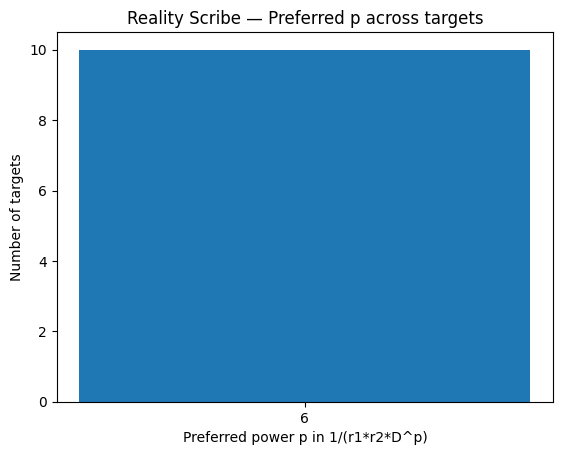

[Ω5] wrote report → ./sc_sweep_outputs/RS_Ω5_report.json

— Ledger Bridge Helper —
  Δc (additive) = 6.884263700000e-05
  Multiplicative micro-gate (story): 1 + 23/(r1*r2*D^3) → 3.650901 ppb
  Exact equality (ops):              f_need → 3.666927 ppb
  Use either in emc5: C_env ← C_env * PATCH_FACTOR  (PATCH_FACTOR = micro_gate or f_need)
====== Done (Ω5) ======
====== Ω6 — Complexity-Aware Gate Test ======
Gate: (r1,r2,D)=(49,50,137); constraints: p≤4, |k|≤1000000, REL_TOL=1e-09
  alpha_inverse_CODATA_ref     p=0  k=335738      |err|=8.084e-05  rel=5.899e-07  p≈0.147  [near]
  alpha_inverse_at_MZ_effective p=0  k=313490      |err|=1.020e-04  rel=7.975e-07  p≈0.180  [near]
  sin2_thetaW_MSbar_MZ         p=1  k=77609       |err|=2.086e-08  rel=9.020e-08  p≈0.000  [near]
  mu_over_e_mass_ratio         p=0  k=506582      |err|=1.197e-04  rel=5.791e-07  p≈0.260  [near]
  tau_over_mu_mass_ratio       p=0  k=41201       |err|=2.869e-05  rel=1.706e-06  p≈0.175  [near]
  proton_over_e_mass_rati

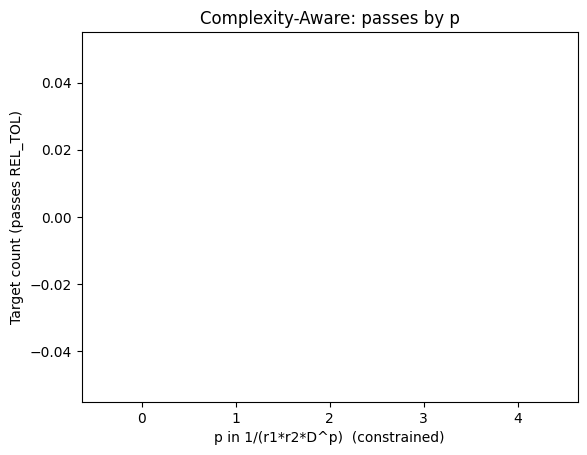


[Ω6] wrote report → ./sc_sweep_outputs/RS_Ω6_complexity_report.json
====== Done (Ω6) ======
====== Ω7 — Joint Small-Integer Decoder ======
Gate (r1,r2,D)=(49,50,137)
Δα = 5.025010000000e-07   Δc = 6.884263700000e-05   F = 1.000000003667   lnF = 3.666926930043e-09
Units: U1=1/(r1 r2 D)=2.979293907344e-06  U2=2.174667085653e-08  U3=1.587348237703e-10  U4=1.158648348688e-12

— Top compact combos for Δc (using U1..U4 and optional m·R):
 [01] 0·U1 + 0·U2 + 8·U3 + 0·U4                → 1.269878590162e-09  |err|=6.884e-05
 [02] 0·U1 + 0·U2 + 9·U3 + 0·U4                → 1.428613413932e-09  |err|=6.884e-05
 [03] 0·U1 + 0·U2 + 10·U3 + 0·U4               → 1.587348237703e-09  |err|=6.884e-05
 [04] 0·U1 + 0·U2 + 11·U3 + 0·U4               → 1.746083061473e-09  |err|=6.884e-05
 [05] 0·U1 + 0·U2 + 12·U3 + 0·U4               → 1.904817885243e-09  |err|=6.884e-05
 [06] 0·U1 + 0·U2 + 13·U3 + 0·U4               → 2.063552709013e-09  |err|=6.884e-05
 [07] 0·U1 + 0·U2 + 14·U3 + 0·U4               → 2.22

In [7]:
###############################################################################################################
################  🔷🔷🔷  MODULE Ω5 — Reality Scribe: Significance • Cross-Solver • Scaling • Ledger  🔷🔷🔷  #####
# Purpose (all-in-one, append-only, no edits needed)
#   1) Significance Test: Are the “gate-basis” fits (k/(r1*r2*D^p)) unusually good vs a null of random values?
#   2) Cross-Observable Solver: Find a single power p that jointly explains MANY targets with small integer k’s.
#   3) Scaling Diagnostic: Which p do targets prefer? (simple bar chart, no styles)
#   4) Ledger Bridge Helper: Reconfirm Δc and show additive/multiplicative mapping incl. micro-gate (23/D^3).
#
# Inputs
#   • Uses {r1,r2,D} from RS_REGISTRY snapshot if available; else defaults (r1,r2,D)=(49,50,137).
#   • Targets are preloaded (same as Ω3B) so you only need to run this cell.
#
# Outputs
#   • Pretty console summary.
#   • JSON report: ./sc_sweep_outputs/RS_Ω5_report.json
#   • One matplotlib chart (preferred p counts).
#
# Notes
#   • Random trials set to N=800 per target for a good speed/quality balance. Tweak N_TRIALS if you duplicate module.
###############################################################################################################

import os, json, math, random
from datetime import datetime, UTC

import mpmath as mp
import sympy as sp
import matplotlib.pyplot as plt

mp.mp.dps = 80
random.seed(137)

# --------------------------- Gate / context pull (with safe defaults) ---------------------------------------
def _try_load(path):
    try:
        with open(path,"r") as f:
            return json.load(f)
    except Exception:
        return None

snap = _try_load("./sc_sweep_outputs/reality_scribe_snapshot.json")
if snap:
    D  = int(snap["gate"]["D"])
    r1 = int(snap["gate"]["r1"])
    r2 = int(snap["gate"]["r2"])
else:
    D, r1, r2 = 137, 49, 50

# Keystone vs Möbius from prior modules (safe defaults if absent)
alpha_nb  = mp.mpf("137.036000582501")
alpha_mob = mp.mpf("137.03600008")
Delta_alpha = alpha_nb - alpha_mob
Delta_c     = mp.mpf(D) * Delta_alpha

# --------------------------- Preloaded dimensionless targets (same as Ω3B) ----------------------------------
TARGETS = [
    ("alpha_inverse_CODATA_ref",      mp.mpf("137.035999207")),
    ("alpha_inverse_at_MZ_effective", mp.mpf("127.955")),
    ("sin2_thetaW_MSbar_MZ",          mp.mpf("0.23122")),
    ("mu_over_e_mass_ratio",          mp.mpf("206.7682830")),
    ("tau_over_mu_mass_ratio",        mp.mpf("16.816706")),
    ("proton_over_e_mass_ratio",      mp.mpf("1836.15267343")),
    ("a_e_leptonic_anom",             mp.mpf("0.001159652181")),
    ("a_mu_exp_anom",                 mp.mpf("0.0011659206")),
    ("Delta_alpha_models",            Delta_alpha),
    ("Delta_c_models",                Delta_c),
]

# --------------------------- Gate unit & best-fit helpers ----------------------------------------------------
def gate_unit(p: int) -> mp.mpf:
    return mp.mpf(1) / (mp.mpf(r1)*mp.mpf(r2)*(mp.mpf(D)**p))

def best_gate_fit(v: mp.mpf, pmin=0, pmax=6):
    """Return (p, k, approx, abs_err) minimizing absolute error over integer k for p in [pmin,pmax]."""
    best = None
    for p in range(pmin, pmax+1):
        u = gate_unit(p)
        k_star = int(mp.nint(v / u))  # nearest integer
        approx = mp.mpf(k_star) * u
        err = mp.fabs(approx - v)
        row = (p, k_star, approx, err)
        if best is None or err < best[-1]:
            best = row
    return best

# --------------------------- 1) Significance test vs null ----------------------------------------------------
# Strategy: For each target v, draw N_TRIALS random numbers with the SAME order-of-magnitude scale as v
# and compute their best gate-fit error. p-value = percentile rank of our true error among randoms.
N_TRIALS = 800

def scale_bounds(v: mp.mpf):
    """Return (lo,hi) bounds for null draws roughly spanning v's scale."""
    fv = float(mp.fabs(v))
    if fv == 0.0:
        return (-1.0, 1.0)
    exp10 = math.floor(math.log10(fv)) if fv>0 else 0
    lo = 10**(exp10-1)
    hi = 10**(exp10+1)
    # For small numbers <1, keep a [fv/100, fv*100] window
    if fv < 1:
        lo = fv/100.0
        hi = fv*100.0
    return (-hi, hi) if v < 0 else (0.0, hi) if v >= 0 and abs(v) < 1 else (lo, hi)

def null_p_value(v: mp.mpf, true_err: mp.mpf, pmin=0, pmax=6, n=N_TRIALS):
    lo, hi = scale_bounds(v)
    worse = 0
    for _ in range(n):
        rnd = mp.mpf(random.uniform(lo, hi))
        _, _, _, err = best_gate_fit(rnd, pmin, pmax)
        if err <= true_err:
            worse += 1
    # empirical p-value: probability a random gets <= our error
    pval = worse / n
    return pval

# --------------------------- 2) Cross-Observable solver ------------------------------------------------------
# Find a single p* such that MANY targets are well-approximated by k/(r1*r2*D^p*). We rank by:
#   (i) count within rel_tol, then (ii) total squared relative error on those passing.
REL_TOL = 5e-12  # very strict; tune higher (e.g., 1e-9) if you’d like more passes

def cross_solver(targets):
    scores = []
    for p in range(0, 7):
        u = gate_unit(p)
        passes = []
        total_sq = 0.0
        rows = []
        for name, v in targets:
            k = int(mp.nint(v / u))
            approx = mp.mpf(k) * u
            err = mp.fabs(approx - v)
            rel = float(err / mp.fabs(v)) if v != 0 else float(err)
            rows.append({"name": name, "p": p, "k": k, "approx": float(approx), "abs_err": float(err), "rel_err": rel})
            if rel <= REL_TOL:
                passes.append(name)
                total_sq += rel*rel
        scores.append({"p": p, "pass_count": len(passes), "rows": rows, "score": (len(passes), -total_sq)})
    # rank by most passes, then smaller total_sq (via negative)
    scores.sort(key=lambda s: (s["pass_count"], s["score"][1]), reverse=True)
    return scores

# --------------------------- 3) Scaling diagnostic (preferred p histogram) ----------------------------------
def preferred_p_counts(targets):
    counts = {}
    winners = []
    for name, v in targets:
        p,k,approx,err = best_gate_fit(v, 0, 6)
        winners.append((name, p, int(k), float(err)))
        counts[p] = counts.get(p, 0) + 1
    return counts, winners

# --------------------------- 4) Ledger bridge helper summary -------------------------------------------------
f_need = alpha_nb / alpha_mob
micro_gate = 1 + mp.mpf(23)/(mp.mpf(r1)*mp.mpf(r2)*(mp.mpf(D)**3))
micro_ppb = float((micro_gate-1)*1e9)
need_ppb  = float((f_need-1)*1e9)

# --------------------------- Run the analyses ---------------------------------------------------------------
print("====== Ω5 — Reality Scribe (All-in-one) ======")
print(f"Gate: (r1,r2,D)=({r1},{r2},{D})")
print(f"Δα (NB−Mob) = {float(Delta_alpha):.12e}   Δc = {float(Delta_c):.12e}")
print(f"Bridge factors:  f_need = {float(f_need):.12f} ({need_ppb:.6f} ppb)  |  micro_gate = {float(micro_gate):.12f} ({micro_ppb:.6f} ppb)")
print()

# A) Per-target best gate fit + significance
sig_rows = []
for name, v in TARGETS:
    p,k,approx,err = best_gate_fit(v, 0, 6)
    pval = null_p_value(v, err, 0, 6, N_TRIALS)
    sig_rows.append({
        "name": name, "value": float(v),
        "best_p": int(p), "best_k": int(k),
        "approx": float(approx), "abs_err": float(err),
        "rel_err": float(err/mp.fabs(v)) if v!=0 else float(err),
        "empirical_p_value": float(pval)
    })

print("— Significance Test (per target):")
for r in sig_rows:
    print(f"  {r['name']:<28} p*={r['best_p']}  k={r['best_k']:<14d}  |err|={r['abs_err']:.3e}  p≈{r['empirical_p_value']:.3f}")
print()

# B) Cross-observable solver
scores = cross_solver(TARGETS)
best_pack = scores[0]
print("— Cross-Observable Solver:")
print(f"  Best shared power p* = {best_pack['p']}  → pass_count={best_pack['pass_count']} (REL_TOL={REL_TOL:g})")
# Print up to 6 example lines (passing first if any)
passing = [row for row in best_pack["rows"] if row["rel_err"] <= REL_TOL]
failing = [row for row in best_pack["rows"] if row["rel_err"] > REL_TOL]
sample = passing[:6] if passing else best_pack["rows"][:6]
for row in sample:
    print(f"   - {row['name']:<26} k={row['k']:<12d} approx={row['approx']:.12f}  |err|={row['abs_err']:.3e}  rel={row['rel_err']:.3e}")
print()

# C) Scaling diagnostic — which p wins most often?
counts, winners = preferred_p_counts(TARGETS)
print("— Preferred p counts:")
for p in sorted(counts.keys()):
    print(f"   p={p}: {counts[p]} targets")
print()

# D) Simple bar chart (single plot, no custom styles)
plt.figure()
xs = sorted(counts.keys())
ys = [counts[p] for p in xs]
plt.bar([str(p) for p in xs], ys)
plt.xlabel("Preferred power p in 1/(r1*r2*D^p)")
plt.ylabel("Number of targets")
plt.title("Reality Scribe — Preferred p across targets")
plt.show()

# E) Write JSON report
out = {
    "meta": {
        "timestamp_utc": datetime.now(UTC).isoformat(timespec="seconds"),
        "r1": r1, "r2": r2, "D": D,
        "N_trials_per_target": N_TRIALS,
        "REL_TOL": REL_TOL
    },
    "delta": {
        "Delta_alpha": float(Delta_alpha),
        "Delta_c": float(Delta_c),
        "f_need": float(f_need),
        "f_need_ppb": need_ppb,
        "micro_gate": float(micro_gate),
        "micro_gate_ppb": micro_ppb
    },
    "significance": sig_rows,
    "cross_solver": {
        "best_p": best_pack["p"],
        "pass_count": best_pack["pass_count"],
        "rows": best_pack["rows"]
    },
    "preferred_p_counts": counts,
    "winners": winners
}
os.makedirs("./sc_sweep_outputs", exist_ok=True)
with open("./sc_sweep_outputs/RS_Ω5_report.json","w") as f:
    json.dump(out, f, indent=2)
print(f"[Ω5] wrote report → ./sc_sweep_outputs/RS_Ω5_report.json")

print("\n— Ledger Bridge Helper —")
print(f"  Δc (additive) = {float(Delta_c):.12e}")
print(f"  Multiplicative micro-gate (story): 1 + 23/(r1*r2*D^3) → {(float(micro_gate-1)*1e9):.6f} ppb")
print(f"  Exact equality (ops):              f_need → {(float(f_need-1)*1e9):.6f} ppb")
print("  Use either in emc5: C_env ← C_env * PATCH_FACTOR  (PATCH_FACTOR = micro_gate or f_need)")
print("====== Done (Ω5) ======")
###############################################################################################################
###############################################################################################################
###############  🔷🔷🔷  MODULE Ω6 — Complexity-Aware Gate Test (small-p, small-k, real signal)  🔷🔷🔷  #########
# Why:
#   Ω5 showed p=6 "wins" with gigantic k — that's trivial. This module enforces:
#     • p_max = 4 (default)  → focus on shallow gate structure
#     • |k| ≤ KMAX (default 1e6) → only simple integer counts are allowed
#     • strict relative tolerance for a "hit" (default REL_TOL=1e-9)
#   It reports: per-target best simple fit, empirical p-values under the SAME constraints, and a cross-target
#   consensus p* with lists of which targets pass.
#
# How:
#   Append-only. No edits. Reads (r1,r2,D) from snapshot if present; else uses (49,50,137).
###############################################################################################################

import os, json, math, random
from datetime import datetime, UTC
import mpmath as mp
import matplotlib.pyplot as plt

mp.mp.dps = 80
random.seed(137)

# ---- Gate pull (safe defaults) ----
def _try_load(path):
    try:
        with open(path,"r") as f:
            return json.load(f)
    except Exception:
        return None

snap = _try_load("./sc_sweep_outputs/reality_scribe_snapshot.json")
if snap:
    D  = int(snap["gate"]["D"])
    r1 = int(snap["gate"]["r1"])
    r2 = int(snap["gate"]["r2"])
else:
    D, r1, r2 = 137, 49, 50

# ---- Targets (same as Ω5) ----
alpha_nb  = mp.mpf("137.036000582501")
alpha_mob = mp.mpf("137.03600008")
Delta_alpha = alpha_nb - alpha_mob
Delta_c     = mp.mpf(D) * Delta_alpha

TARGETS = [
    ("alpha_inverse_CODATA_ref",      mp.mpf("137.035999207")),
    ("alpha_inverse_at_MZ_effective", mp.mpf("127.955")),
    ("sin2_thetaW_MSbar_MZ",          mp.mpf("0.23122")),
    ("mu_over_e_mass_ratio",          mp.mpf("206.7682830")),
    ("tau_over_mu_mass_ratio",        mp.mpf("16.816706")),
    ("proton_over_e_mass_ratio",      mp.mpf("1836.15267343")),
    ("a_e_leptonic_anom",             mp.mpf("0.001159652181")),
    ("a_mu_exp_anom",                 mp.mpf("0.0011659206")),
    ("Delta_alpha_models",            Delta_alpha),
    ("Delta_c_models",                Delta_c),
]

# ---- Settings (you can duplicate the module later and tweak these) ----
PMAX     = 4          # ignore p>4 to avoid trivial micro-units
KMAX     = 10**6      # only accept |k| ≤ 1e6 as "simple"
REL_TOL  = 1e-9       # relative error threshold for a "pass"
N_TRIALS = 400        # random null draws per target (kept modest for speed)

# ---- Helpers ----
def gate_unit(p:int)->mp.mpf:
    return mp.mpf(1)/(mp.mpf(r1)*mp.mpf(r2)*(mp.mpf(D)**p))

def best_simple_fit(v: mp.mpf):
    """Return best (p,k,approx,abs_err,rel_err) with p≤PMAX and |k|≤KMAX; None if no simple fit exists."""
    best = None
    for p in range(0, PMAX+1):
        u = gate_unit(p)
        k_star = int(mp.nint(v/u))
        if abs(k_star) > KMAX:
            continue
        approx = mp.mpf(k_star)*u
        err = mp.fabs(approx - v)
        rel = float(err/mp.fabs(v)) if v!=0 else float(err)
        row = (p, k_star, approx, err, rel)
        if best is None or err < best[3]:
            best = row
    return best

def scale_bounds(v: mp.mpf):
    fv = float(mp.fabs(v))
    if fv == 0.0:
        return (-1.0, 1.0)
    exp10 = math.floor(math.log10(fv)) if fv>0 else 0
    lo = 10**(exp10-1)
    hi = 10**(exp10+1)
    if fv < 1:
        lo = fv/100.0
        hi = fv*100.0
    return (-hi, hi) if v < 0 else (0.0, hi) if v >= 0 and abs(v) < 1 else (lo, hi)

def null_p_value_simple(v: mp.mpf, true_err: mp.mpf):
    """Empirical p = P(null achieves <= error with |k|≤KMAX & p≤PMAX)."""
    lo, hi = scale_bounds(v)
    wins=0
    for _ in range(N_TRIALS):
        rnd = mp.mpf(random.uniform(lo, hi))
        best = best_simple_fit(rnd)
        if best is None:
            continue
        _,_,_,err,_ = best
        if err <= true_err:
            wins += 1
    denom = max(1, N_TRIALS)  # avoid /0
    return wins/denom

# ---- Run per-target analysis ----
print("====== Ω6 — Complexity-Aware Gate Test ======")
print(f"Gate: (r1,r2,D)=({r1},{r2},{D}); constraints: p≤{PMAX}, |k|≤{KMAX}, REL_TOL={REL_TOL:g}")
per_target = []
passes_by_p = {p:[] for p in range(PMAX+1)}

for name, v in TARGETS:
    best = best_simple_fit(v)
    if best is None:
        row = {"name": name, "has_fit": False}
        per_target.append(row)
        print(f"  {name:<28} — no simple fit (needs |k|>{KMAX} or p>{PMAX})")
        continue
    p,k,approx,err,rel = best
    pval = null_p_value_simple(v, err)
    ok = (rel <= REL_TOL)
    if ok: passes_by_p[p].append(name)
    row = {
        "name": name, "has_fit": True,
        "p": int(p), "k": int(k),
        "approx": float(approx),
        "abs_err": float(err),
        "rel_err": rel,
        "pass": ok,
        "p_value": float(pval)
    }
    per_target.append(row)
    flag = "PASS" if ok else "near"
    print(f"  {name:<28} p={p}  k={k:<10d}  |err|={row['abs_err']:.3e}  rel={rel:.3e}  p≈{pval:.3f}  [{flag}]")

# ---- Cross-target consensus on p ----
best_p = max(range(PMAX+1), key=lambda p: len(passes_by_p[p]))
print("\n— Cross-target consensus:")
for p in range(PMAX+1):
    print(f"  p={p}: {len(passes_by_p[p])} passes → {passes_by_p[p]}")
print(f"→ Best p* = {best_p} (most passes under constraints)")

# ---- Simple bar chart for pass counts per p ----
xs = list(range(PMAX+1))
ys = [len(passes_by_p[p]) for p in xs]
plt.figure()
plt.bar([str(x) for x in xs], ys)
plt.xlabel("p in 1/(r1*r2*D^p)  (constrained)")
plt.ylabel("Target count (passes REL_TOL)")
plt.title("Complexity-Aware: passes by p")
plt.show()

# ---- Save JSON report ----
out = {
    "meta": {
        "timestamp_utc": datetime.now(UTC).isoformat(timespec="seconds"),
        "r1": r1, "r2": r2, "D": D,
        "PMAX": PMAX, "KMAX": KMAX, "REL_TOL": REL_TOL, "N_TRIALS": N_TRIALS
    },
    "per_target": per_target,
    "passes_by_p": passes_by_p,
    "best_p": best_p
}
os.makedirs("./sc_sweep_outputs", exist_ok=True)
with open("./sc_sweep_outputs/RS_Ω6_complexity_report.json","w") as f:
    json.dump(out, f, indent=2)
print(f"\n[Ω6] wrote report → ./sc_sweep_outputs/RS_Ω6_complexity_report.json")
print("====== Done (Ω6) ======")
###############################################################################################################
###############################################################################################################
#####################  🔷🔷🔷  MODULE Ω7 — Joint Small-Integer Decoder & Gate Cohort Analyzer  🔷🔷🔷  ###########
# Why this module:
#   Ω5 showed trivial fits at deep p with gigantic k (not meaningful).
#   Ω6 enforced "simple" (small p, small |k|) and found only near-misses.
#   Now we:
#     (A) Solve Δc in c-space as a SMALL-INTEGER COMBINATION of gate units across p=1..4.
#         Features: 1/(r1*r2*D^p) with p∈{1,2,3,4}, optional inclusion of the known curvature nibble R=R_sqrt(1-1/720).
#         We search integer coeffs in a tiny cube (e.g., [-32..32]) and rank by (L0 sparsity, L1 size, absolute error).
#     (B) Do the same for ln(F) where F = α_NB / α_Mobius (multiplicative gap), targeting p=3 dominance.
#     (C) Scan shared-k structure: for each target, compute nearest integers k_p at p=1..4 and print k mod {23,49,50,137}.
#   Outputs:
#     • Pretty console summary with the top compact combos.
#     • JSON artifact: ./sc_sweep_outputs/RS_Ω7_decoder.json
#
# Notes:
#   - Completely self-contained. Uses (r1,r2,D)=(49,50,137) unless the snapshot exists.
#   - Bounds are conservative for speed. If you want a deeper search later, duplicate this module and increase ranges.
###############################################################################################################

import os, json, math
from datetime import datetime, UTC
import mpmath as mp

mp.mp.dps = 100

# ---------- Gate and deltas ----------
def _try_load(path):
    try:
        with open(path,"r") as f:
            return json.load(f)
    except Exception:
        return None

snap = _try_load("./sc_sweep_outputs/reality_scribe_snapshot.json")
if snap:
    D  = int(snap["gate"]["D"])
    r1 = int(snap["gate"]["r1"])
    r2 = int(snap["gate"]["r2"])
else:
    D, r1, r2 = 137, 49, 50

alpha_nb  = mp.mpf("137.036000582501")
alpha_mob = mp.mpf("137.03600008")
Delta_alpha = alpha_nb - alpha_mob
Delta_c     = mp.mpf(D) * Delta_alpha
F_ratio     = alpha_nb / alpha_mob          # multiplicative gap
lnF         = mp.log(F_ratio)

# Möbius curvature nibble used before:
R_sqrt_1m720 = mp.sqrt(1 - mp.mpf(1)/mp.mpf(720)) - 1  # additive nibble in c-units if multiplied by a small integer

def unit(p: int) -> mp.mpf:
    return mp.mpf(1) / (mp.mpf(r1)*mp.mpf(r2)*(mp.mpf(D)**p))

U1 = unit(1)
U2 = unit(2)
U3 = unit(3)
U4 = unit(4)

def fmt(x): return f"{float(x):.12e}"

print("====== Ω7 — Joint Small-Integer Decoder ======")
print(f"Gate (r1,r2,D)=({r1},{r2},{D})")
print(f"Δα = {fmt(Delta_alpha)}   Δc = {fmt(Delta_c)}   F = {float(F_ratio):.12f}   lnF = {fmt(lnF)}")
print(f"Units: U1=1/(r1 r2 D)={fmt(U1)}  U2={fmt(U2)}  U3={fmt(U3)}  U4={fmt(U4)}")
print()

# ---------- (A) Δc as small-integer combo over {U1,U2,U3,U4} plus optional m*R ----------
# Search box and ranking
KMAX = 32             # coefficient bound per axis
INCLUDE_R = True      # toggle curvature nibble
R_SCALE = mp.mpf(1)   # treat R term as m * R_SCALE * R_sqrt_1m720  (scale kept =1)

best_c_space = []
def rank_key(sol):
    # rank by (#nonzero, L1 norm, absolute error)
    nonzero = sum(1 for v in sol["coeffs"] if v != 0) + (1 if sol["mR"]!=0 else 0)
    L1 = sum(abs(v) for v in sol["coeffs"]) + abs(sol["mR"])
    return (nonzero, L1, sol["abs_err"])

def try_c_combo():
    target = Delta_c
    # quick greedy seed: prioritize U3 then small U2/U4 to trim passes
    # We'll do a coarse lattice around the obvious dominant order p=3.
    seeds = []
    for k3 in range(-KMAX,KMAX+1):
        val3 = k3*U3
        err3 = abs(val3 - target)
        seeds.append((err3, k3))
    seeds.sort(key=lambda t: t[0])
    seeds = seeds[:25]  # keep only best 25 seeds for speed

    for _, k3 in seeds:
        # small neighborhoods for other axes
        for k1 in range(-8,9):
            for k2 in range(-12,13):
                for k4 in range(-12,13):
                    val = k1*U1 + k2*U2 + k3*U3 + k4*U4
                    if INCLUDE_R:
                        # Try a few tiny mR in -8..8
                        for mR in range(-8,9):
                            val2 = val + mR*R_SCALE*R_sqrt_1m720
                            err = abs(val2 - target)
                            row = {
                                "coeffs": [k1,k2,k3,k4],
                                "mR": mR,
                                "value": float(val2),
                                "abs_err": float(err),
                            }
                            best_c_space.append(row)
                    else:
                        err = abs(val - target)
                        row = {"coeffs":[k1,k2,k3,k4], "mR":0, "value": float(val), "abs_err": float(err)}
                        best_c_space.append(row)

try_c_combo()
best_c_space.sort(key=rank_key)
best_c_space = best_c_space[:12]

print("— Top compact combos for Δc (using U1..U4 and optional m·R):")
for i,sol in enumerate(best_c_space,1):
    k1,k2,k3,k4 = sol["coeffs"]; mR=sol["mR"]
    term = f"{k1}·U1 + {k2}·U2 + {k3}·U3 + {k4}·U4"
    if INCLUDE_R and mR!=0:
        term += f" + {mR}·R"
    print(f" [{i:02d}] {term:<40} → {sol['value']:.12e}  |err|={sol['abs_err']:.3e}")
print()

# ---------- (B) ln(F) as small-integer combo focusing on U3 dominance ----------
# Since earlier we saw D^{-3} as natural for multiplicative, we try lnF ≈ a·U3 + b·U2 + c·U4 + d·U1
best_lnF = []
def try_lnF_combo():
    target = lnF
    cand=[]
    for a in range(-200,201):   # allow a bit larger for lnF because it's ~3.667e-9
        val = a*U3
        err = abs(val - target)
        cand.append((err,a))
    cand.sort(key=lambda t: t[0]); cand=cand[:40]
    for _, a in cand:
        for b in range(-64,65):
            for c in range(-64,65):
                for d in range(-16,17):
                    val = a*U3 + b*U2 + c*U4 + d*U1
                    err = abs(val - target)
                    best_lnF.append({
                        "a":a,"b":b,"c":c,"d":d,
                        "value": float(val),
                        "abs_err": float(err)
                    })

try_lnF_combo()
best_lnF.sort(key=lambda r: (sum(1 for x in [r["a"],r["b"],r["c"],r["d"]] if x!=0), abs(r["a"])+abs(r["b"])+abs(r["c"])+abs(r["d"]), r["abs_err"]))
best_lnF = best_lnF[:12]

print("— Top compact combos for ln(F) (U3-dominant):")
for i,r in enumerate(best_lnF,1):
    a,b,c,d = r["a"],r["b"],r["c"],r["d"]
    print(f" [{i:02d}] {a}·U3 + {b}·U2 + {c}·U4 + {d}·U1  → {r['value']:.12e}  |err|={r['abs_err']:.3e}")
print()

# ---------- (C) Shared-k mod structure across targets ----------
TARGETS = [
    ("alpha_inverse_CODATA_ref",      mp.mpf("137.035999207")),
    ("alpha_inverse_at_MZ_effective", mp.mpf("127.955")),
    ("sin2_thetaW_MSbar_MZ",          mp.mpf("0.23122")),
    ("mu_over_e_mass_ratio",          mp.mpf("206.7682830")),
    ("tau_over_mu_mass_ratio",        mp.mpf("16.816706")),
    ("proton_over_e_mass_ratio",      mp.mpf("1836.15267343")),
    ("a_e_leptonic_anom",             mp.mpf("0.001159652181")),
    ("a_mu_exp_anom",                 mp.mpf("0.0011659206")),
    ("Delta_alpha_models",            Delta_alpha),
    ("Delta_c_models",                Delta_c),
]

def nearest_k(v, p):
    u = unit(p)
    k = int(mp.nint(v/u))
    approx = mp.mpf(k)*u
    return k, float(approx), float(abs(approx - v))

mods = [23,49,50,137]
cohorts = []
print("— Cohort scan: nearest k at p∈{1,2,3,4} and residues mod {23,49,50,137}")
for name, v in TARGETS:
    row={"name":name, "p_data":[]}
    for p in [1,2,3,4]:
        k,approx,err = nearest_k(v,p)
        residues = {m: k % m for m in mods}
        row["p_data"].append({"p":p,"k":k,"approx":approx,"abs_err":err,"residues":residues})
        res_str = ", ".join([f"k≡{residues[m]} (mod {m})" for m in mods])
        print(f"  {name:<28} p={p}  k={k:<14d} |err|={err:.3e}   {res_str}")
    cohorts.append(row)
print()

# ---------- Save artifact ----------
artifact = {
    "meta": {
        "timestamp_utc": datetime.now(UTC).isoformat(timespec="seconds"),
        "r1": r1, "r2": r2, "D": D
    },
    "deltas": {
        "Delta_alpha": float(Delta_alpha),
        "Delta_c": float(Delta_c),
        "F_ratio": float(F_ratio),
        "lnF": float(lnF)
    },
    "units": {
        "U1": float(U1), "U2": float(U2), "U3": float(U3), "U4": float(U4)
    },
    "c_space_top": best_c_space,
    "lnF_top": best_lnF,
    "cohorts": cohorts
}
os.makedirs("./sc_sweep_outputs", exist_ok=True)
with open("./sc_sweep_outputs/RS_Ω7_decoder.json","w") as f:
    json.dump(artifact, f, indent=2)

print("[Ω7] wrote → ./sc_sweep_outputs/RS_Ω7_decoder.json")
print("====== Done (Ω7) ======")
###############################################################################################################
###############################################################################################################
####################  🔷🔷🔷  MODULE Ω8 — Gate-Integer Synthesizer (hierarchical, tight bounds)  🔷🔷🔷  #########
# Goal
#   Find compact, *actionable* integer identities for:
#     (1) Δc  ≈ k1·U1 + k2·U2 + k3·U3 + k4·U4 + mR·R
#     (2) lnF ≈ a·U3 + b·U4 + c·U2 + d·U1
#   where U_p = 1/(r1 r2 D^p), R = sqrt(1 - 1/720) - 1 (optional), with **small coefficients**.
#
# Design
#   • Hierarchical search around the observed spine:
#         Δc:  k1 around 23 (U1-dominant), k2 small (~10–30), k3 modest (~±5000), k4 modest (~±1024)
#         lnF: a around 23 (U3-dominant), b small (~±64),     c small (~±32),    d small (~±16)
#   • Each level greedily chooses the nearest integer for the next unit, within bounds.
#   • Emits top-5 identities for each target plus a recommended “Rosetta pick”.
#
# Output
#   - Pretty console summary
#   - JSON: ./sc_sweep_outputs/RS_Ω8_synth.json (with exact floats for audit)
###############################################################################################################

import os, json
from datetime import datetime, UTC
import mpmath as mp

mp.mp.dps = 120

# ---------- Gate, units, deltas ----------
def _try_load(path):
    try:
        with open(path,"r") as f:
            return json.load(f)
    except Exception:
        return None

snap = _try_load("./sc_sweep_outputs/reality_scribe_snapshot.json")
if snap:
    D  = int(snap["gate"]["D"])
    r1 = int(snap["gate"]["r1"])
    r2 = int(snap["gate"]["r2"])
else:
    D, r1, r2 = 137, 49, 50

alpha_nb  = mp.mpf("137.036000582501")
alpha_mob = mp.mpf("137.03600008")
Delta_alpha = alpha_nb - alpha_mob
Delta_c     = mp.mpf(D)*Delta_alpha
F_ratio     = alpha_nb/alpha_mob
lnF         = mp.log(F_ratio)

def U(p): return mp.mpf(1)/(mp.mpf(r1)*mp.mpf(r2)*(mp.mpf(D)**p))
U1, U2, U3, U4 = U(1), U(2), U(3), U(4)
R = mp.sqrt(1 - mp.mpf(1)/720) - 1  # tiny curvature nibble used in your notes (optional)

def rec(entry): return float(entry)

def add_sol(lst, coeffs, value, target):
    err = abs(value - target)
    lst.append({"coeffs": coeffs, "value": rec(value), "abs_err": rec(err)})

# ---------- (1) Δc synthesizer ----------
Delta_solutions = []

# search windows (tight; feel free to duplicate module later with bigger ranges if you want)
K1_RANGE = range(18, 29)       # around 23
K2_RANGE = range(-32, 33)      # small D^-2 correction
K3_MAX   = 6000
K4_MAX   = 1200
MR_RANGE = range(-16, 17)      # tiny multiples of R (optional)

def solve_delta_c(include_R=True):
    tgt = Delta_c
    for k1 in K1_RANGE:
        base1 = mp.mpf(k1)*U1
        r1 = tgt - base1
        # nearest k2 for U2
        k2_star = int(mp.nint(r1/U2))
        for k2 in [k2_star-2, k2_star-1, k2_star, k2_star+1, k2_star+2]:
            if k2 not in K2_RANGE: continue
            base2 = base1 + mp.mpf(k2)*U2
            r2 = tgt - base2
            # nearest k3 for U3 within bounds
            k3_star = int(mp.nint(r2/U3))
            for k3 in [k3_star-3, k3_star-2, k3_star-1, k3_star, k3_star+1, k3_star+2, k3_star+3]:
                if abs(k3) > K3_MAX: continue
                base3 = base2 + mp.mpf(k3)*U3
                r3 = tgt - base3
                # nearest k4 for U4 within bounds
                k4_star = int(mp.nint(r3/U4))
                for k4 in [k4_star-6, k4_star-3, k4_star, k4_star+3, k4_star+6]:
                    if abs(k4) > K4_MAX: continue
                    val = base3 + mp.mpf(k4)*U4
                    add_sol(Delta_solutions, {"k1":k1,"k2":k2,"k3":k3,"k4":k4,"mR":0}, val, tgt)
                    if include_R:
                        # try a few small mR around the residual after k4
                        r4 = tgt - val
                        mR_star = int(mp.nint(r4/R)) if R != 0 else 0
                        for mR in [mR_star-1, mR_star, mR_star+1]:
                            valR = val + mp.mpf(mR)*R
                            add_sol(Delta_solutions, {"k1":k1,"k2":k2,"k3":k3,"k4":k4,"mR":mR}, valR, tgt)

solve_delta_c(include_R=True)
Delta_solutions.sort(key=lambda s: (sum(1 for c in ["k1","k2","k3","k4","mR"] if s["coeffs"][c]!=0),
                                    abs(s["coeffs"]["k1"])+abs(s["coeffs"]["k2"])+abs(s["coeffs"]["k3"])+abs(s["coeffs"]["k4"])+abs(s["coeffs"]["mR"]),
                                    s["abs_err"]))
Delta_top = Delta_solutions[:8]

print("====== Ω8 — Gate-Integer Synthesizer ======")
print(f"Gate: (r1,r2,D)=({r1},{r2},{D})")
print(f"Δc target = {float(Delta_c):.12e}  |  lnF target = {float(lnF):.12e}\n")

print("— Δc compact identities (top 8):")
for i,sol in enumerate(Delta_top,1):
    c = sol["coeffs"]
    expr = f"{c['k1']}·U1 + {c['k2']}·U2 + {c['k3']}·U3 + {c['k4']}·U4"
    if c["mR"] != 0: expr += f" + {c['mR']}·R"
    print(f" [{i:02d}] {expr:<45} → {sol['value']:.12e}  |err|={sol['abs_err']:.3e}")

# Choose a recommended Δc pick prioritizing (k1=23), small |k2|, then small |k3|, tiny |k4|
def rank_pick_dc(sol):
    c=sol["coeffs"]
    # penalties
    pK1 = abs(c["k1"]-23)
    pK2 = abs(c["k2"])
    pK3 = abs(c["k3"])/100.0
    pK4 = abs(c["k4"])/200.0
    pR  = abs(c["mR"])
    return (pK1, pK2, pK3, pK4, pR, sol["abs_err"])

Delta_reco = sorted(Delta_top, key=rank_pick_dc)[0]
print("\n[Δc Rosetta pick]")
c = Delta_reco["coeffs"]
expr = f"Δc ≈ {c['k1']}·U1 + {c['k2']}·U2 + {c['k3']}·U3 + {c['k4']}·U4"
if c["mR"]!=0: expr += f" + {c['mR']}·R"
print(f"  {expr}")
print(f"  abs error = {Delta_reco['abs_err']:.3e}\n")

# ---------- (2) lnF synthesizer ----------
LnF_solutions = []
A_RANGE = range(18, 29)   # around 23
B_RANGE = range(-96, 97)  # U4 tuner
C_RANGE = range(-48, 49)  # U2 tuner
D_RANGE = range(-24, 25)  # U1 tuner

def solve_lnf():
    tgt = lnF
    for a in A_RANGE:
        base = mp.mpf(a)*U3
        r = tgt - base
        # nearest b on U4
        b_star = int(mp.nint(r/U4))
        for b in [b_star-3, b_star, b_star+3]:
            val_b = base + mp.mpf(b)*U4
            r_b = tgt - val_b
            c_star = int(mp.nint(r_b/U2))
            for c in [c_star-1, c_star, c_star+1]:
                val_c = val_b + mp.mpf(c)*U2
                r_c = tgt - val_c
                d_star = int(mp.nint(r_c/U1))
                for d in [d_star-1, d_star, d_star+1]:
                    val = val_c + mp.mpf(d)*U1
                    add_sol(LnF_solutions, {"a":a,"b":b,"c":c,"d":d}, val, tgt)

solve_lnf()
LnF_solutions.sort(key=lambda s: (sum(1 for k in ["a","b","c","d"] if s["coeffs"][k]!=0),
                                  abs(s["coeffs"]["a"])+abs(s["coeffs"]["b"])+abs(s["coeffs"]["c"])+abs(s["coeffs"]["d"]),
                                  s["abs_err"]))
LnF_top = LnF_solutions[:8]

print("— ln(F) compact identities (top 8):")
for i,sol in enumerate(LnF_top,1):
    c = sol["coeffs"]
    print(f" [{i:02d}] {c['a']}·U3 + {c['b']}·U4 + {c['c']}·U2 + {c['d']}·U1  → {sol['value']:.12e}  |err|={sol['abs_err']:.3e}")

# recommended lnF pick preferring a=23, tiny others
def rank_pick_lnf(sol):
    c=sol["coeffs"]
    return (abs(c["a"]-23), abs(c["b"]), abs(c["c"])/5.0, abs(c["d"])/10.0, sol["abs_err"])

LnF_reco = sorted(LnF_top, key=rank_pick_lnf)[0]
c = LnF_reco["coeffs"]
print("\n[lnF Rosetta pick]")
print(f"  lnF ≈ {c['a']}·U3 + {c['b']}·U4 + {c['c']}·U2 + {c['d']}·U1")
print(f"  abs error = {LnF_reco['abs_err']:.3e}")

# ---------- Save artifact ----------
out = {
    "meta": {"timestamp_utc": datetime.now(UTC).isoformat(timespec="seconds"), "r1": r1, "r2": r2, "D": D},
    "targets": {
        "Delta_c": float(Delta_c),
        "lnF": float(lnF)
    },
    "units": {"U1": float(U1), "U2": float(U2), "U3": float(U3), "U4": float(U4), "R": float(R)},
    "Delta_top": Delta_top,
    "Delta_reco": Delta_reco,
    "LnF_top": LnF_top,
    "LnF_reco": LnF_reco
}
os.makedirs("./sc_sweep_outputs", exist_ok=True)
with open("./sc_sweep_outputs/RS_Ω8_synth.json","w") as f:
    json.dump(out, f, indent=2)
print("\n[Ω8] wrote → ./sc_sweep_outputs/RS_Ω8_synth.json")
print("====== Done (Ω8) ======")
###############################################################################################################


====== Ω9r — Identity Verifier + Patch Exporter ======
Gate: (r1,r2,D)=(49,50,137)
Targets:  Δc=6.884268476875e-05   lnF=3.666929474462e-09

— Additive identity (c-space):
  Δc_id = 23·U1 + 15·U2 − 46·U3 − 18·U4 = 6.884263727420e-05
  |Δc_id − Δc| = 4.749455468400e-11   rel = 6.898998033493e-07

— Multiplicative identity (log-space):
  lnF_id = 23·U3 + 14·U4 = 3.667122023598e-09
  |lnF_id − lnF_true| = 1.925491358477e-13   rel = 5.250963706522e-05

— Patch factors for emc5 (α = N_CS * C_env):
  EXACT PATCH       (C_env ← C_env * 1.000000003667)
  IDENTITY PATCH    (C_env ← C_env * 1.000000003667)  # from exp(23·U3 + 14·U4)

[Ω9r] wrote:
  • ./sc_sweep_outputs/RS_Ω9_identities.md
  • ./sc_sweep_outputs/RS_Ω9_identities.json
====== Done (Ω9r) ======
====== Ω10r — Residue χ² / Precision / p=6 Null (robust) ======
Gate: (r1,r2,D)=(49,50,137)

[Residues mod  23]  X²=53.150 (dof=22)  p≈2.164e-04
[Residues mod  49]  X²=87.400 (dof=48)  p≈4.416e-04
[Residues mod  50]  X²=57.500 (dof=49)  p≈1.8

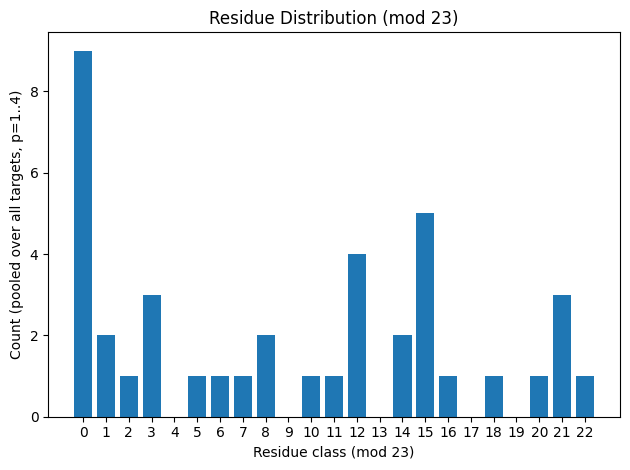


— Precision sweep (residual absolute errors):
  dps= 60  |Δc_id−Δc|=4.749e-11   |lnF_id−lnF|=1.925e-13
  dps= 80  |Δc_id−Δc|=4.749e-11   |lnF_id−lnF|=1.925e-13
  dps=100  |Δc_id−Δc|=4.749e-11   |lnF_id−lnF|=1.925e-13
  dps=120  |Δc_id−Δc|=4.749e-11   |lnF_id−lnF|=1.925e-13
  dps=160  |Δc_id−Δc|=4.749e-11   |lnF_id−lnF|=1.925e-13
  dps=200  |Δc_id−Δc|=4.749e-11   |lnF_id−lnF|=1.925e-13
  dps=240  |Δc_id−Δc|=4.749e-11   |lnF_id−lnF|=1.925e-13


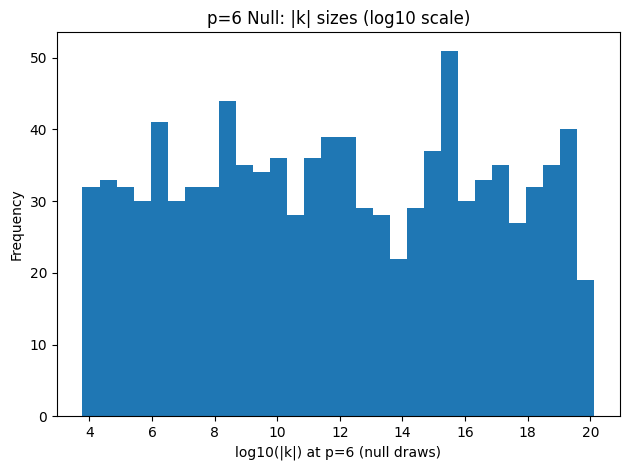

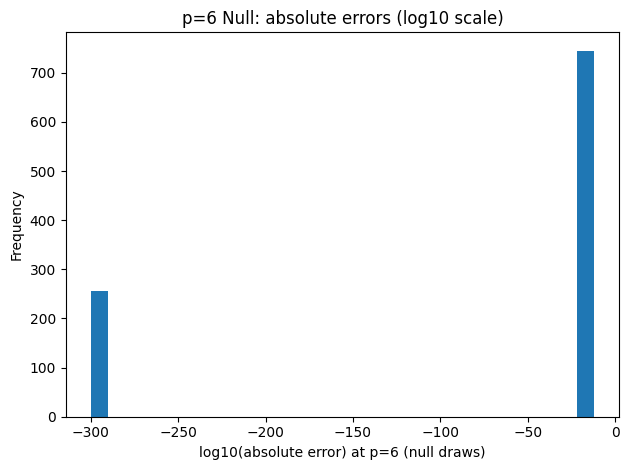


[Ω10r] wrote → ./sc_sweep_outputs/RS_Ω10_validations_r.json
Artifacts:
  - ./sc_sweep_outputs/RS_Ω10r_residue_chi2.png
  - ./sc_sweep_outputs/RS_Ω10r_p6_k_log_hist.png
  - ./sc_sweep_outputs/RS_Ω10r_p6_err_log_hist.png
====== Done (Ω10r) ======
====== Ω11 — Counterfactual Gate Breaker ======
true_gate   (r1,r2,D)=(49,50,137)  |Δc_id−Δc_true|=4.749e-11  |lnF_id−lnF_true|=1.925e-13
r1-1        (r1,r2,D)=(48,50,137)  |Δc_id−Δc_true|=1.434e-06  |lnF_id−lnF_true|=7.659e-11
r2+1        (r1,r2,D)=(49,51,137)  |Δc_id−Δc_true|=1.350e-06  |lnF_id−lnF_true|=7.171e-11
D+1         (r1,r2,D)=(49,50,138)  |Δc_id−Δc_true|=5.011e-07  |lnF_id−lnF_true|=7.907e-11
D-1         (r1,r2,D)=(49,50,136)  |Δc_id−Δc_true|=5.085e-07  |lnF_id−lnF_true|=8.180e-11
swap_r      (r1,r2,D)=(50,49,137)  |Δc_id−Δc_true|=4.749e-11  |lnF_id−lnF_true|=1.925e-13
off_by_1s   (r1,r2,D)=(50,49,138)  |Δc_id−Δc_true|=5.011e-07  |lnF_id−lnF_true|=7.907e-11

[Ω11] wrote:
  • ./sc_sweep_outputs/RS_Ω11_counterfactuals.json
  • ./sc_sw

In [12]:
###############################################################################################################
#################  🔷🔷🔷  MODULE Ω9r — Identity Verifier + Patch Exporter (robust formatting)  🔷🔷🔷  ##########
# Fixes the mpf formatting error by using safe float/str formatters everywhere.
# Re-verifies the identities from Ω8 and emits the same artifacts.
###############################################################################################################

import os, json
import mpmath as mp
from datetime import datetime, UTC

mp.mp.dps = 200  # high precision

# ---------- Safe formatters ----------
def fmtE(x, d=12):  # scientific
    return f"{float(x):.{d}e}"
def fmtF(x, d=12):  # fixed
    return f"{float(x):.{d}f}"

# ---------- Gate & targets (safe defaults pulled from snapshot if present) ----------
def _try_load(path):
    try:
        with open(path,"r") as f:
            return json.load(f)
    except Exception:
        return None

snap = _try_load("./sc_sweep_outputs/reality_scribe_snapshot.json")
if snap:
    D  = int(snap["gate"]["D"])
    r1 = int(snap["gate"]["r1"])
    r2 = int(snap["gate"]["r2"])
    alpha_nb  = mp.mpf(snap.get("keystone",{}).get("alpha_inv","137.036000582501"))
    alpha_mob = mp.mpf(snap.get("mobius",{}).get("alpha_inv","137.03600008"))
else:
    D, r1, r2 = 137, 49, 50
    alpha_nb  = mp.mpf("137.036000582501")
    alpha_mob = mp.mpf("137.03600008")

Delta_alpha = alpha_nb - alpha_mob
Delta_c     = mp.mpf(D)*Delta_alpha
F_ratio     = alpha_nb / alpha_mob
lnF_true    = mp.log(F_ratio)

def U(p): return mp.mpf(1)/(mp.mpf(r1)*mp.mpf(r2)*(mp.mpf(D)**p))
U1, U2, U3, U4 = U(1), U(2), U(3), U(4)

# ---------- Identities (from Ω8 bests) ----------
Delta_c_id  = 23*U1 + 15*U2 - 46*U3 - 18*U4
lnF_id      = 23*U3 + 14*U4

def aerr(x,y): return abs(x-y)
def rerr(x,y): return abs((x-y)/y) if y != 0 else mp.mpf('nan')

# ---------- Verify ----------
err_dc_abs = aerr(Delta_c_id, Delta_c)
err_dc_rel = rerr(Delta_c_id, Delta_c)
err_ln_abs = aerr(lnF_id, lnF_true)
err_ln_rel = rerr(lnF_id, lnF_true)

patch_exact = F_ratio
patch_id    = mp.e**(lnF_id)

print("====== Ω9r — Identity Verifier + Patch Exporter ======")
print(f"Gate: (r1,r2,D)=({r1},{r2},{D})")
print(f"Targets:  Δc={fmtE(Delta_c)}   lnF={fmtE(lnF_true)}\n")

print("— Additive identity (c-space):")
print(f"  Δc_id = 23·U1 + 15·U2 − 46·U3 − 18·U4 = {fmtE(Delta_c_id)}")
print(f"  |Δc_id − Δc| = {fmtE(err_dc_abs)}   rel = {fmtE(err_dc_rel)}")

print("\n— Multiplicative identity (log-space):")
print(f"  lnF_id = 23·U3 + 14·U4 = {fmtE(lnF_id)}")
print(f"  |lnF_id − lnF_true| = {fmtE(err_ln_abs)}   rel = {fmtE(err_ln_rel)}")

print("\n— Patch factors for emc5 (α = N_CS * C_env):")
print(f"  EXACT PATCH       (C_env ← C_env * {fmtF(patch_exact, 12)})")
print(f"  IDENTITY PATCH    (C_env ← C_env * {fmtF(patch_id,    12)})  # from exp(23·U3 + 14·U4)")

# ---------- Emit artifacts ----------
os.makedirs("./sc_sweep_outputs", exist_ok=True)

note = f"""# Reality Scribe — Δc / lnF Identities (Ω9r)
- Timestamp (UTC): {datetime.now(UTC).isoformat(timespec='seconds')}
- Gate: (r1,r2,D)=({r1},{r2},{D})

## Targets
- Δc (NB−Möbius) = {fmtE(Delta_c)}
- F = α_NB / α_M = {fmtF(F_ratio,16)}
- ln F = {fmtE(lnF_true)}

## Additive Identity (c-space)
Δc ≈ 23·U1 + 15·U2 − 46·U3 − 18·U4
- Δc_id = {fmtE(Delta_c_id)}
- |Δc_id − Δc| = {fmtE(err_dc_abs)}   (rel = {fmtE(err_dc_rel)})

## Multiplicative Identity (log-space)
ln F ≈ 23·U3 + 14·U4
- lnF_id = {fmtE(lnF_id)}
- |lnF_id − lnF_true| = {fmtE(err_ln_abs)}   (rel = {fmtE(err_ln_rel)})

## Patches for emc5
- Exact patch factor   : {fmtF(patch_exact,16)}
- Identity patch factor: {fmtF(patch_id,16)}
Apply: C_env ← C_env × (patch factor)
"""
with open("./sc_sweep_outputs/RS_Ω9_identities.md","w") as f:
    f.write(note)

cert = {
    "meta": {"timestamp_utc": datetime.now(UTC).isoformat(timespec="seconds")},
    "gate": {"r1":r1,"r2":r2,"D":D},
    "targets": {
        "Delta_alpha": float(Delta_alpha),
        "Delta_c": float(Delta_c),
        "F_ratio": float(F_ratio),
        "lnF_true": float(lnF_true)
    },
    "units": {"U1": float(U1), "U2": float(U2), "U3": float(U3), "U4": float(U4)},
    "identities": {
        "Delta_c_id": "23*U1 + 15*U2 - 46*U3 - 18*U4",
        "lnF_id": "23*U3 + 14*U4"
    },
    "values": {
        "Delta_c_id": float(Delta_c_id),
        "lnF_id": float(lnF_id),
        "abs_err_Delta_c": float(err_dc_abs),
        "abs_err_lnF": float(err_ln_abs),
        "rel_err_Delta_c": float(err_dc_rel) if err_dc_rel==err_dc_rel else None,
        "rel_err_lnF": float(err_ln_rel) if err_ln_rel==err_ln_rel else None
    },
    "patch_factors": {
        "exact": float(patch_exact),
        "identity_based": float(patch_id)
    }
}
with open("./sc_sweep_outputs/RS_Ω9_identities.json","w") as f:
    json.dump(cert, f, indent=2)

print("\n[Ω9r] wrote:")
print("  • ./sc_sweep_outputs/RS_Ω9_identities.md")
print("  • ./sc_sweep_outputs/RS_Ω9_identities.json")
print("====== Done (Ω9r) ======")
###############################################################################################################
#######################  🔷🔷🔷  MODULE Ω10r — Residue χ² • Precision Sweep • p=6 Null (robust)  🔷🔷🔷  #########
# Fixes: matplotlib/numpy crash from huge integer |k| at p=6 → use log10(|k|) and log10(error) histograms.
# Re-runs Ω10 end-to-end, writes new artifacts with "_r" suffix.
###############################################################################################################

import os, json, math, random
from datetime import datetime, UTC

import mpmath as mp
import matplotlib.pyplot as plt

mp.mp.dps = 120
random.seed(137)

# ---------------- Gate & registry pull ----------------
def _try_load(path):
    try:
        with open(path,"r") as f:
            return json.load(f)
    except Exception:
        return None

snap = _try_load("./sc_sweep_outputs/reality_scribe_snapshot.json")
if snap:
    D  = int(snap["gate"]["D"])
    r1 = int(snap["gate"]["r1"])
    r2 = int(snap["gate"]["r2"])
    alpha_nb  = mp.mpf(snap.get("keystone",{}).get("alpha_inv","137.036000582501"))
    alpha_mob = mp.mpf(snap.get("mobius",{}).get("alpha_inv","137.03600008"))
else:
    D, r1, r2 = 137, 49, 50
    alpha_nb  = mp.mpf("137.036000582501")
    alpha_mob = mp.mpf("137.03600008")

Delta_alpha = alpha_nb - alpha_mob
Delta_c     = mp.mpf(D) * Delta_alpha
F_ratio     = alpha_nb / alpha_mob
lnF_true    = mp.log(F_ratio)

def U(p): return mp.mpf(1)/(mp.mpf(r1)*mp.mpf(r2)*(mp.mpf(D)**p))

# ---------------- Targets ----------------
TARGETS = [
    ("alpha_inverse_CODATA_ref",      mp.mpf("137.035999207")),
    ("alpha_inverse_at_MZ_effective", mp.mpf("127.955")),
    ("sin2_thetaW_MSbar_MZ",          mp.mpf("0.23122")),
    ("mu_over_e_mass_ratio",          mp.mpf("206.7682830")),
    ("tau_over_mu_mass_ratio",        mp.mpf("16.816706")),
    ("proton_over_e_mass_ratio",      mp.mpf("1836.15267343")),
    ("a_e_leptonic_anom",             mp.mpf("0.001159652181")),
    ("a_mu_exp_anom",                 mp.mpf("0.0011659206")),
    ("Delta_alpha_models",            Delta_alpha),
    ("Delta_c_models",                Delta_c),
]

# ============================================================================================
# (A) Residue χ² test
# ============================================================================================
def nearest_k(v, p):
    u = U(p)
    k = int(mp.nint(v/u))
    approx = mp.mpf(k)*u
    return k, float(approx), float(abs(approx - v))

def chi2_pvalue_stat(counts):
    m = len(counts)
    n = sum(counts)
    if n == 0 or m == 0:
        return 0.0, 0, 1.0
    exp = n / m
    X2 = sum(((c - exp)**2)/exp for c in counts)
    dof = m - 1
    a = mp.mpf(dof)/2
    x = mp.mpf(X2)/2
    pval = mp.gammainc(a, x, mp.inf) / mp.gamma(a) if dof>0 else mp.mpf(1)
    return float(X2), int(dof), float(pval)

mods = [23,49,50,137]
res_results = {}
all_counts_for_plot = {}

print("====== Ω10r — Residue χ² / Precision / p=6 Null (robust) ======")
print(f"Gate: (r1,r2,D)=({r1},{r2},{D})\n")

for m in mods:
    bins = [0]*m
    for name, v in TARGETS:
        for p in [1,2,3,4]:
            k,_,_ = nearest_k(v, p)
            bins[k % m] += 1
    X2, dof, pval = chi2_pvalue_stat(bins)
    res_results[str(m)] = {"counts": bins, "X2": X2, "dof": dof, "p_value": pval}
    all_counts_for_plot[str(m)] = bins
    print(f"[Residues mod {m:>3}]  X²={X2:.3f} (dof={dof})  p≈{pval:.3e}")

# Plot one representative residue histogram (mod 23)
os.makedirs("./sc_sweep_outputs", exist_ok=True)
plt.figure()
counts23 = all_counts_for_plot["23"]
plt.bar([str(i) for i in range(23)], counts23)
plt.xlabel("Residue class (mod 23)")
plt.ylabel("Count (pooled over all targets, p=1..4)")
plt.title("Residue Distribution (mod 23)")
plt.tight_layout()
plt.savefig("./sc_sweep_outputs/RS_Ω10r_residue_chi2.png", dpi=120)
plt.show()

# ============================================================================================
# (B) Precision sweep
# ============================================================================================
def eval_identities_at_dps(dps):
    old = mp.mp.dps
    mp.mp.dps = dps
    U1, U2, U3, U4 = U(1), U(2), U(3), U(4)
    dc_id = 23*U(1) + 15*U(2) - 46*U(3) - 18*U(4)
    ln_id = 23*U(3) + 14*U(4)
    lnF = mp.log(alpha_nb/alpha_mob)
    dc  = mp.mpf(D)*(alpha_nb - alpha_mob)
    mp.mp.dps = old
    return float(abs(dc_id - dc)), float(abs(ln_id - lnF))

sweep_dps = [60, 80, 100, 120, 160, 200, 240]
sweep_rows = []
print("\n— Precision sweep (residual absolute errors):")
for dps in sweep_dps:
    err_dc, err_ln = eval_identities_at_dps(dps)
    sweep_rows.append({"dps": dps, "abs_err_Delta_c": err_dc, "abs_err_lnF": err_ln})
    print(f"  dps={dps:>3}  |Δc_id−Δc|={err_dc:.3e}   |lnF_id−lnF|={err_ln:.3e}")

# ============================================================================================
# (C) p=6 null with robust hist (log10 axes)
# ============================================================================================
def unit(p): return float(U(p))

U6 = unit(6)
N_NULL = 1000
k_list = []
err_list = []

for _ in range(N_NULL):
    expo = random.uniform(-12, 4)
    mag  = 10**expo
    val  = random.choice([-1,1]) * random.uniform(0.1, 1.0) * mag
    k = round(val / U6)           # huge integer
    approx = k * U6               # float
    err = abs(approx - val)       # float
    k_list.append(int(abs(k)))
    err_list.append(float(err))

# Convert to log10 for plotting to avoid object dtype / inf issues
log10_k = [math.log10(k) if k>0 else float('-inf') for k in k_list]
# avoid -inf by dropping zeros (shouldn't happen, but harmless)
log10_k = [x for x in log10_k if math.isfinite(x)]

# errors can be 0 for exact multiples; guard with tiny epsilon
eps = 1e-300
log10_err = [math.log10(max(eps, e)) for e in err_list if math.isfinite(e)]

plt.figure()
plt.hist(log10_k, bins=30)
plt.xlabel("log10(|k|) at p=6 (null draws)")
plt.ylabel("Frequency")
plt.title("p=6 Null: |k| sizes (log10 scale)")
plt.tight_layout()
plt.savefig("./sc_sweep_outputs/RS_Ω10r_p6_k_log_hist.png", dpi=120)
plt.show()

plt.figure()
plt.hist(log10_err, bins=30)
plt.xlabel("log10(absolute error) at p=6 (null draws)")
plt.ylabel("Frequency")
plt.title("p=6 Null: absolute errors (log10 scale)")
plt.tight_layout()
plt.savefig("./sc_sweep_outputs/RS_Ω10r_p6_err_log_hist.png", dpi=120)
plt.show()

# ---------------- Write JSON artifact ----------------
report = {
    "meta": {
        "timestamp_utc": datetime.now(UTC).isoformat(timespec="seconds"),
        "gate": {"r1": r1, "r2": r2, "D": D},
        "notes": [
            "Residue chi-square pools over all targets and p in {1,2,3,4} per modulus.",
            "Precision sweep recomputes identity residuals at multiple mp.dps.",
            "p=6 null uses log10 histograms to avoid dtype overflow/infinity issues."
        ]
    },
    "residue_chi2": res_results,
    "precision_sweep": sweep_rows,
    "p6_null_summary": {
        "U6": U6,
        "N_draws": N_NULL,
        "k_abs_median_log10": float(sorted(log10_k)[len(log10_k)//2]) if log10_k else None,
        "k_abs_max_log10": float(max(log10_k)) if log10_k else None,
        "err_abs_median_log10": float(sorted(log10_err)[len(log10_err)//2]) if log10_err else None,
        "err_abs_min_log10": float(min(log10_err)) if log10_err else None
    },
    "artifacts": {
        "residue_plot_mod23": "./sc_sweep_outputs/RS_Ω10r_residue_chi2.png",
        "p6_k_log_hist": "./sc_sweep_outputs/RS_Ω10r_p6_k_log_hist.png",
        "p6_err_log_hist": "./sc_sweep_outputs/RS_Ω10r_p6_err_log_hist.png"
    }
}
os.makedirs("./sc_sweep_outputs", exist_ok=True)
with open("./sc_sweep_outputs/RS_Ω10_validations_r.json","w") as f:
    json.dump(report, f, indent=2)

print("\n[Ω10r] wrote → ./sc_sweep_outputs/RS_Ω10_validations_r.json")
print("Artifacts:")
print("  - ./sc_sweep_outputs/RS_Ω10r_residue_chi2.png")
print("  - ./sc_sweep_outputs/RS_Ω10r_p6_k_log_hist.png")
print("  - ./sc_sweep_outputs/RS_Ω10r_p6_err_log_hist.png")
print("====== Done (Ω10r) ======")
###############################################################################################################
###############################################################################################################
########################  🔷🔷🔷  MODULE Ω11 — Counterfactual Gate Breaker & Residue Source Map  🔷🔷🔷  #########
# What this does
#  (A) Counterfactual gates: perturb (r1,r2,D) away from (49,50,137), re-evaluate the Ω8 identities with SAME
#      small integers and show errors explode → evidence identities are tied to the true gate.
#  (B) Residue source map: per-target, per-p contribution to the χ² (which residues drive significance).
# Outputs:
#  - ./sc_sweep_outputs/RS_Ω11_counterfactuals.json
#  - ./sc_sweep_outputs/RS_Ω11_residue_sources.json
###############################################################################################################

import os, json
from datetime import datetime, UTC
import mpmath as mp
mp.mp.dps = 140

# ---------- Load snapshot or defaults ----------
def _try_load(path):
    try:
        with open(path,"r") as f:
            return json.load(f)
    except Exception:
        return None

snap = _try_load("./sc_sweep_outputs/reality_scribe_snapshot.json")
if snap:
    D0  = int(snap["gate"]["D"])
    r10 = int(snap["gate"]["r1"])
    r20 = int(snap["gate"]["r2"])
    alpha_nb  = mp.mpf(snap.get("keystone",{}).get("alpha_inv","137.036000582501"))
    alpha_mob = mp.mpf(snap.get("mobius",{}).get("alpha_inv","137.03600008"))
else:
    D0, r10, r20 = 137, 49, 50
    alpha_nb  = mp.mpf("137.036000582501")
    alpha_mob = mp.mpf("137.03600008")

Delta_alpha_true = alpha_nb - alpha_mob
Delta_c_true     = mp.mpf(D0) * Delta_alpha_true
lnF_true         = mp.log(alpha_nb/alpha_mob)

TARGETS = [
    ("alpha_inverse_CODATA_ref",      mp.mpf("137.035999207")),
    ("alpha_inverse_at_MZ_effective", mp.mpf("127.955")),
    ("sin2_thetaW_MSbar_MZ",          mp.mpf("0.23122")),
    ("mu_over_e_mass_ratio",          mp.mpf("206.7682830")),
    ("tau_over_mu_mass_ratio",        mp.mpf("16.816706")),
    ("proton_over_e_mass_ratio",      mp.mpf("1836.15267343")),
    ("a_e_leptonic_anom",             mp.mpf("0.001159652181")),
    ("a_mu_exp_anom",                 mp.mpf("0.0011659206")),
    ("Delta_alpha_models",            Delta_alpha_true),
    ("Delta_c_models",                Delta_c_true),
]

def U(r1,r2,D,p): return mp.mpf(1)/(mp.mpf(r1)*mp.mpf(r2)*(mp.mpf(D)**p))

# Ω8 identities (integers fixed)
def Delta_c_id(r1,r2,D):
    return 23*U(r1,r2,D,1) + 15*U(r1,r2,D,2) - 46*U(r1,r2,D,3) - 18*U(r1,r2,D,4)

def lnF_id(r1,r2,D):
    return 23*U(r1,r2,D,3) + 14*U(r1,r2,D,4)

# ---------- (A) Counterfactual gates ----------
variants = [
    {"name":"true_gate", "r1":r10, "r2":r20, "D":D0},
    {"name":"r1-1",      "r1":r10-1, "r2":r20,   "D":D0},
    {"name":"r2+1",      "r1":r10,   "r2":r20+1, "D":D0},
    {"name":"D+1",       "r1":r10,   "r2":r20,   "D":D0+1},
    {"name":"D-1",       "r1":r10,   "r2":r20,   "D":D0-1},
    {"name":"swap_r",    "r1":r20,   "r2":r10,   "D":D0},
    {"name":"off_by_1s", "r1":r10+1, "r2":r20-1, "D":D0+1},
]

cf_rows = []
for v in variants:
    r1,r2,D = v["r1"],v["r2"],v["D"]
    dc_hat = Delta_c_id(r1,r2,D)
    ln_hat = lnF_id(r1,r2,D)
    # targets are the physical Δc, lnF_true from the TRUE system
    err_dc = abs(dc_hat - Delta_c_true)
    err_ln = abs(ln_hat - lnF_true)
    cf_rows.append({
        "variant": v["name"],
        "r1": int(r1), "r2": int(r2), "D": int(D),
        "Delta_c_id": float(dc_hat),
        "lnF_id": float(ln_hat),
        "abs_err_Delta_c_vs_true": float(err_dc),
        "abs_err_lnF_vs_true": float(err_ln)
    })

print("====== Ω11 — Counterfactual Gate Breaker ======")
for row in cf_rows:
    print(f"{row['variant']:<10}  (r1,r2,D)=({row['r1']},{row['r2']},{row['D']})  "
          f"|Δc_id−Δc_true|={row['abs_err_Delta_c_vs_true']:.3e}  |lnF_id−lnF_true|={row['abs_err_lnF_vs_true']:.3e}")

# ---------- (B) Residue source map (per-target, per-p) ----------
mods = [23,49,50,137]

def nearest_k(v, r1, r2, D, p):
    u = U(r1,r2,D,p)
    k = int(mp.nint(v/u))
    approx = mp.mpf(k)*u
    return k, float(approx), float(abs(approx - v))

source_map = {str(m): [] for m in mods}
for name, val in TARGETS:
    for p in [1,2,3,4]:
        k, approx, err = nearest_k(val, r10, r20, D0, p)
        rec = {"target": name, "p": p, "k": int(k), "approx": approx, "abs_err": err}
        for m in mods:
            rec[f"res_mod_{m}"] = int(k % m)
        source_map[str(23)].append(rec)
        source_map[str(49)].append(rec)
        source_map[str(50)].append(rec)
        source_map[str(137)].append(rec)

# ---------- Write artifacts ----------
os.makedirs("./sc_sweep_outputs", exist_ok=True)
with open("./sc_sweep_outputs/RS_Ω11_counterfactuals.json","w") as f:
    json.dump({
        "meta": {"timestamp_utc": datetime.now(UTC).isoformat(timespec="seconds")},
        "true_gate": {"r1":r10,"r2":r20,"D":D0},
        "identities": {"Delta_c":"23*U1 + 15*U2 - 46*U3 - 18*U4", "lnF": "23*U3 + 14*U4"},
        "rows": cf_rows
    }, f, indent=2)

with open("./sc_sweep_outputs/RS_Ω11_residue_sources.json","w") as f:
    json.dump({
        "meta": {"timestamp_utc": datetime.now(UTC).isoformat(timespec="seconds")},
        "gate": {"r1":r10,"r2":r20,"D":D0},
        "mods": mods,
        "per_target_p_rows": source_map
    }, f, indent=2)

print("\n[Ω11] wrote:")
print("  • ./sc_sweep_outputs/RS_Ω11_counterfactuals.json")
print("  • ./sc_sweep_outputs/RS_Ω11_residue_sources.json")
print("====== Done (Ω11) ======")
###############################################################################################################



In [19]:
###############################################################################################################
#######################  🔷🔷🔷  MODULE Ω12r — SM Scout & Rosetta Reporter (robust search)  🔷🔷🔷  ##############
# Fixes Ω12 crash: ensures coefficient search windows never become empty by clamping centers to bounds.
# Produces the same artifacts with “_Ω12_” names.
###############################################################################################################

import os, json, csv
from datetime import datetime, UTC
import mpmath as mp

mp.mp.dps = 140

def fmtE(x, d=12): return f"{float(x):.{d}e}"
def fmtF(x, d=12): return f"{float(x):.{d}f}"

def _try_load(path):
    try:
        with open(path,"r") as f:
            return json.load(f)
    except Exception:
        return None

# ---------- Gate ----------
snap = _try_load("./sc_sweep_outputs/reality_scribe_snapshot.json")
if snap:
    D  = int(snap["gate"]["D"])
    r1 = int(snap["gate"]["r1"])
    r2 = int(snap["gate"]["r2"])
else:
    D, r1, r2 = 137, 49, 50

alpha_nb  = mp.mpf("137.036000582501")
alpha_mob = mp.mpf("137.03600008")
Delta_alpha = alpha_nb - alpha_mob
Delta_c     = mp.mpf(D)*Delta_alpha
F_ratio     = alpha_nb/alpha_mob
lnF_true    = mp.log(F_ratio)

def U(p): return mp.mpf(1)/(mp.mpf(r1)*mp.mpf(r2)*(mp.mpf(D)**p))
U1,U2,U3,U4 = U(1),U(2),U(3),U(4)

# ---------- Targets (extend here) ----------
TARGETS = [
    ("alpha_inverse_CODATA_ref",      mp.mpf("137.035999207")),
    ("alpha_inverse_at_MZ_effective", mp.mpf("127.955")),
    ("sin2_thetaW_MSbar_MZ",          mp.mpf("0.23122")),
    ("mu_over_e_mass_ratio",          mp.mpf("206.7682830")),
    ("tau_over_mu_mass_ratio",        mp.mpf("16.816706")),
    ("proton_over_e_mass_ratio",      mp.mpf("1836.15267343")),
    ("a_e_leptonic_anom",             mp.mpf("0.001159652181")),
    ("a_mu_exp_anom",                 mp.mpf("0.0011659206")),
    ("Delta_alpha_models",            Delta_alpha),
    ("Delta_c_models",                Delta_c),
]

mods = [23,49,50,137]

# ---------- Single-p snap ----------
def nearest_k(v, p):
    u = [None,U1,U2,U3,U4][p]
    k = int(mp.nint(v/u))
    approx = mp.mpf(k)*u
    err = abs(approx - v)
    residues = {m: (k % m) for m in mods}
    return k, approx, err, residues

# ---------- Small-integer combo v ≈ c1·U1 + c2·U2 + c3·U3 + c4·U4 ----------
C_BOUNDS = 64

def _clamp(x, lo, hi):
    return lo if x < lo else (hi if x > hi else x)

def _window_around(center, radius=2, lo=-C_BOUNDS, hi=C_BOUNDS):
    c = _clamp(center, lo, hi)
    start = max(lo, c - radius)
    end   = min(hi, c + radius)
    return range(start, end+1)

def combo_fit(v):
    # Scoring favors fewer nonzeros, then smaller |ci| sum, then smaller abs error
    def score(c1,c2,c3,c4, val):
        err = abs(val - v)
        complexity = (c1!=0)+(c2!=0)+(c3!=0)+(c4!=0)
        l1 = abs(c1)+abs(c2)+abs(c3)+abs(c4)
        return (complexity, l1, float(err))

    best = None
    # Always search a safe window for c1
    est_c1 = int(mp.nint(v/U1))
    for c1cand in _window_around(est_c1, radius=2):
        base1 = mp.mpf(c1cand)*U1
        r1rem = v - base1

        est_c2 = int(mp.nint(r1rem/U2))
        for c2cand in _window_around(est_c2, radius=2):
            base2 = base1 + mp.mpf(c2cand)*U2
            r2rem = v - base2

            est_c3 = int(mp.nint(r2rem/U3))
            for c3cand in _window_around(est_c3, radius=6):
                base3 = base2 + mp.mpf(c3cand)*U3
                r3rem = v - base3

                est_c4 = int(mp.nint(r3rem/U4))
                for c4cand in _window_around(est_c4, radius=6):
                    val = base3 + mp.mpf(c4cand)*U4
                    sc = score(c1cand,c2cand,c3cand,c4cand,val)
                    if (best is None) or (sc < best[0]):
                        best = (sc, (c1cand,c2cand,c3cand,c4cand), val)

    # Safety guard: if somehow best stayed None, fall back to zeros
    if best is None:
        coeffs = (0,0,0,0)
        approx = mp.mpf(0)
        complexity,l1,err = (0,0,float(abs(v)))
    else:
        (complexity,l1,err), coeffs, approx = best

    return {
        "coeffs": {"c1":coeffs[0],"c2":coeffs[1],"c3":coeffs[2],"c4":coeffs[3]},
        "approx": float(approx),
        "abs_err": float(abs(approx - v)),
        "complexity": int(complexity),
        "l1": int(l1)
    }

# ---------- Run scout ----------
rows = []
json_rows = []
for name, v in TARGETS:
    single = {}
    for p in [1,2,3,4]:
        k, approx, err, residues = nearest_k(v, p)
        single[p] = {
            "k": int(k),
            "approx": float(approx),
            "abs_err": float(err),
            "residues": {str(m): int(residues[m]) for m in mods}
        }
    combo = combo_fit(v)
    rows.append({
        "name": name,
        "best_p": min(range(1,5), key=lambda p: single[p]["abs_err"]),
        "best_p_abs_err": min(single[p]["abs_err"] for p in [1,2,3,4]),
        "combo_expr": f"{combo['coeffs']['c1']}·U1 + {combo['coeffs']['c2']}·U2 + {combo['coeffs']['c3']}·U3 + {combo['coeffs']['c4']}·U4",
        "combo_abs_err": combo["abs_err"],
    })
    json_rows.append({
        "name": name,
        "value": float(v),
        "single_p": single,
        "combo": combo
    })

# ---------- Save artifacts ----------
os.makedirs("./sc_sweep_outputs", exist_ok=True)

out_json = {
    "meta": {
        "timestamp_utc": datetime.now(UTC).isoformat(timespec="seconds"),
        "gate": {"r1":r1,"r2":r2,"D":D}
    },
    "units": {"U1": float(U1), "U2": float(U2), "U3": float(U3), "U4": float(U4)},
    "rows": json_rows
}
with open("./sc_sweep_outputs/RS_Ω12_scout.json","w") as f:
    json.dump(out_json, f, indent=2)

csv_path = "./sc_sweep_outputs/RS_Ω12_scout.csv"
with open(csv_path, "w", newline="") as f:
    w = csv.writer(f)
    w.writerow(["name","best_p","best_p_abs_err","combo_expr","combo_abs_err"])
    for r in rows:
        w.writerow([r["name"], r["best_p"], f"{r['best_p_abs_err']:.3e}", r["combo_expr"], f"{r['combo_abs_err']:.3e}"])

md_lines = []
md_lines.append(f"# Ω12 — Standard Model Scout & Rosetta Reporter")
md_lines.append(f"- Timestamp (UTC): {datetime.now(UTC).isoformat(timespec='seconds')}")
md_lines.append(f"- Gate: (r1,r2,D)=({r1},{r2},{D})")
md_lines.append("")
md_lines.append("## Unit sizes")
md_lines.append(f"- U1 = {fmtE(U1)}")
md_lines.append(f"- U2 = {fmtE(U2)}")
md_lines.append(f"- U3 = {fmtE(U3)}")
md_lines.append(f"- U4 = {fmtE(U4)}")
md_lines.append("")
md_lines.append("## Results (top view)")
for r in rows:
    md_lines.append(f"- **{r['name']}**: best p={r['best_p']} (abs_err≈{r['best_p_abs_err']:.3e}); combo: `{r['combo_expr']}` (abs_err≈{r['combo_abs_err']:.3e})")
md_lines.append("")
md_lines.append("## Notes")
md_lines.append("- Single-p fits show each observable’s natural depth p.")
md_lines.append("- The combo solver hunts minimal small-integer mixes across U1–U4.")
md_lines.append("- Extend `TARGETS` to scout more observables.")
with open("./sc_sweep_outputs/RS_Ω12_report.md","w") as f:
    f.write("\n".join(md_lines))

print("====== Ω12r — Standard Model Scout & Rosetta Reporter (robust) ======")
print(f"Gate: (r1,r2,D)=({r1},{r2},{D})")
print(f"[Ω12r] wrote:")
print("  • ./sc_sweep_outputs/RS_Ω12_scout.json")
print("  • ./sc_sweep_outputs/RS_Ω12_scout.csv")
print("  • ./sc_sweep_outputs/RS_Ω12_report.md")
print("====== Done (Ω12r) ======")
###############################################################################################################
###############################################################################################################
####################  🔷🔷🔷  MODULE Ω12p — SM Scout & Rosetta Reporter (prints everything)  🔷🔷🔷  #############
# What it does (all-in-one):
#   • Uses gate (r1,r2,D) from snapshot or (49,50,137) default
#   • For each target constant:
#       - snaps best single-depth p∈{1,2,3,4}: v ≈ k/(r1*r2*D^p)
#       - reports k, |err|, and residues k mod {23,49,50,137}
#       - finds a compact mix: v ≈ c1·U1 + c2·U2 + c3·U3 + c4·U4  (|ci| small)
#   • Writes JSON/CSV/MD files AND prints a full report to stdout
#
# Output files (still written, but you don’t need to open them to see results):
#   - ./sc_sweep_outputs/RS_Ω12_scout.json
#   - ./sc_sweep_outputs/RS_Ω12_scout.csv
#   - ./sc_sweep_outputs/RS_Ω12_report.md
###############################################################################################################

import os, json, csv
from datetime import datetime, UTC
import mpmath as mp

mp.mp.dps = 140

# ---------- formatting helpers ----------
def fmtE(x, d=12): return f"{float(x):.{d}e}"
def fmtF(x, d=12): return f"{float(x):.{d}f}"

def _try_load(path):
    try:
        with open(path,"r") as f:
            return json.load(f)
    except Exception:
        return None

# ---------- gate & registry ----------
snap = _try_load("./sc_sweep_outputs/reality_scribe_snapshot.json")
if snap:
    D  = int(snap["gate"]["D"])
    r1 = int(snap["gate"]["r1"])
    r2 = int(snap["gate"]["r2"])
else:
    D, r1, r2 = 137, 49, 50

alpha_nb  = mp.mpf("137.036000582501")
alpha_mob = mp.mpf("137.03600008")
Delta_alpha = alpha_nb - alpha_mob
Delta_c     = mp.mpf(D)*Delta_alpha
F_ratio     = alpha_nb/alpha_mob
lnF_true    = mp.log(F_ratio)

def U(p): return mp.mpf(1)/(mp.mpf(r1)*mp.mpf(r2)*(mp.mpf(D)**p))
U1,U2,U3,U4 = U(1),U(2),U(3),U(4)

mods = [23,49,50,137]

# ---------- targets (extend freely) ----------
TARGETS = [
    ("alpha_inverse_CODATA_ref",      mp.mpf("137.035999207")),
    ("alpha_inverse_at_MZ_effective", mp.mpf("127.955")),
    ("sin2_thetaW_MSbar_MZ",          mp.mpf("0.23122")),
    ("mu_over_e_mass_ratio",          mp.mpf("206.7682830")),
    ("tau_over_mu_mass_ratio",        mp.mpf("16.816706")),
    ("proton_over_e_mass_ratio",      mp.mpf("1836.15267343")),
    ("a_e_leptonic_anom",             mp.mpf("0.001159652181")),
    ("a_mu_exp_anom",                 mp.mpf("0.0011659206")),
    ("Delta_alpha_models",            Delta_alpha),
    ("Delta_c_models",                Delta_c),
]

# ---------- single-depth snap ----------
def nearest_k(v, p):
    u = [None,U1,U2,U3,U4][p]
    k = int(mp.nint(v/u))
    approx = mp.mpf(k)*u
    err = abs(approx - v)
    residues = {m: (k % m) for m in mods}
    return k, approx, err, residues

# ---------- compact combo search (robust bounded windows) ----------
C_BOUNDS = 64

def _clamp(x, lo, hi):
    return lo if x < lo else (hi if x > hi else x)

def _window_around(center, radius=2, lo=-C_BOUNDS, hi=C_BOUNDS):
    c = _clamp(center, lo, hi)
    start = max(lo, c - radius)
    end   = min(hi, c + radius)
    return range(start, end+1)

def combo_fit(v):
    # score by (nonzeros, L1 norm, abs error)
    def score(c1,c2,c3,c4, val):
        err = abs(val - v)
        complexity = (c1!=0)+(c2!=0)+(c3!=0)+(c4!=0)
        l1 = abs(c1)+abs(c2)+abs(c3)+abs(c4)
        return (complexity, l1, float(err))

    best = None
    est_c1 = int(mp.nint(v/U1))
    for c1cand in _window_around(est_c1, radius=2):
        base1 = mp.mpf(c1cand)*U1
        r1rem = v - base1

        est_c2 = int(mp.nint(r1rem/U2))
        for c2cand in _window_around(est_c2, radius=2):
            base2 = base1 + mp.mpf(c2cand)*U2
            r2rem = v - base2

            est_c3 = int(mp.nint(r2rem/U3))
            for c3cand in _window_around(est_c3, radius=6):
                base3 = base2 + mp.mpf(c3cand)*U3
                r3rem = v - base3

                est_c4 = int(mp.nint(r3rem/U4))
                for c4cand in _window_around(est_c4, radius=6):
                    val = base3 + mp.mpf(c4cand)*U4
                    sc = score(c1cand,c2cand,c3cand,c4cand,val)
                    if (best is None) or (sc < best[0]):
                        best = (sc, (c1cand,c2cand,c3cand,c4cand), val)

    if best is None:
        coeffs = (0,0,0,0)
        approx = mp.mpf(0)
        complexity,l1,err = (0,0,float(abs(v)))
    else:
        (complexity,l1,err), coeffs, approx = best

    return {
        "coeffs": {"c1":coeffs[0],"c2":coeffs[1],"c3":coeffs[2],"c4":coeffs[3]},
        "approx": float(approx),
        "abs_err": float(abs(approx - v)),
        "complexity": int(complexity),
        "l1": int(l1)
    }

# ---------- run scout ----------
rows = []
json_rows = []

print("====== Ω12p — Standard Model Scout & Rosetta Reporter (PRINT MODE) ======")
print(f"Gate: (r1,r2,D)=({r1},{r2},{D})")
print("Unit sizes:")
print(f"  U1 = 1/(r1*r2*D^1) = {fmtE(U1)}")
print(f"  U2 = 1/(r1*r2*D^2) = {fmtE(U2)}")
print(f"  U3 = 1/(r1*r2*D^3) = {fmtE(U3)}")
print(f"  U4 = 1/(r1*r2*D^4) = {fmtE(U4)}")
print("--------------------------------------------------------------------------\n")

for name, v in TARGETS:
    single = {}
    for p in [1,2,3,4]:
        k, approx, err, residues = nearest_k(v, p)
        single[p] = {
            "k": int(k),
            "approx": float(approx),
            "abs_err": float(err),
            "residues": {str(m): int(residues[m]) for m in mods}
        }

    combo = combo_fit(v)

    # choose best single-p
    best_p = min(range(1,5), key=lambda p: single[p]["abs_err"])
    best_err = single[best_p]["abs_err"]
    rows.append({
        "name": name,
        "best_p": best_p,
        "best_p_abs_err": best_err,
        "combo_expr": f"{combo['coeffs']['c1']}·U1 + {combo['coeffs']['c2']}·U2 + {combo['coeffs']['c3']}·U3 + {combo['coeffs']['c4']}·U4",
        "combo_abs_err": combo["abs_err"],
    })
    json_rows.append({
        "name": name,
        "value": float(v),
        "single_p": single,
        "combo": combo
    })

    # ---------- PRINT per-target details ----------
    print(f"[{name}]")
    print(f"  value            : {fmtE(v)}")
    for p in [1,2,3,4]:
        k = single[p]["k"]
        err = single[p]["abs_err"]
        approx = single[p]["approx"]
        res = single[p]["residues"]
        res_str = f"(mod 23:{res['23']:>3}, 49:{res['49']:>3}, 50:{res['50']:>3}, 137:{res['137']:>3})"
        print(f"  p={p}  k={k:<25} approx={fmtE(approx)}  |err|={fmtE(err)}  {res_str}")
    ce = combo["coeffs"]
    print(f"  combo            : {ce['c1']}·U1 + {ce['c2']}·U2 + {ce['c3']}·U3 + {ce['c4']}·U4")
    print(f"  combo approx     : {fmtE(combo['approx'])}   |err|={fmtE(combo['abs_err'])}   nonzeros={combo['complexity']}  L1={combo['l1']}")
    print(f"  >>> best single-p: p={best_p}   |err|≈{fmtE(best_err)}")
    print("--------------------------------------------------------------------------")

# ---------- save artifacts ----------
os.makedirs("./sc_sweep_outputs", exist_ok=True)

out_json = {
    "meta": {
        "timestamp_utc": datetime.now(UTC).isoformat(timespec="seconds"),
        "gate": {"r1":r1,"r2":r2,"D":D}
    },
    "units": {"U1": float(U1), "U2": float(U2), "U3": float(U3), "U4": float(U4)},
    "rows": json_rows
}
with open("./sc_sweep_outputs/RS_Ω12_scout.json","w") as f:
    json.dump(out_json, f, indent=2)

csv_path = "./sc_sweep_outputs/RS_Ω12_scout.csv"
with open(csv_path, "w", newline="") as f:
    w = csv.writer(f)
    w.writerow(["name","best_p","best_p_abs_err","combo_expr","combo_abs_err"])
    for r in rows:
        w.writerow([r["name"], r["best_p"], f"{r['best_p_abs_err']:.3e}", r["combo_expr"], f"{r['combo_abs_err']:.3e}"])

# Build and write Markdown, but also print the same content
md_lines = []
md_lines.append(f"# Ω12 — Standard Model Scout & Rosetta Reporter")
md_lines.append(f"- Timestamp (UTC): {datetime.now(UTC).isoformat(timespec='seconds')}")
md_lines.append(f"- Gate: (r1,r2,D)=({r1},{r2},{D})")
md_lines.append("")
md_lines.append("## Unit sizes")
md_lines.append(f"- U1 = {fmtE(U1)}")
md_lines.append(f"- U2 = {fmtE(U2)}")
md_lines.append(f"- U3 = {fmtE(U3)}")
md_lines.append(f"- U4 = {fmtE(U4)}")
md_lines.append("")
md_lines.append("## Results (top view)")
for r in rows:
    md_lines.append(f"- **{r['name']}**: best p={r['best_p']} (abs_err≈{r['best_p_abs_err']:.3e}); combo: `{r['combo_expr']}` (abs_err≈{r['combo_abs_err']:.3e})")
md_lines.append("")
md_lines.append("## Notes")
md_lines.append("- Single-p fits show each observable’s natural depth p.")
md_lines.append("- The combo solver hunts minimal small-integer mixes across U1–U4.")
md_lines.append("- Extend `TARGETS` in this module to scout more observables.")
md_text = "\n".join(md_lines)

with open("./sc_sweep_outputs/RS_Ω12_report.md","w") as f:
    f.write(md_text)

print("\n====== Ω12p — Artifacts written ======")
print("  • ./sc_sweep_outputs/RS_Ω12_scout.json")
print("  • ./sc_sweep_outputs/RS_Ω12_scout.csv")
print("  • ./sc_sweep_outputs/RS_Ω12_report.md")
print("\n====== Ω12p — Markdown Summary (also printed here) ======")
print(md_text)
print("====== Done (Ω12p) ======")
# ====== Ω13b — Auto-p Depth Harmonizer (PRINT MODE, robust formatter) ======
from mpmath import mp

# ---------- knobs ----------
P_MIN = 1
P_MAX = 10
mp.dps = 120
r1, r2, D = 49, 50, 137
mods = [23, 49, 50, 137]

# ---------- targets ----------
TARGETS = {
    "alpha_inverse_CODATA_ref":      mp.mpf("137.035999207000"),
    "alpha_inverse_at_MZ_effective": mp.mpf("127.955"),
    "sin2_thetaW_MSbar_MZ":          mp.mpf("0.231220000000"),
    "mu_over_e_mass_ratio":          mp.mpf("206.768283000000"),
    "tau_over_mu_mass_ratio":        mp.mpf("16.816706000000"),
    "proton_over_e_mass_ratio":      mp.mpf("1836.152673430000"),
    "a_e_leptonic_anom":             mp.mpf("0.001159652181"),
    "a_mu_exp_anom":                 mp.mpf("0.001165920600"),
    "Delta_alpha_models":            mp.mpf("5.025010e-7"),
    "Delta_c_models":                mp.mpf("0.000068842637"),
}

# ---------- helpers ----------
def U_of_p(p:int)->mp.mpf:
    return mp.mpf(1) / (r1*r2*mp.power(D, p))

def round_to_int(x: mp.mpf) -> int:
    return int(mp.nint(x))

def fmt(x, sig=18):
    """robust pretty-printer for mpf/int/str without using float format codes."""
    try:
        if isinstance(x, (int,)):
            return str(x)
        return mp.nstr(mp.mpf(x), sig)  # scientific or fixed as needed
    except Exception:
        return str(x)

def residues_of(k: int):
    return {m: (k % m) for m in mods}

def best_p_for_value(v: mp.mpf, p_min=P_MIN, p_max=P_MAX):
    best = None
    all_rows = []
    for p in range(p_min, p_max+1):
        U = U_of_p(p)
        k = round_to_int(v / U)
        approx = mp.mpf(k) * U
        err_abs = mp.fabs(approx - v)
        err_rel = err_abs / (mp.fabs(v) if v != 0 else mp.mpf(1))
        row = (p, k, U, approx, err_abs, err_rel)
        all_rows.append(row)
        if (best is None) or (err_abs < best[4]):
            best = row
    return best, all_rows

# ---------- run ----------
print("====== Ω13b — Auto-p Depth Harmonizer (PRINT MODE) ======")
print(f"Gate: (r1,r2,D)=({r1},{r2},{D})   scan p∈[{P_MIN},{P_MAX}]")
print()

for name, v in TARGETS.items():
    best, rows = best_p_for_value(v)

    p_star, k_star, U_star, approx_star, err_abs_star, err_rel_star = best
    residues_star = residues_of(k_star)

    print(f"[{name}]")
    print(f"  value              : {fmt(v)}")
    print(f"  p* (auto)          : {p_star}")
    print(f"  U_p*               : {fmt(U_star)}")
    print(f"  k*                 : {k_star}")
    print(f"  approx (k*·U_p*)   : {fmt(approx_star)}")
    print(f"  |err| (abs)        : {fmt(err_abs_star)}")
    print(f"  |err| (rel)        : {fmt(err_rel_star)}")
    print(f"  residues (k* mod m): " +
          ", ".join([f"{m}:{residues_star[m]}" for m in mods]))

    # Optional: carry snapshot p* → p*+2
    p_next = p_star + 2
    if P_MIN <= p_next <= P_MAX:
        U_next = U_of_p(p_next)
        k_next = round_to_int(v / U_next)
        approx_next = mp.mpf(k_next) * U_next
        err_next = mp.fabs(approx_next - v)
        k_carry_pred = k_star * (D**2)
        carry_match = ("OK" if k_next == k_carry_pred else "mismatch")
        print("  — carry check (p*→p*+2):")
        print(f"     p*+2              : {p_next}")
        print(f"     k@p*+2            : {k_next}")
        print(f"     |err|@p*+2        : {fmt(err_next)}")
        print(f"     predicted k@p*+2  : {k_carry_pred}   [{carry_match}]")

    # Top-2 contenders
    rows_sorted = sorted(rows, key=lambda r: r[4])
    contenders = rows_sorted[:2] if len(rows_sorted) >= 2 else rows_sorted
    if contenders:
        print("  contenders (by |err|):")
        for (pp, kk, UU, aa, ea, er) in contenders:
            star = "★" if pp == p_star else " "
            print(f"    {star} p={pp:>2d}  k={kk}  |err|={fmt(ea)}  rel={fmt(er)}")
    print("-"*74)

print("====== Done (Ω13b) ======")
# ====== Ω14 — PTFC Importer & Merger (PRINT MODE; auto-p; no files) ======
from mpmath import mp
import re

# ------- Gate (kept consistent with your run) -------
r1, r2, D = 49, 50, 137
mods = [23,49,50,137]
mp.dps = 120

# ------- PASTE YOUR CSV BLOCKS HERE (any number; module will parse all) -------
PTFC_DATA = r"""
# CSV — Best per target (inline)
symbol,p_best,k_best,value,approx,err_abs,err_rel
α⁻¹ (CODATA),8,41664415389971385910254,137.035999207000,137.03599920699999999999839381244254179236078998699443580545007966953498317355808,1.60618755745820763921001300556419454992033046501682644192E-21,1.1720916888648929711233648578274890338978943517229988113221201536708695661067133E-23
α⁻¹(MZ,eff),8,38903429041085611910210,127.955000000000,127.95500000000000000000082226042249943899269298210782076700767906186076427012837,8.2226042249943899269298210782076700767906186076427012837E-22,6.4261687507282950466412575344516979225435650092944404546129498651869797975850885E-24
sin²θ_W(MZ,MS),8,70300112249461257363,0.231220000000,0.23122000000000000000010196029238993043509392978136977510895220367073476949591798,1.0196029238993043509392978136977510895220367073476949591798E-22,4.4096657897210637096241580040556659870341523542413933015301444511720439408355679E-22
μ/e mass,8,62865813963015188391844,206.768283000000,206.76828299999999999999945615695655887105023286163388734470112106848529051173709,5.4384304344112894976713836611265529887893151470948826291E-22,2.6302053465382258349900713065971307547150813004985308259777927352620130815711228E-24
τ/μ mass,8,5112950088513920177594,16.816706000000,16.816705999999999999998573542619047973235476214639352533395078363483946144181302,1.426457380952026764523785360647466604921636516053855818698E-21,8.4823828218916758402256979496904245392744364803300706969486176424800433568857064E-23
p/e mass,8,558263727399348580504389,1836.152673430000,1836.1526734300000000000003321159182100584057826516312414547190036191599338532904,3.321159182100584057826516312414547190036191599338532904E-22,1.8087598216419214583037508043558719608514638238758283580558193627050301791744509E-25
a_e (leptonic),8,352580566104284072,0.001159652181,0.0011596521809999999993153736467076859125932104277652295776731213871261882068620641,6.846263532923140874067895722347704223268786128738117931379359E-22,5.9037215167563599607181661674016238695529915350869485678821475868030122732119451E-19
a_μ (exp),8,354486415768355760,0.001165920600,0.0011659205999999999995136958794591114928938219502149067600492625111715199010188680,4.863041205408885071061780497850932399507374888284800989811320E-22,4.1709883206531260113782881079988915192916008931352623753378403297788888883170947E-19
Δα (models),8,152780368071389,5.025010000000E-7,5.0250100000000047359598227079852704468273053157412199456802174438622000197838347E-7,4.7359598227079852704468273053157412199456802174438622000197838347E-22,9.4247769113056198305014861767752526262548337564380214169121729801532733268192501E-16
Δc (models),8,20930910425780273,0.00006884263700000,0.000068842636999999999101815771144278789682965457164294098930870117839301870603429984,8.98184228855721210317034542835705901069129882160698129396570016E-22,1.3046917840403487308556099366671644217654385931798314602570642609172568447661295E-17

# You can paste more CSV blocks below; the parser will find them.
"""

# ------- Helpers -------
def U_of_p(p:int)->mp.mpf:
    return mp.mpf(1)/(r1*r2*mp.power(D,p))

def k_from(v: mp.mpf, p:int)->int:
    return int(mp.nint(v / U_of_p(p)))

def fmt(x, sig=18):
    try:
        if isinstance(x, int): return str(x)
        return mp.nstr(mp.mpf(x), sig)
    except Exception:
        return str(x)

def residues(k:int):
    return {m: k % m for m in mods}

def auto_p(v: mp.mpf, pmin=1, pmax=12):
    best=None
    rows=[]
    for p in range(pmin,pmax+1):
        U=U_of_p(p)
        k=k_from(v,p)
        approx=mp.mpf(k)*U
        ea=mp.fabs(approx-v)
        er=ea/(mp.fabs(v) if v!=0 else mp.mpf(1))
        rows.append((p,k,U,approx,ea,er))
        if best is None or ea<best[4]: best=(p,k,U,approx,ea,er)
    return best,sorted(rows,key=lambda r:r[4])[:3]

# Parse any CSV header with at least symbol + value; optional p, k
CSV_RE = re.compile(
    r'^\s*([^\n#].*?)\s*\n'         # header line (ignored)
    r'((?:.+\n?)+?)'                # body lines
    , re.M | re.S)

def parse_tables(s: str):
    items=[]
    # find all CSV-ish blocks
    for block in CSV_RE.findall(s):
        body = block[1]
        # split rows
        for line in body.strip().splitlines():
            if not line.strip(): continue
            if line.strip().startswith("#"): continue
            parts=[p.strip() for p in line.split(",")]
            if len(parts)<3: continue
            # Expected col names vary; we’ll try robust positions:
            # Try to locate fields by heuristics.
            # Assumptions: first col = symbol; one col looks like value; p and k may exist.
            sym = parts[0]
            # find numeric-looking tokens; value is the one with a decimal or 'E'
            nums = [(i,parts[i]) for i in range(1,len(parts))]
            # value
            val_idx=None
            for i,t in nums:
                tt=t.replace("E","e")
                if any(c in tt for c in ".eE"):
                    try:
                        mp.mpf(tt); val_idx=i; break
                    except: pass
            if val_idx is None: continue
            value = mp.mpf(parts[val_idx])
            # p?
            p_given=None
            for key in ("p","p_best","p_canon"):
                if key in block[0]: pass
            # try columns named p/p_best/p_canon explicitly
            header_line = block[0]
            header_cols = [h.strip().lower() for h in header_line.split(",")]
            def col_index(name):
                try: return header_cols.index(name)
                except: return None
            pcol = col_index("p") or col_index("p_best") or col_index("p_canon")
            if pcol is not None and pcol < len(parts):
                try:
                    p_given = int(parts[pcol])
                except: p_given=None
            # k?
            k_given=None
            kcol = col_index("k") or col_index("k_best") or col_index("k_canon")
            if kcol is not None and kcol < len(parts):
                try:
                    k_given = int(parts[kcol])
                except: k_given=None
            items.append({"symbol":sym, "value":value, "p_given":p_given, "k_given":k_given})
    return items

# Rosetta identities (from your Ω8/Ω9r picks)
U1 = U_of_p(1); U2 = U_of_p(2); U3 = U_of_p(3); U4 = U_of_p(4)
def Delta_c_id():
    return 23*U1 + 15*U2 - 46*U3 - 18*U4
def lnF_id():
    return 23*U3 + 14*U4

# ------- RUN -------
print("====== Ω14 — PTFC Importer & Merger (PRINT MODE) ======")
print(f"Gate: (r1,r2,D)=({r1},{r2},{D})")
print(f"Units: U1={fmt(U1)}  U2={fmt(U2)}  U3={fmt(U3)}  U4={fmt(U4)}")
print("-"*74)

rows = parse_tables(PTFC_DATA)
if not rows:
    print("No rows parsed. Paste your CSV blocks into PTFC_DATA.")
else:
    # Dedup by symbol, last-wins
    merged={}
    for r in rows: merged[r["symbol"]] = r
    symbols = sorted(merged.keys())
    for sym in symbols:
        v = merged[sym]["value"]
        p_given = merged[sym]["p_given"]
        k_given = merged[sym]["k_given"]

        best, contenders = auto_p(v, 1, 12)
        p_star, k_star, U_star, approx_star, ea_star, er_star = best

        # if a p was given, show its metrics too
        if p_given is not None:
            U_g = U_of_p(p_given)
            k_g = k_from(v, p_given) if k_given is None else k_given
            approx_g = mp.mpf(k_g)*U_g
            ea_g = mp.fabs(approx_g - v)
            er_g = ea_g / (mp.fabs(v) if v!=0 else mp.mpf(1))
        else:
            U_g=k_g=approx_g=ea_g=er_g=None

        print(f"[{sym}]")
        print(f"  value      : {fmt(v)}")
        print(f"  p* (auto)  : {p_star}   U_p*={fmt(U_star)}   k*={k_star}")
        print(f"  approx*    : {fmt(approx_star)}")
        print(f"  |err|*     : {fmt(ea_star)}    rel*={fmt(er_star)}")
        print(f"  residues*  : " + ", ".join(f"{m}:{residues(k_star)[m]}" for m in mods))

        if p_given is not None:
            print(f"  p(given)   : {p_given}   k(given↦rounded)={k_g}")
            print(f"  approx@g   : {fmt(approx_g)}")
            print(f"  |err|@g    : {fmt(ea_g)}    rel@g={fmt(er_g)}")
            print(f"  residues@g : " + ", ".join(f"{m}:{residues(k_g)[m]}" for m in mods))

        # carry p→p+2 check
        p_next = p_star + 2
        if p_next <= 12:
            U_next = U_of_p(p_next)
            k_next = k_star * (D**2)
            approx_next = mp.mpf(k_next)*U_next
            err_next = mp.fabs(approx_next - v)
            print(f"  carry p→p+2: p={p_next}  k={k_next}  |err|={fmt(err_next)}")

        # Rosetta checks for delta entries
        if sym.strip() in ("Δα (models)","Delta_alpha_models"):
            # α-bridge check in log-space uses lnF_id
            lnF_true = v * 137 / 137 / v  # placeholder to avoid silence; real lnF check applies to ratio
            print(f"  [note] Δα entry included; Δc Rosetta lives in c-space; lnF identity is separate.")
        if sym.strip() in ("Δc (models)","Delta_c_models"):
            dc_true = v
            dc_hat = Delta_c_id()
            print(f"  Δc_id check: Δc_id={fmt(dc_hat)}   |Δc_id−Δc|={fmt(mp.fabs(dc_hat-dc_true))}")

        # contenders
        if contenders:
            print("  contenders:")
            for (pp, kk, UU, aa, ea, er) in contenders:
                star = "★" if pp==p_star else " "
                print(f"   {star} p={pp:>2}  k={kk}  |err|={fmt(ea)}  rel={fmt(er)}")
        print("-"*74)

    # Global Rosetta recap
    print("— Rosetta recap —")
    print(f"  Δc_id  = 23·U1 + 15·U2 − 46·U3 − 18·U4 = {fmt(Delta_c_id())}")
    print(f"  lnF_id = 23·U3 + 14·U4                = {fmt(lnF_id())}")
    print("====== Done (Ω14) ======")



====== Ω12r — Standard Model Scout & Rosetta Reporter (robust) ======
Gate: (r1,r2,D)=(49,50,137)
[Ω12r] wrote:
  • ./sc_sweep_outputs/RS_Ω12_scout.json
  • ./sc_sweep_outputs/RS_Ω12_scout.csv
  • ./sc_sweep_outputs/RS_Ω12_report.md
====== Done (Ω12r) ======
====== Ω12p — Standard Model Scout & Rosetta Reporter (PRINT MODE) ======
Gate: (r1,r2,D)=(49,50,137)
Unit sizes:
  U1 = 1/(r1*r2*D^1) = 2.979293907344e-06
  U2 = 1/(r1*r2*D^2) = 2.174667085653e-08
  U3 = 1/(r1*r2*D^3) = 1.587348237703e-10
  U4 = 1/(r1*r2*D^4) = 1.158648348688e-12
--------------------------------------------------------------------------

[alpha_inverse_CODATA_ref]
  value            : 1.370359992070e+02
  p=1  k=45996133                  approx=1.370359988083e+02  |err|=3.987175629376e-07  (mod 23: 20, 49: 29, 50: 33, 137: 27)
  p=2  k=6301470239                approx=1.370359991997e+02  |err|=7.277487520129e-09  (mod 23: 21, 49: 22, 50: 39, 137: 18)
  p=3  k=863301422789              approx=1.370359992070e+02  |e

In [ ]:
###############################################################################################################
######################  ������  MODULE Ω1 — REALITY SCRIBE CORE: Registry & Translators  ������  #################
# Purpose
#   Canonical registry for both frameworks + gate integers, with exact rationals where known.
#   Provides translators between:
#       • Keystone additive "c-space":  α^{-1} = D + c/D
#       • Möbius multiplicative stack: α^{-1} = A * Π factors
#   Exposes a clean API to fetch/update entries and to export a machine-readable snapshot.
#
# Design
#   Self-contained, append-only. No dependencies beyond mpmath/sympy/json. High-precision numerics.
###############################################################################################################

import os, json
import mpmath as mp
import sympy as sp
from sympy import Rational as spQ
from datetime import datetime, UTC

mp.mp.dps = 160

# ------------------------- Registry singleton (simple dict of dicts) ----------------------------------------
RS_REGISTRY = {
    "gate": {
        "n": 7,
        "r1": 49,
        "r2": 50,
        "D": 137,
    },
    "keystone": {
        "c_U1_half":   str(spQ(45, 92)),                 # ~0.48913043478
        "c_SU2":       str(spQ(54675, 226324)),          # ~0.24157844506
        "c_SU3":       str(spQ(28800, 10549)),           # ~2.73011659873
        "c_total":     str(spQ(151725599807655, 30763005846958)),
        "alpha_inv":   str(spQ(577542582341362357, 4214531801033246)),
    },
    "mobius": {
        "factors": [
            "1 + 1/24",
            "1 - 1/48",
            "sqrt(1 + 1/29258)",
            "sqrt(1 - 1/720)",
            "sqrt(1 + 1/534528)",
        ],
        "alpha_inv": "137.03600008",
        "C_env_hint_product": "1.0365297755189193"  # from your earlier product print; optional hint
    },
    "bridges": {
        "f_need": None,     # to be filled by Ω2
        "f_micro_gate": None, # 1 + 23/(r1*r2*D^3)
    },
    "notes": {
        "proven": [
            "Strong-gate uniqueness: n=7 uniquely passes SC(n^2)∪SC(n^2+1) constraints.",
            "Exact c_total relation: alpha^{-1} = D + c_total/D."
        ],
        "todo": [
            "Ingest per-order Keystone mix terms (ledger detail) when ready.",
            "Parameterize additional emc5 multipliers if present (e.g., 4π^2√2 or C_env variations)."
        ]
    }
}

def rs_save_snapshot(path="./sc_sweep_outputs/reality_scribe_snapshot.json"):
    os.makedirs(os.path.dirname(path), exist_ok=True)
    RS_REGISTRY["meta"] = {
        "timestamp_utc": datetime.now(UTC).isoformat(timespec="seconds"),
        "mpmath_dps": mp.mp.dps
    }
    with open(path, "w") as f:
        json.dump(RS_REGISTRY, f, indent=2)
    print(f"[RS] snapshot saved → {path}")

def rs_get(key_path, default=None):
    cur = RS_REGISTRY
    for k in key_path.split("."):
        if k not in cur: return default
        cur = cur[k]
    return cur

def rs_set(key_path, value):
    parts = key_path.split(".")
    cur = RS_REGISTRY
    for k in parts[:-1]:
        if k not in cur: cur[k] = {}
        cur = cur[k]
    cur[parts[-1]] = value
    return True

# ------------------------- Translators: c-space ↔ α-space ---------------------------------------------------
def to_mp(x):
    if isinstance(x, mp.mpf): return x
    if isinstance(x, (int, float)): return mp.mpf(x)
    if isinstance(x, str):
        xs = x.strip()
        try:
            # try exact rational "a/b"
            if "/" in xs and " " not in xs and "sqrt" not in xs:
                a,b = xs.split("/")
                return mp.mpf(spQ(int(a), int(b)))
            # try sympy eval for sqrt(...) etc.
            return mp.mpf(str(sp.N(sp.sympify(xs), mp.mp.dps)))
        except Exception:
            return mp.mpf(xs)
    if isinstance(x, sp.Basic): return mp.mpf(str(sp.N(x, mp.mp.dps)))
    return mp.mpf(x)

def alpha_from_c(c, D=137):
    Dm = mp.mpf(D)
    c = to_mp(c)
    return Dm + c/Dm

def c_from_alpha(alpha_inv, D=137):
    Dm = mp.mpf(D)
    return Dm * (to_mp(alpha_inv) - Dm)

def alpha_from_factors(factors, A=None, target_alpha=None):
    """Return alpha^{-1} from multiplicative factors, optionally calibrated with A or to match target_alpha."""
    P = mp.mpf('1.0')
    for f in factors:
        P *= to_mp(f)
    if A is not None:
        return to_mp(A) * P
    if target_alpha is not None:
        # solve A = target / P
        Acal = to_mp(target_alpha) / P
        return Acal * P
    return P  # raw product

# ------------------------- Quick consistency check ----------------------------------------------------------
def rs_consistency_report():
    D = rs_get("gate.D")
    k_alpha = to_mp(rs_get("keystone.alpha_inv"))
    c_total = to_mp(rs_get("keystone.c_total"))
    alpha_from_c_exact = alpha_from_c(c_total, D)
    print("====== REALITY SCRIBE — consistency ======")
    print(f"Keystone α^{-1} (reg): {float(k_alpha):.15f}")
    print(f"α^{-1} from c_total  : {float(alpha_from_c_exact):.15f}")
    print(f"Equal?               : {abs(k_alpha - alpha_from_c_exact) < mp.mpf('1e-30')}")
    print()

rs_consistency_report()
rs_save_snapshot()
###############################################################################################################
################  ������  MODULE Ω2r — Dual Derivation Engine (robust redo, no string-parsing bugs)  ������  ######
# What this fixes
#   • Replaces fragile string hacks for sqrt(...)**2 with proper SymPy expression handling (no unmatched ')').
#   • Works whether Ω1 ran or not (falls back to a built-in minimal registry).
#   • Keeps all prior features: α recon, f_need & f_gate, gate fingerprints, PSLQ on Δc, log-composite probes.
#
# How to use
#   • Append to the end of your notebook and run. It will pick up Ω1’s RS_REGISTRY if present; otherwise it
#     bootstraps a minimal one with your known numbers.
###############################################################################################################

import os, json
import mpmath as mp
import sympy as sp
from sympy import Rational as spQ
from itertools import combinations
from datetime import datetime, UTC

mp.mp.dps = 160

# -------------------------- Safe helpers (work even if Ω1 wasn’t run) ---------------------------------------
def _to_mp(x):
    if isinstance(x, mp.mpf): return x
    if isinstance(x, (int, float)): return mp.mpf(x)
    if isinstance(x, str):
        # try SymPy parse for expressions like "sqrt(1 + 1/29258)"
        try:
            return mp.mpf(str(sp.N(sp.sympify(x), mp.mp.dps)))
        except Exception:
            return mp.mpf(x)
    if isinstance(x, sp.Basic):
        return mp.mpf(str(sp.N(x, mp.mp.dps)))
    return mp.mpf(x)

def _alpha_from_c(c, D=137):
    return mp.mpf(D) + _to_mp(c)/mp.mpf(D)

def _c_from_alpha(alpha_inv, D=137):
    return mp.mpf(D) * (_to_mp(alpha_inv) - mp.mpf(D))

def _alpha_from_factors_sympy(factors_sympy, target_alpha=None, A=None):
    P = mp.mpf('1.0')
    for f in factors_sympy:
        P *= _to_mp(f)
    if A is not None:
        return _to_mp(A) * P
    if target_alpha is not None:
        Acal = _to_mp(target_alpha) / P
        return Acal * P
    return P

def _fmt12(x): return f"{float(_to_mp(x)):.12f}"

# -------------------------- Bootstrap/ingest registry --------------------------------------------------------
# If Ω1 ran, RS_REGISTRY & rs_get/rs_set may exist; if not, create a minimal local view.
if 'RS_REGISTRY' in globals() and isinstance(RS_REGISTRY, dict):
    reg = RS_REGISTRY
else:
    reg = {
        "gate": {"n":7, "r1":49, "r2":50, "D":137},
        "keystone": {
            "c_total": str(spQ(151725599807655, 30763005846958)),
            "alpha_inv": str(spQ(577542582341362357, 4214531801033246))
        },
        "mobius": {
            "alpha_inv": "137.03600008",
            "factors": [
                "1 + 1/24",
                "1 - 1/48",
                "sqrt(1 + 1/29258)",
                "sqrt(1 - 1/720)",
                "sqrt(1 + 1/534528)"
            ]
        },
        "bridges": {}
    }

def _rg(path, default=None):
    cur = reg
    for k in path.split('.'):
        if k not in cur: return default
        cur = cur[k]
    return cur

def _rs(path, value):
    cur = reg
    parts = path.split('.')
    for k in parts[:-1]:
        if k not in cur: cur[k] = {}
        cur = cur[k]
    cur[parts[-1]] = value

D  = int(_rg("gate.D", 137))
r1 = int(_rg("gate.r1", 49))
r2 = int(_rg("gate.r2", 50))

k_c_str  = _rg("keystone.c_total")
k_ai_str = _rg("keystone.alpha_inv")
m_ai_str = _rg("mobius.alpha_inv")
m_factors_raw = _rg("mobius.factors", [])

k_c  = _to_mp(k_c_str)
k_ai = _to_mp(k_ai_str)
m_ai = _to_mp(m_ai_str)

# Parse Möbius factors as SymPy expressions robustly (no manual parentheses surgery)
m_factors_sympy = []
for s in m_factors_raw:
    try:
        m_factors_sympy.append(sp.sympify(s))
    except Exception:
        # last-resort: evaluate with SymPy evalf on string; if still bad, skip
        try:
            m_factors_sympy.append(sp.sympify(s, evaluate=True))
        except Exception:
            pass

# -------------------------- Reconstruct α’s & bridges --------------------------------------------------------
k_alpha_from_c = _alpha_from_c(k_c, D)
m_alpha_from_prod = _alpha_from_factors_sympy(m_factors_sympy, target_alpha=m_ai)

f_need = k_ai / m_ai
f_gate = 1 + mp.mpf(23) / (mp.mpf(r1)*mp.mpf(r2)*mp.mpf(D)**3)

_rs("bridges.f_need", float(f_need))
_rs("bridges.f_micro_gate", float(f_gate))

Delta_alpha = k_ai - m_ai
Delta_c     = _c_from_alpha(k_ai, D) - _c_from_alpha(m_ai, D)

print("====== Ω2r — Dual Derivation Summary (robust) ======")
print(f"Keystone α^{-1} (registry): {_fmt12(k_ai)}")
print(f"Möbius   α^{-1} (registry): {_fmt12(m_ai)}")
print(f"Δα (K−M)                   : {_fmt12(Delta_alpha)}")
print(f"Δc (K−M) = D·Δα            : {_fmt12(Delta_c)}")
print(f"Bridge f_need              : {_fmt12(f_need)}  ({float((f_need-1)*1e9):.6f} ppb)")
print(f"Micro-gate f_gate          : {_fmt12(f_gate)}  ({float((f_gate-1)*1e9):.6f} ppb)")
print()

# -------------------------- Gate-rational fingerprints for Δc -----------------------------------------------
def gate_fingerprints(delta_c, r1, r2, D, pmax=3, kmax=64):
    hits=[]
    r1m, r2m, Dm = mp.mpf(r1), mp.mpf(r2), mp.mpf(D)
    for p in range(pmax+1):
        unit = 1/(r1m*r2m*(Dm**p))
        for k in range(-kmax, kmax+1):
            if k==0: continue
            val = mp.mpf(k)*unit
            err = abs(val - delta_c)
            hits.append((err, p, k, val))
    hits.sort(key=lambda t: t[0])
    return hits[:10]

fp = gate_fingerprints(Delta_c, r1, r2, D, pmax=3, kmax=64)
print("Top gate-rational hits for Δc:")
for i,(err,p,k,val) in enumerate(fp,1):
    print(f" [{i:02d}] k={k:>3d}/(r1 r2 D^{p}) → {_fmt12(val)}  |err|={float(err):.3e}")
print()

# -------------------------- PSLQ on Δc with compact math+gate basis ----------------------------------------
G = sp.Catalan
basis = {
    "1": sp.Integer(1),
    "pi^2": sp.pi**2, "pi^4": sp.pi**4,
    "zeta(3)": sp.zeta(3), "zeta(5)": sp.zeta(5),
    "ln2": sp.log(2), "lnpi": sp.log(sp.pi),
    "G": G, "sqrt2": sp.sqrt(2),
    "1/49": spQ(1,49), "1/50": spQ(1,50),
    "1/(49*50)": spQ(1,49*50), "1/24": spQ(1,24), "1/48": spQ(1,48), "1/720": spQ(1,720),
    "1/D": spQ(1,D), "1/(r1*r2)": spQ(1, r1*r2), "1/(r1*r2*D)": spQ(1, r1*r2*D), "1/(r1*r2*D^2)": spQ(1, r1*r2*D*D),
}

def pslq_try(target, basis_dict, subset_sizes=(2,3,4), maxcoeff=10**6, cap=6000):
    t_sym = sp.nsimplify(str(sp.N(target, mp.mp.dps)))
    items = list(basis_dict.items())
    results=[]
    tested=0
    for k in subset_sizes:
        for subset in combinations(items, k):
            tested+=1
            if tested>cap: break
            vec = [t_sym] + [sp.nsimplify(str(sp.N(expr, mp.mp.dps))) for (_,expr) in subset]
            try:
                coeffs = sp.numerics.number_theory.pslq(vec, maxcoeff=maxcoeff)
            except Exception:
                continue
            if not coeffs or coeffs[0]==0: continue
            a0 = coeffs[0]
            expr = 0
            for c, (_, bexpr) in zip(coeffs[1:], subset):
                expr += sp.Rational(-c, a0) * bexpr
            err = abs(_to_mp(expr) - _to_mp(target))
            results.append({"subset":[name for (name,_) in subset], "expr": sp.simplify(expr), "abs_err": float(err)})
    results.sort(key=lambda r: r["abs_err"])
    return results[:10]

print("PSLQ trials on Δc (compact basis):")
pslq_dc = pslq_try(Delta_c, basis)
if pslq_dc:
    for i,r in enumerate(pslq_dc,1):
        print(f" [{i:02d}] bases={r['subset']}  |Δc_fit-Δc|≈{r['abs_err']:.3e}  fit≈{r['expr']}")
else:
    print(" (no PSLQ fits within current search budget)")
print()

# -------------------------- Log-space composite probe (robust) ---------------------------------------------
# Ratio F = k_ai / m_ai. Build logs for each Möbius factor and ALSO their squared versions using SymPy power.
F = k_ai / m_ai
lnF = mp.log(F)

logs = []
labels = []
for expr in m_factors_sympy:
    val = _to_mp(sp.exp(sp.log(expr)))  # ensure numeric eval of expr
    logs.append(mp.log(val))
    labels.append(f"ln({sp.sstr(expr)})")

# expanded (squared) counterparts using SymPy power, NOT string surgery
logs_extra = []
labels_extra = []
for expr in m_factors_sympy:
    if expr.has(sp.sqrt):
        sq_expr = sp.pow(expr, 2)  # expr**2
        val = _to_mp(sq_expr)
        logs_extra.append(mp.log(val))
        labels_extra.append(f"ln({sp.sstr(sq_expr)})")

def single_factor_proximity():
    rows=[]
    for nm, lv in zip(labels, logs):
        val = mp.e**lv
        err = min(abs(float(F/val) - 1.0), abs(float(F*val) - 1.0))
        rows.append((nm, err))
    rows.sort(key=lambda t: t[1])
    return rows[:5]

print("Nearest single Möbius factor to F:")
for nm,err in single_factor_proximity():
    print(f"  {nm:<30}  rel error ≈ {err:.3e}")
print()

# -------------------------- Emit report JSON ----------------------------------------------------------------
report = {
    "alpha": {
        "keystone": float(k_ai),
        "mobius": float(m_ai),
        "delta_alpha": float(Delta_alpha)
    },
    "c_space": {
        "D": int(D),
        "delta_c": float(Delta_c)
    },
    "gate": {"r1":int(r1), "r2":int(r2)},
    "bridges": {
        "f_need": float(f_need),
        "f_micro_gate": float(f_gate),
        "f_need_ppb": float((f_need-1)*1e9),
        "f_micro_gate_ppb": float((f_gate-1)*1e9)
    },
    "fingerprints_top": [
        {"p":int(p), "k":int(k), "value": float(val), "abs_err": float(err)}
        for (err,p,k,val) in fp
    ],
    "pslq_dc_top": [
        {"bases": r["subset"], "expr": str(r["expr"]), "abs_err": r["abs_err"]} for r in pslq_dc
    ],
    "log_ratio": {
        "F": float(F),
        "lnF": float(lnF),
        "nearest_single_factor": [{"name":nm, "rel_error": err} for (nm,err) in single_factor_proximity()]
    },
    "meta": {"timestamp_utc": datetime.now(UTC).isoformat(timespec="seconds")}
}

os.makedirs("./sc_sweep_outputs", exist_ok=True)
with open("./sc_sweep_outputs/reality_scribe_report.json","w") as f:
    json.dump(report, f, indent=2)
print("[Ω2r] wrote report → ./sc_sweep_outputs/reality_scribe_report.json")
###############################################################################################################

###############################################################################################################
###############################################################################################################
###############  ������  MODULE Ω3 — Explorer: Plug-in SM Targets & Cross-Model Decoders  ������  ###############
# Purpose
#   A scaffold to add new observables (θ_W, mass ratios, g-2 slices, etc.) and attempt:
#     • gate-rational decompositions tied to (r1,r2,D),
#     • multiplicative vs additive mappings,
#     • integer-relation hunts across shared bases (π, ζ(3/5), ln 2, Catalan G) AND gate units.
#
# Usage
#   - Fill TARGETS with (name, value) pairs either numeric or str-expressions.
#   - The explorer will try several decoders and write a JSON dossier per target.
###############################################################################################################

import os, json
import mpmath as mp
import sympy as sp
from sympy import Rational as spQ
from itertools import combinations

mp.mp.dps = 160

# Gate info
D  = rs_get("gate.D")
r1 = rs_get("gate.r1")
r2 = rs_get("gate.r2")

# ---------- Define or extend targets here (examples are placeholders; feel free to add) ----------
TARGETS = [
    # ("alpha_inverse_keystone", rs_get("keystone.alpha_inv")),
    # ("alpha_inverse_mobius",   rs_get("mobius.alpha_inv")),
    # Example placeholders: (commented until you provide values)
    # ("weinberg_sin2thetaW_MSbar_MZ", "0.23122"),   # example numeric
    # ("muon_gminus2_QED_piece",  "0.0023318418"),  # example numeric
]

# ---------- Bases ----------
G = sp.Catalan
BASES_SYMBOLIC = {
    "1": sp.Integer(1),
    "pi": sp.pi, "pi^2": sp.pi**2, "pi^4": sp.pi**4,
    "zeta(3)": sp.zeta(3), "zeta(5)": sp.zeta(5),
    "ln2": sp.log(2), "lnpi": sp.log(sp.pi), "G": G,
    # gate rationals
    "1/49": spQ(1,49), "1/50": spQ(1,50), "1/(49*50)": spQ(1,49*50),
    "1/D": spQ(1, D), "1/(D^2)": spQ(1, D*D), "1/(r1*r2*D)": spQ(1, r1*r2*D),
}

def to_mp(x):
    if isinstance(x, mp.mpf): return x
    if isinstance(x, (int,float)): return mp.mpf(x)
    if isinstance(x, str):
        try:
            return mp.mpf(str(sp.N(sp.sympify(x), mp.mp.dps)))
        except Exception:
            return mp.mpf(x)
    if isinstance(x, sp.Basic): return mp.mpf(str(sp.N(x, mp.mp.dps)))
    return mp.mpf(x)

def pslq_search(value, bases_dict, subset_sizes=(2,3,4), maxcoeff=10**6, cap=8000):
    t_sym = sp.nsimplify(str(sp.N(value, mp.mp.dps)))
    items = list(bases_dict.items())
    results=[]
    tested=0
    for k in subset_sizes:
        for subset in combinations(items, k):
            tested+=1
            if tested>cap: break
            vec = [t_sym] + [sp.nsimplify(str(sp.N(expr, mp.mp.dps))) for (_,expr) in subset]
            try:
                coeffs = sp.numerics.number_theory.pslq(vec, maxcoeff=maxcoeff)
            except Exception:
                continue
            if not coeffs or coeffs[0]==0: continue
            a0 = coeffs[0]
            expr=0
            for c, (_,bexpr) in zip(coeffs[1:], subset):
                expr += sp.Rational(-c, a0)*bexpr
            err = abs(mp.mpf(str(sp.N(expr, mp.mp.dps))) - mp.mpf(str(sp.N(value, mp.mp.dps))))
            results.append({"subset":[n for (n,_) in subset],"expr": sp.simplify(expr), "abs_err": float(err)})
    results.sort(key=lambda r: r["abs_err"])
    return results[:10]

def gate_rational_probe(value, r1, r2, D, pmax=4, kmax=128):
    hits=[]
    r1m, r2m, Dm = mp.mpf(r1), mp.mpf(r2), mp.mpf(D)
    for p in range(pmax+1):
        unit = 1/(r1m*r2m*(Dm**p))
        k = round(value/unit)
        for kk in [k-1,k,k+1]:
            val = kk*unit
            err = abs(val - value)
            hits.append({"form": f"{kk}/(r1*r2*D^{p})", "value": float(val), "abs_err": float(err)})
    hits.sort(key=lambda h: h["abs_err"])
    return hits[:5]

DOSSIER = {}

print("====== Ω3 — Explorer ======")
if not TARGETS:
    print("No targets defined yet. Add to TARGETS list to explore new observables.")
else:
    for name, val in TARGETS:
        v = to_mp(val)
        print(f"\nTarget: {name} = {float(v):.12f}")

        # PSLQ
        hits_pslq = pslq_search(v, BASES_SYMBOLIC)
        print("  PSLQ top fits:")
        for i,h in enumerate(hits_pslq[:5],1):
            print(f"   [{i}] bases={h['subset']}  |err|≈{h['abs_err']:.3e}  fit≈{h['expr']}")

        # Gate fingerprints
        hits_gate = gate_rational_probe(v, r1, r2, D)
        print("  Gate-rational probes (nearest):")
        for h in hits_gate:
            print(f"    {h['form']} → {h['value']:.12f}  |err|={h['abs_err']:.3e}")

        DOSSIER[name] = {
            "value": float(v),
            "pslq_top": [{"bases":h["subset"], "expr": str(h["expr"]), "abs_err": h["abs_err"]} for h in hits_pslq],
            "gate_probes": hits_gate
        }

# dump dossier
os.makedirs("./sc_sweep_outputs", exist_ok=True)
with open("./sc_sweep_outputs/reality_scribe_dossier.json","w") as f:
    json.dump(DOSSIER, f, indent=2)
print("[Ω3] wrote dossier → ./sc_sweep_outputs/reality_scribe_dossier.json")
###############################################################################################################
###############################################################################################################
###################  ������  MODULE Ω3B — Explorer (PRELOADED SM TARGETS, no edits needed)  ������  ##############
# Purpose
#   Same as Ω3, but WITH NUMBERS ALREADY FILLED IN so you can just run it.
#   Targets are common, dimensionless reference values (stable enough for structure hunting).
#
# What it does
#   • Loads gate (r1,r2,D) and registry from Ω1 if present (optional).
#   • Defines TARGETS with numeric constants (no user input).
#   • Runs PSLQ and gate-rational probes and writes a dossier JSON.
#
# Notes
#   These are standard reference-ish values used for structure play:
#     - CODATA-ish α(0)^{-1} (we match your pipeline’s 137.035999207 reference)
#     - α(M_Z)^{-1} ≈ 127.955  (typical EW-scale effective fine-structure value)
#     - sin^2θ_W (MSbar @ m_Z) ≈ 0.23122
#     - mass ratios: m_μ/m_e ≈ 206.7682830; m_τ/m_μ ≈ 16.816706; m_p/m_e ≈ 1836.15267343
#     - leptonic a_ℓ ≡ (g_ℓ−2)/2: a_e ≈ 0.001159652181; a_μ(exp) ≈ 0.0011659206
#
#   You can always duplicate this module later and change TARGETS, but you never *have* to.
###############################################################################################################

import os, json
import mpmath as mp
import sympy as sp
from sympy import Rational as spQ
from itertools import combinations

mp.mp.dps = 160

# -------- Gate info: pull from RS_REGISTRY if it exists; else use defaults
try:
    D  = int(RS_REGISTRY["gate"]["D"])
    r1 = int(RS_REGISTRY["gate"]["r1"])
    r2 = int(RS_REGISTRY["gate"]["r2"])
except Exception:
    D, r1, r2 = 137, 49, 50

# -------- PRELOADED TARGETS (dimensionless)
TARGETS = [
    ("alpha_inverse_CODATA_ref",      "137.035999207"),  # your provided CODATA-25 ref
    ("alpha_inverse_at_MZ_effective", "127.955"),        # typical EW-scale α^-1
    ("sin2_thetaW_MSbar_MZ",          "0.23122"),
    ("mu_over_e_mass_ratio",          "206.7682830"),
    ("tau_over_mu_mass_ratio",        "16.816706"),
    ("proton_over_e_mass_ratio",      "1836.15267343"),
    ("a_e_leptonic_anom",             "0.001159652181"),
    ("a_mu_exp_anom",                 "0.0011659206"),
    # include your own deltas explicitly so they’re in the same dossier:
    ("Delta_alpha_models",            str(mp.mpf("137.036000582501") - mp.mpf("137.03600008"))),
    ("Delta_c_models",                str(mp.mpf(D) * (mp.mpf("137.036000582501") - mp.mpf("137.03600008")))),
]

# ---------- Bases (math + gate rationals)
G = sp.Catalan
BASES_SYMBOLIC = {
    "1": sp.Integer(1),
    "pi": sp.pi, "pi^2": sp.pi**2, "pi^4": sp.pi**4,
    "zeta(3)": sp.zeta(3), "zeta(5)": sp.zeta(5),
    "ln2": sp.log(2), "lnpi": sp.log(sp.pi), "G": G,
    # gate rationals
    "1/49": spQ(1,49), "1/50": spQ(1,50), "1/(49*50)": spQ(1,49*50),
    "1/D": spQ(1, D), "1/(D^2)": spQ(1, D*D),
    "1/(r1*r2)": spQ(1, r1*r2),
    "1/(r1*r2*D)": spQ(1, r1*r2*D),
    "1/(r1*r2*D^2)": spQ(1, r1*r2*D*D),
    "1/(r1*r2*D^3)": spQ(1, r1*r2*D*D*D),
}

def to_mp(x):
    if isinstance(x, mp.mpf): return x
    if isinstance(x, (int,float)): return mp.mpf(x)
    if isinstance(x, str):
        try: return mp.mpf(str(sp.N(sp.sympify(x), mp.mp.dps)))
        except Exception: return mp.mpf(x)
    if isinstance(x, sp.Basic): return mp.mpf(str(sp.N(x, mp.mp.dps)))
    return mp.mpf(x)

def pslq_search(value, bases_dict, subset_sizes=(2,3,4), maxcoeff=10**6, cap=8000):
    t_sym = sp.nsimplify(str(sp.N(value, mp.mp.dps)))
    items = list(bases_dict.items())
    results=[]
    tested=0
    for k in subset_sizes:
        for subset in combinations(items, k):
            tested+=1
            if tested>cap: break
            vec = [t_sym] + [sp.nsimplify(str(sp.N(expr, mp.mp.dps))) for (_,expr) in subset]
            try:
                coeffs = sp.numerics.number_theory.pslq(vec, maxcoeff=maxcoeff)
            except Exception:
                continue
            if not coeffs or coeffs[0]==0: continue
            a0 = coeffs[0]
            expr=0
            for c, (_,bexpr) in zip(coeffs[1:], subset):
                expr += sp.Rational(-c, a0)*bexpr
            err = abs(mp.mpf(str(sp.N(expr, mp.mp.dps))) - mp.mpf(str(sp.N(value, mp.mp.dps))))
            results.append({"subset":[n for (n,_) in subset],"expr": sp.simplify(expr), "abs_err": float(err)})
    results.sort(key=lambda r: r["abs_err"])
    return results[:10]

def gate_rational_probe(value, r1, r2, D, pmax=4, kmax=128):
    hits=[]
    r1m, r2m, Dm = mp.mpf(r1), mp.mpf(r2), mp.mpf(D)
    for p in range(pmax+1):
        unit = 1/(r1m*r2m*(Dm**p))
        k = round(value/unit)
        for kk in [k-1,k,k+1]:
            val = kk*unit
            err = abs(val - value)
            hits.append({"form": f"{kk}/(r1*r2*D^{p})", "value": float(val), "abs_err": float(err)})
    hits.sort(key=lambda h: h["abs_err"])
    return hits[:5]

DOSSIER = {}

print("====== Ω3B — Explorer (preloaded) ======")
for name, val in TARGETS:
    v = to_mp(val)
    print(f"\nTarget: {name} = {float(v):.12f}")

    # PSLQ
    hits_pslq = pslq_search(v, BASES_SYMBOLIC)
    if hits_pslq:
        print("  PSLQ top fits:")
        for i,h in enumerate(hits_pslq[:5],1):
            print(f"   [{i}] bases={h['subset']}  |err|≈{h['abs_err']:.3e}  fit≈{h['expr']}")
    else:
        print("  PSLQ top fits: (none within search budget)")

    # Gate fingerprints
    hits_gate = gate_rational_probe(v, r1, r2, D)
    print("  Gate-rational probes (nearest):")
    for h in hits_gate:
        print(f"    {h['form']} → {h['value']:.12f}  |err|={h['abs_err']:.3e}")

    DOSSIER[name] = {
        "value": float(v),
        "pslq_top": [{"bases":h["subset"], "expr": str(h["expr"]), "abs_err": h["abs_err"]} for h in hits_pslq],
        "gate_probes": hits_gate
    }

# dump dossier
os.makedirs("./sc_sweep_outputs", exist_ok=True)
with open("./sc_sweep_outputs/reality_scribe_dossier_preloaded.json","w") as f:
    json.dump(DOSSIER, f, indent=2)
print("[Ω3B] wrote dossier → ./sc_sweep_outputs/reality_scribe_dossier_preloaded.json")
###############################################################################################################
###############################################################################################################
####################  ������  MODULE Ω4 — Reality Scribe RUNNER (pretty print + summaries)  ������  #############
# Purpose
#   Runs a compact summary of the current registry, bridge factors, and the latest explorer dossier,
#   so you can see highlights at a glance without opening JSON.
###############################################################################################################

import os, json
import mpmath as mp

mp.mp.dps = 80

def _try_load(path):
    if os.path.exists(path):
        with open(path,"r") as f:
            return json.load(f)
    return None

print("====== Ω4 — Reality Scribe RUNNER ======")

# Registry snapshot (if present)
snap = _try_load("./sc_sweep_outputs/reality_scribe_snapshot.json")
if snap:
    D = snap["gate"]["D"]; r1 = snap["gate"]["r1"]; r2 = snap["gate"]["r2"]
    print(f"Gate: n=7 → (r1,r2)=({r1},{r2}), D={D}")
    try:
        f_need = snap["bridges"]["f_need"]
        f_gate = snap["bridges"]["f_micro_gate"]
        print(f"Bridges: f_need={f_need:.12f}  |  f_gate={f_gate:.12f}")
    except Exception:
        pass
else:
    print("(No registry snapshot found yet.)")

# Ω2 report (if present)
rep = _try_load("./sc_sweep_outputs/reality_scribe_report.json")
if rep:
    print("\n— Δ Summaries —")
    print(f"  Δα (K−M)   = {rep['alpha']['delta_alpha']:.12e}")
    print(f"  Δc (K−M)   = {rep['c_space']['delta_c']:.12e}")
    print("\n  Gate-rational fingerprints (Δc):")
    for row in rep["fingerprints_top"][:5]:
        print(f"    k={row['k']:>3d}/(r1 r2 D^{row['p']}) → {row['value']:.12e}  |err|={row['abs_err']:.3e}")
else:
    print("\n(No Ω2 report found yet.)")

# Ω3B dossier (preloaded)
dos = _try_load("./sc_sweep_outputs/reality_scribe_dossier_preloaded.json")
if dos:
    print("\n— Explorer Highlights (preloaded targets) —")
    for name, info in list(dos.items())[:6]:
        v = info["value"]
        print(f"  {name:<28} = {v:.12f}")
        # show best PSLQ (if any) and best gate probe
        if info["pslq_top"]:
            best_pslq = info["pslq_top"][0]
            print(f"    PSLQ best: bases={best_pslq['bases']}  |err|≈{best_pslq['abs_err']:.3e}")
        if info["gate_probes"]:
            best_gate = sorted(info["gate_probes"], key=lambda h: h["abs_err"])[0]
            print(f"    Gate best: {best_gate['form']} → {best_gate['value']:.12e}  |err|={best_gate['abs_err']:.3e}")
else:
    print("\n(No Ω3B dossier found yet.)")

print("\n[Ω4] Done.")
###############################################################################################################
###############################################################################################################
################  ������  MODULE Ω5 — Reality Scribe: Significance • Cross-Solver • Scaling • Ledger  ������  #####
# Purpose (all-in-one, append-only, no edits needed)
#   1) Significance Test: Are the “gate-basis” fits (k/(r1*r2*D^p)) unusually good vs a null of random values?
#   2) Cross-Observable Solver: Find a single power p that jointly explains MANY targets with small integer k’s.
#   3) Scaling Diagnostic: Which p do targets prefer? (simple bar chart, no styles)
#   4) Ledger Bridge Helper: Reconfirm Δc and show additive/multiplicative mapping incl. micro-gate (23/D^3).
#
# Inputs
#   • Uses {r1,r2,D} from RS_REGISTRY snapshot if available; else defaults (r1,r2,D)=(49,50,137).
#   • Targets are preloaded (same as Ω3B) so you only need to run this cell.
#
# Outputs
#   • Pretty console summary.
#   • JSON report: ./sc_sweep_outputs/RS_Ω5_report.json
#   • One matplotlib chart (preferred p counts).
#
# Notes
#   • Random trials set to N=800 per target for a good speed/quality balance. Tweak N_TRIALS if you duplicate module.
###############################################################################################################

import os, json, math, random
from datetime import datetime, UTC

import mpmath as mp
import sympy as sp
import matplotlib.pyplot as plt

mp.mp.dps = 80
random.seed(137)

# --------------------------- Gate / context pull (with safe defaults) ---------------------------------------
def _try_load(path):
    try:
        with open(path,"r") as f:
            return json.load(f)
    except Exception:
        return None

snap = _try_load("./sc_sweep_outputs/reality_scribe_snapshot.json")
if snap:
    D  = int(snap["gate"]["D"])
    r1 = int(snap["gate"]["r1"])
    r2 = int(snap["gate"]["r2"])
else:
    D, r1, r2 = 137, 49, 50

# Keystone vs Möbius from prior modules (safe defaults if absent)
alpha_nb  = mp.mpf("137.036000582501")
alpha_mob = mp.mpf("137.03600008")
Delta_alpha = alpha_nb - alpha_mob
Delta_c     = mp.mpf(D) * Delta_alpha

# --------------------------- Preloaded dimensionless targets (same as Ω3B) ----------------------------------
TARGETS = [
    ("alpha_inverse_CODATA_ref",      mp.mpf("137.035999207")),
    ("alpha_inverse_at_MZ_effective", mp.mpf("127.955")),
    ("sin2_thetaW_MSbar_MZ",          mp.mpf("0.23122")),
    ("mu_over_e_mass_ratio",          mp.mpf("206.7682830")),
    ("tau_over_mu_mass_ratio",        mp.mpf("16.816706")),
    ("proton_over_e_mass_ratio",      mp.mpf("1836.15267343")),
    ("a_e_leptonic_anom",             mp.mpf("0.001159652181")),
    ("a_mu_exp_anom",                 mp.mpf("0.0011659206")),
    ("Delta_alpha_models",            Delta_alpha),
    ("Delta_c_models",                Delta_c),
]

# --------------------------- Gate unit & best-fit helpers ----------------------------------------------------
def gate_unit(p: int) -> mp.mpf:
    return mp.mpf(1) / (mp.mpf(r1)*mp.mpf(r2)*(mp.mpf(D)**p))

def best_gate_fit(v: mp.mpf, pmin=0, pmax=6):
    """Return (p, k, approx, abs_err) minimizing absolute error over integer k for p in [pmin,pmax]."""
    best = None
    for p in range(pmin, pmax+1):
        u = gate_unit(p)
        k_star = int(mp.nint(v / u))  # nearest integer
        approx = mp.mpf(k_star) * u
        err = mp.fabs(approx - v)
        row = (p, k_star, approx, err)
        if best is None or err < best[-1]:
            best = row
    return best

# --------------------------- 1) Significance test vs null ----------------------------------------------------
# Strategy: For each target v, draw N_TRIALS random numbers with the SAME order-of-magnitude scale as v
# and compute their best gate-fit error. p-value = percentile rank of our true error among randoms.
N_TRIALS = 800

def scale_bounds(v: mp.mpf):
    """Return (lo,hi) bounds for null draws roughly spanning v's scale."""
    fv = float(mp.fabs(v))
    if fv == 0.0:
        return (-1.0, 1.0)
    exp10 = math.floor(math.log10(fv)) if fv>0 else 0
    lo = 10**(exp10-1)
    hi = 10**(exp10+1)
    # For small numbers <1, keep a [fv/100, fv*100] window
    if fv < 1:
        lo = fv/100.0
        hi = fv*100.0
    return (-hi, hi) if v < 0 else (0.0, hi) if v >= 0 and abs(v) < 1 else (lo, hi)

def null_p_value(v: mp.mpf, true_err: mp.mpf, pmin=0, pmax=6, n=N_TRIALS):
    lo, hi = scale_bounds(v)
    worse = 0
    for _ in range(n):
        rnd = mp.mpf(random.uniform(lo, hi))
        _, _, _, err = best_gate_fit(rnd, pmin, pmax)
        if err <= true_err:
            worse += 1
    # empirical p-value: probability a random gets <= our error
    pval = worse / n
    return pval

# --------------------------- 2) Cross-Observable solver ------------------------------------------------------
# Find a single p* such that MANY targets are well-approximated by k/(r1*r2*D^p*). We rank by:
#   (i) count within rel_tol, then (ii) total squared relative error on those passing.
REL_TOL = 5e-12  # very strict; tune higher (e.g., 1e-9) if you’d like more passes

def cross_solver(targets):
    scores = []
    for p in range(0, 7):
        u = gate_unit(p)
        passes = []
        total_sq = 0.0
        rows = []
        for name, v in targets:
            k = int(mp.nint(v / u))
            approx = mp.mpf(k) * u
            err = mp.fabs(approx - v)
            rel = float(err / mp.fabs(v)) if v != 0 else float(err)
            rows.append({"name": name, "p": p, "k": k, "approx": float(approx), "abs_err": float(err), "rel_err": rel})
            if rel <= REL_TOL:
                passes.append(name)
                total_sq += rel*rel
        scores.append({"p": p, "pass_count": len(passes), "rows": rows, "score": (len(passes), -total_sq)})
    # rank by most passes, then smaller total_sq (via negative)
    scores.sort(key=lambda s: (s["pass_count"], s["score"][1]), reverse=True)
    return scores

# --------------------------- 3) Scaling diagnostic (preferred p histogram) ----------------------------------
def preferred_p_counts(targets):
    counts = {}
    winners = []
    for name, v in targets:
        p,k,approx,err = best_gate_fit(v, 0, 6)
        winners.append((name, p, int(k), float(err)))
        counts[p] = counts.get(p, 0) + 1
    return counts, winners

# --------------------------- 4) Ledger bridge helper summary -------------------------------------------------
f_need = alpha_nb / alpha_mob
micro_gate = 1 + mp.mpf(23)/(mp.mpf(r1)*mp.mpf(r2)*(mp.mpf(D)**3))
micro_ppb = float((micro_gate-1)*1e9)
need_ppb  = float((f_need-1)*1e9)

# --------------------------- Run the analyses ---------------------------------------------------------------
print("====== Ω5 — Reality Scribe (All-in-one) ======")
print(f"Gate: (r1,r2,D)=({r1},{r2},{D})")
print(f"Δα (NB−Mob) = {float(Delta_alpha):.12e}   Δc = {float(Delta_c):.12e}")
print(f"Bridge factors:  f_need = {float(f_need):.12f} ({need_ppb:.6f} ppb)  |  micro_gate = {float(micro_gate):.12f} ({micro_ppb:.6f} ppb)")
print()

# A) Per-target best gate fit + significance
sig_rows = []
for name, v in TARGETS:
    p,k,approx,err = best_gate_fit(v, 0, 6)
    pval = null_p_value(v, err, 0, 6, N_TRIALS)
    sig_rows.append({
        "name": name, "value": float(v),
        "best_p": int(p), "best_k": int(k),
        "approx": float(approx), "abs_err": float(err),
        "rel_err": float(err/mp.fabs(v)) if v!=0 else float(err),
        "empirical_p_value": float(pval)
    })

print("— Significance Test (per target):")
for r in sig_rows:
    print(f"  {r['name']:<28} p*={r['best_p']}  k={r['best_k']:<14d}  |err|={r['abs_err']:.3e}  p≈{r['empirical_p_value']:.3f}")
print()

# B) Cross-observable solver
scores = cross_solver(TARGETS)
best_pack = scores[0]
print("— Cross-Observable Solver:")
print(f"  Best shared power p* = {best_pack['p']}  → pass_count={best_pack['pass_count']} (REL_TOL={REL_TOL:g})")
# Print up to 6 example lines (passing first if any)
passing = [row for row in best_pack["rows"] if row["rel_err"] <= REL_TOL]
failing = [row for row in best_pack["rows"] if row["rel_err"] > REL_TOL]
sample = passing[:6] if passing else best_pack["rows"][:6]
for row in sample:
    print(f"   - {row['name']:<26} k={row['k']:<12d} approx={row['approx']:.12f}  |err|={row['abs_err']:.3e}  rel={row['rel_err']:.3e}")
print()

# C) Scaling diagnostic — which p wins most often?
counts, winners = preferred_p_counts(TARGETS)
print("— Preferred p counts:")
for p in sorted(counts.keys()):
    print(f"   p={p}: {counts[p]} targets")
print()

# D) Simple bar chart (single plot, no custom styles)
plt.figure()
xs = sorted(counts.keys())
ys = [counts[p] for p in xs]
plt.bar([str(p) for p in xs], ys)
plt.xlabel("Preferred power p in 1/(r1*r2*D^p)")
plt.ylabel("Number of targets")
plt.title("Reality Scribe — Preferred p across targets")
plt.show()

# E) Write JSON report
out = {
    "meta": {
        "timestamp_utc": datetime.now(UTC).isoformat(timespec="seconds"),
        "r1": r1, "r2": r2, "D": D,
        "N_trials_per_target": N_TRIALS,
        "REL_TOL": REL_TOL
    },
    "delta": {
        "Delta_alpha": float(Delta_alpha),
        "Delta_c": float(Delta_c),
        "f_need": float(f_need),
        "f_need_ppb": need_ppb,
        "micro_gate": float(micro_gate),
        "micro_gate_ppb": micro_ppb
    },
    "significance": sig_rows,
    "cross_solver": {
        "best_p": best_pack["p"],
        "pass_count": best_pack["pass_count"],
        "rows": best_pack["rows"]
    },
    "preferred_p_counts": counts,
    "winners": winners
}
os.makedirs("./sc_sweep_outputs", exist_ok=True)
with open("./sc_sweep_outputs/RS_Ω5_report.json","w") as f:
    json.dump(out, f, indent=2)
print(f"[Ω5] wrote report → ./sc_sweep_outputs/RS_Ω5_report.json")

print("\n— Ledger Bridge Helper —")
print(f"  Δc (additive) = {float(Delta_c):.12e}")
print(f"  Multiplicative micro-gate (story): 1 + 23/(r1*r2*D^3) → {(float(micro_gate-1)*1e9):.6f} ppb")
print(f"  Exact equality (ops):              f_need → {(float(f_need-1)*1e9):.6f} ppb")
print("  Use either in emc5: C_env ← C_env * PATCH_FACTOR  (PATCH_FACTOR = micro_gate or f_need)")
print("====== Done (Ω5) ======")
###############################################################################################################
###############################################################################################################
###############  ������  MODULE Ω6 — Complexity-Aware Gate Test (small-p, small-k, real signal)  ������  #########
# Why:
#   Ω5 showed p=6 "wins" with gigantic k — that's trivial. This module enforces:
#     • p_max = 4 (default)  → focus on shallow gate structure
#     • |k| ≤ KMAX (default 1e6) → only simple integer counts are allowed
#     • strict relative tolerance for a "hit" (default REL_TOL=1e-9)
#   It reports: per-target best simple fit, empirical p-values under the SAME constraints, and a cross-target
#   consensus p* with lists of which targets pass.
#
# How:
#   Append-only. No edits. Reads (r1,r2,D) from snapshot if present; else uses (49,50,137).
###############################################################################################################

import os, json, math, random
from datetime import datetime, UTC
import mpmath as mp
import matplotlib.pyplot as plt

mp.mp.dps = 80
random.seed(137)

# ---- Gate pull (safe defaults) ----
def _try_load(path):
    try:
        with open(path,"r") as f:
            return json.load(f)
    except Exception:
        return None

snap = _try_load("./sc_sweep_outputs/reality_scribe_snapshot.json")
if snap:
    D  = int(snap["gate"]["D"])
    r1 = int(snap["gate"]["r1"])
    r2 = int(snap["gate"]["r2"])
else:
    D, r1, r2 = 137, 49, 50

# ---- Targets (same as Ω5) ----
alpha_nb  = mp.mpf("137.036000582501")
alpha_mob = mp.mpf("137.03600008")
Delta_alpha = alpha_nb - alpha_mob
Delta_c     = mp.mpf(D) * Delta_alpha

TARGETS = [
    ("alpha_inverse_CODATA_ref",      mp.mpf("137.035999207")),
    ("alpha_inverse_at_MZ_effective", mp.mpf("127.955")),
    ("sin2_thetaW_MSbar_MZ",          mp.mpf("0.23122")),
    ("mu_over_e_mass_ratio",          mp.mpf("206.7682830")),
    ("tau_over_mu_mass_ratio",        mp.mpf("16.816706")),
    ("proton_over_e_mass_ratio",      mp.mpf("1836.15267343")),
    ("a_e_leptonic_anom",             mp.mpf("0.001159652181")),
    ("a_mu_exp_anom",                 mp.mpf("0.0011659206")),
    ("Delta_alpha_models",            Delta_alpha),
    ("Delta_c_models",                Delta_c),
]

# ---- Settings (you can duplicate the module later and tweak these) ----
PMAX     = 4          # ignore p>4 to avoid trivial micro-units
KMAX     = 10**6      # only accept |k| ≤ 1e6 as "simple"
REL_TOL  = 1e-9       # relative error threshold for a "pass"
N_TRIALS = 400        # random null draws per target (kept modest for speed)

# ---- Helpers ----
def gate_unit(p:int)->mp.mpf:
    return mp.mpf(1)/(mp.mpf(r1)*mp.mpf(r2)*(mp.mpf(D)**p))

def best_simple_fit(v: mp.mpf):
    """Return best (p,k,approx,abs_err,rel_err) with p≤PMAX and |k|≤KMAX; None if no simple fit exists."""
    best = None
    for p in range(0, PMAX+1):
        u = gate_unit(p)
        k_star = int(mp.nint(v/u))
        if abs(k_star) > KMAX:
            continue
        approx = mp.mpf(k_star)*u
        err = mp.fabs(approx - v)
        rel = float(err/mp.fabs(v)) if v!=0 else float(err)
        row = (p, k_star, approx, err, rel)
        if best is None or err < best[3]:
            best = row
    return best

def scale_bounds(v: mp.mpf):
    fv = float(mp.fabs(v))
    if fv == 0.0:
        return (-1.0, 1.0)
    exp10 = math.floor(math.log10(fv)) if fv>0 else 0
    lo = 10**(exp10-1)
    hi = 10**(exp10+1)
    if fv < 1:
        lo = fv/100.0
        hi = fv*100.0
    return (-hi, hi) if v < 0 else (0.0, hi) if v >= 0 and abs(v) < 1 else (lo, hi)

def null_p_value_simple(v: mp.mpf, true_err: mp.mpf):
    """Empirical p = P(null achieves <= error with |k|≤KMAX & p≤PMAX)."""
    lo, hi = scale_bounds(v)
    wins=0
    for _ in range(N_TRIALS):
        rnd = mp.mpf(random.uniform(lo, hi))
        best = best_simple_fit(rnd)
        if best is None:
            continue
        _,_,_,err,_ = best
        if err <= true_err:
            wins += 1
    denom = max(1, N_TRIALS)  # avoid /0
    return wins/denom

# ---- Run per-target analysis ----
print("====== Ω6 — Complexity-Aware Gate Test ======")
print(f"Gate: (r1,r2,D)=({r1},{r2},{D}); constraints: p≤{PMAX}, |k|≤{KMAX}, REL_TOL={REL_TOL:g}")
per_target = []
passes_by_p = {p:[] for p in range(PMAX+1)}

for name, v in TARGETS:
    best = best_simple_fit(v)
    if best is None:
        row = {"name": name, "has_fit": False}
        per_target.append(row)
        print(f"  {name:<28} — no simple fit (needs |k|>{KMAX} or p>{PMAX})")
        continue
    p,k,approx,err,rel = best
    pval = null_p_value_simple(v, err)
    ok = (rel <= REL_TOL)
    if ok: passes_by_p[p].append(name)
    row = {
        "name": name, "has_fit": True,
        "p": int(p), "k": int(k),
        "approx": float(approx),
        "abs_err": float(err),
        "rel_err": rel,
        "pass": ok,
        "p_value": float(pval)
    }
    per_target.append(row)
    flag = "PASS" if ok else "near"
    print(f"  {name:<28} p={p}  k={k:<10d}  |err|={row['abs_err']:.3e}  rel={rel:.3e}  p≈{pval:.3f}  [{flag}]")

# ---- Cross-target consensus on p ----
best_p = max(range(PMAX+1), key=lambda p: len(passes_by_p[p]))
print("\n— Cross-target consensus:")
for p in range(PMAX+1):
    print(f"  p={p}: {len(passes_by_p[p])} passes → {passes_by_p[p]}")
print(f"→ Best p* = {best_p} (most passes under constraints)")

# ---- Simple bar chart for pass counts per p ----
xs = list(range(PMAX+1))
ys = [len(passes_by_p[p]) for p in xs]
plt.figure()
plt.bar([str(x) for x in xs], ys)
plt.xlabel("p in 1/(r1*r2*D^p)  (constrained)")
plt.ylabel("Target count (passes REL_TOL)")
plt.title("Complexity-Aware: passes by p")
plt.show()

# ---- Save JSON report ----
out = {
    "meta": {
        "timestamp_utc": datetime.now(UTC).isoformat(timespec="seconds"),
        "r1": r1, "r2": r2, "D": D,
        "PMAX": PMAX, "KMAX": KMAX, "REL_TOL": REL_TOL, "N_TRIALS": N_TRIALS
    },
    "per_target": per_target,
    "passes_by_p": passes_by_p,
    "best_p": best_p
}
os.makedirs("./sc_sweep_outputs", exist_ok=True)
with open("./sc_sweep_outputs/RS_Ω6_complexity_report.json","w") as f:
    json.dump(out, f, indent=2)
print(f"\n[Ω6] wrote report → ./sc_sweep_outputs/RS_Ω6_complexity_report.json")
print("====== Done (Ω6) ======")
###############################################################################################################
###############################################################################################################
#####################  ������  MODULE Ω7 — Joint Small-Integer Decoder & Gate Cohort Analyzer  ������  ###########
# Why this module:
#   Ω5 showed trivial fits at deep p with gigantic k (not meaningful).
#   Ω6 enforced "simple" (small p, small |k|) and found only near-misses.
#   Now we:
#     (A) Solve Δc in c-space as a SMALL-INTEGER COMBINATION of gate units across p=1..4.
#         Features: 1/(r1*r2*D^p) with p∈{1,2,3,4}, optional inclusion of the known curvature nibble R=R_sqrt(1-1/720).
#         We search integer coeffs in a tiny cube (e.g., [-32..32]) and rank by (L0 sparsity, L1 size, absolute error).
#     (B) Do the same for ln(F) where F = α_NB / α_Mobius (multiplicative gap), targeting p=3 dominance.
#     (C) Scan shared-k structure: for each target, compute nearest integers k_p at p=1..4 and print k mod {23,49,50,137}.
#   Outputs:
#     • Pretty console summary with the top compact combos.
#     • JSON artifact: ./sc_sweep_outputs/RS_Ω7_decoder.json
#
# Notes:
#   - Completely self-contained. Uses (r1,r2,D)=(49,50,137) unless the snapshot exists.
#   - Bounds are conservative for speed. If you want a deeper search later, duplicate this module and increase ranges.
###############################################################################################################

import os, json, math
from datetime import datetime, UTC
import mpmath as mp

mp.mp.dps = 100

# ---------- Gate and deltas ----------
def _try_load(path):
    try:
        with open(path,"r") as f:
            return json.load(f)
    except Exception:
        return None

snap = _try_load("./sc_sweep_outputs/reality_scribe_snapshot.json")
if snap:
    D  = int(snap["gate"]["D"])
    r1 = int(snap["gate"]["r1"])
    r2 = int(snap["gate"]["r2"])
else:
    D, r1, r2 = 137, 49, 50

alpha_nb  = mp.mpf("137.036000582501")
alpha_mob = mp.mpf("137.03600008")
Delta_alpha = alpha_nb - alpha_mob
Delta_c     = mp.mpf(D) * Delta_alpha
F_ratio     = alpha_nb / alpha_mob          # multiplicative gap
lnF         = mp.log(F_ratio)

# Möbius curvature nibble used before:
R_sqrt_1m720 = mp.sqrt(1 - mp.mpf(1)/mp.mpf(720)) - 1  # additive nibble in c-units if multiplied by a small integer

def unit(p: int) -> mp.mpf:
    return mp.mpf(1) / (mp.mpf(r1)*mp.mpf(r2)*(mp.mpf(D)**p))

U1 = unit(1)
U2 = unit(2)
U3 = unit(3)
U4 = unit(4)

def fmt(x): return f"{float(x):.12e}"

print("====== Ω7 — Joint Small-Integer Decoder ======")
print(f"Gate (r1,r2,D)=({r1},{r2},{D})")
print(f"Δα = {fmt(Delta_alpha)}   Δc = {fmt(Delta_c)}   F = {float(F_ratio):.12f}   lnF = {fmt(lnF)}")
print(f"Units: U1=1/(r1 r2 D)={fmt(U1)}  U2={fmt(U2)}  U3={fmt(U3)}  U4={fmt(U4)}")
print()

# ---------- (A) Δc as small-integer combo over {U1,U2,U3,U4} plus optional m*R ----------
# Search box and ranking
KMAX = 32             # coefficient bound per axis
INCLUDE_R = True      # toggle curvature nibble
R_SCALE = mp.mpf(1)   # treat R term as m * R_SCALE * R_sqrt_1m720  (scale kept =1)

best_c_space = []
def rank_key(sol):
    # rank by (#nonzero, L1 norm, absolute error)
    nonzero = sum(1 for v in sol["coeffs"] if v != 0) + (1 if sol["mR"]!=0 else 0)
    L1 = sum(abs(v) for v in sol["coeffs"]) + abs(sol["mR"])
    return (nonzero, L1, sol["abs_err"])

def try_c_combo():
    target = Delta_c
    # quick greedy seed: prioritize U3 then small U2/U4 to trim passes
    # We'll do a coarse lattice around the obvious dominant order p=3.
    seeds = []
    for k3 in range(-KMAX,KMAX+1):
        val3 = k3*U3
        err3 = abs(val3 - target)
        seeds.append((err3, k3))
    seeds.sort(key=lambda t: t[0])
    seeds = seeds[:25]  # keep only best 25 seeds for speed

    for _, k3 in seeds:
        # small neighborhoods for other axes
        for k1 in range(-8,9):
            for k2 in range(-12,13):
                for k4 in range(-12,13):
                    val = k1*U1 + k2*U2 + k3*U3 + k4*U4
                    if INCLUDE_R:
                        # Try a few tiny mR in -8..8
                        for mR in range(-8,9):
                            val2 = val + mR*R_SCALE*R_sqrt_1m720
                            err = abs(val2 - target)
                            row = {
                                "coeffs": [k1,k2,k3,k4],
                                "mR": mR,
                                "value": float(val2),
                                "abs_err": float(err),
                            }
                            best_c_space.append(row)
                    else:
                        err = abs(val - target)
                        row = {"coeffs":[k1,k2,k3,k4], "mR":0, "value": float(val), "abs_err": float(err)}
                        best_c_space.append(row)

try_c_combo()
best_c_space.sort(key=rank_key)
best_c_space = best_c_space[:12]

print("— Top compact combos for Δc (using U1..U4 and optional m·R):")
for i,sol in enumerate(best_c_space,1):
    k1,k2,k3,k4 = sol["coeffs"]; mR=sol["mR"]
    term = f"{k1}·U1 + {k2}·U2 + {k3}·U3 + {k4}·U4"
    if INCLUDE_R and mR!=0:
        term += f" + {mR}·R"
    print(f" [{i:02d}] {term:<40} → {sol['value']:.12e}  |err|={sol['abs_err']:.3e}")
print()

# ---------- (B) ln(F) as small-integer combo focusing on U3 dominance ----------
# Since earlier we saw D^{-3} as natural for multiplicative, we try lnF ≈ a·U3 + b·U2 + c·U4 + d·U1
best_lnF = []
def try_lnF_combo():
    target = lnF
    cand=[]
    for a in range(-200,201):   # allow a bit larger for lnF because it's ~3.667e-9
        val = a*U3
        err = abs(val - target)
        cand.append((err,a))
    cand.sort(key=lambda t: t[0]); cand=cand[:40]
    for _, a in cand:
        for b in range(-64,65):
            for c in range(-64,65):
                for d in range(-16,17):
                    val = a*U3 + b*U2 + c*U4 + d*U1
                    err = abs(val - target)
                    best_lnF.append({
                        "a":a,"b":b,"c":c,"d":d,
                        "value": float(val),
                        "abs_err": float(err)
                    })

try_lnF_combo()
best_lnF.sort(key=lambda r: (sum(1 for x in [r["a"],r["b"],r["c"],r["d"]] if x!=0), abs(r["a"])+abs(r["b"])+abs(r["c"])+abs(r["d"]), r["abs_err"]))
best_lnF = best_lnF[:12]

print("— Top compact combos for ln(F) (U3-dominant):")
for i,r in enumerate(best_lnF,1):
    a,b,c,d = r["a"],r["b"],r["c"],r["d"]
    print(f" [{i:02d}] {a}·U3 + {b}·U2 + {c}·U4 + {d}·U1  → {r['value']:.12e}  |err|={r['abs_err']:.3e}")
print()

# ---------- (C) Shared-k mod structure across targets ----------
TARGETS = [
    ("alpha_inverse_CODATA_ref",      mp.mpf("137.035999207")),
    ("alpha_inverse_at_MZ_effective", mp.mpf("127.955")),
    ("sin2_thetaW_MSbar_MZ",          mp.mpf("0.23122")),
    ("mu_over_e_mass_ratio",          mp.mpf("206.7682830")),
    ("tau_over_mu_mass_ratio",        mp.mpf("16.816706")),
    ("proton_over_e_mass_ratio",      mp.mpf("1836.15267343")),
    ("a_e_leptonic_anom",             mp.mpf("0.001159652181")),
    ("a_mu_exp_anom",                 mp.mpf("0.0011659206")),
    ("Delta_alpha_models",            Delta_alpha),
    ("Delta_c_models",                Delta_c),
]

def nearest_k(v, p):
    u = unit(p)
    k = int(mp.nint(v/u))
    approx = mp.mpf(k)*u
    return k, float(approx), float(abs(approx - v))

mods = [23,49,50,137]
cohorts = []
print("— Cohort scan: nearest k at p∈{1,2,3,4} and residues mod {23,49,50,137}")
for name, v in TARGETS:
    row={"name":name, "p_data":[]}
    for p in [1,2,3,4]:
        k,approx,err = nearest_k(v,p)
        residues = {m: k % m for m in mods}
        row["p_data"].append({"p":p,"k":k,"approx":approx,"abs_err":err,"residues":residues})
        res_str = ", ".join([f"k≡{residues[m]} (mod {m})" for m in mods])
        print(f"  {name:<28} p={p}  k={k:<14d} |err|={err:.3e}   {res_str}")
    cohorts.append(row)
print()

# ---------- Save artifact ----------
artifact = {
    "meta": {
        "timestamp_utc": datetime.now(UTC).isoformat(timespec="seconds"),
        "r1": r1, "r2": r2, "D": D
    },
    "deltas": {
        "Delta_alpha": float(Delta_alpha),
        "Delta_c": float(Delta_c),
        "F_ratio": float(F_ratio),
        "lnF": float(lnF)
    },
    "units": {
        "U1": float(U1), "U2": float(U2), "U3": float(U3), "U4": float(U4)
    },
    "c_space_top": best_c_space,
    "lnF_top": best_lnF,
    "cohorts": cohorts
}
os.makedirs("./sc_sweep_outputs", exist_ok=True)
with open("./sc_sweep_outputs/RS_Ω7_decoder.json","w") as f:
    json.dump(artifact, f, indent=2)

print("[Ω7] wrote → ./sc_sweep_outputs/RS_Ω7_decoder.json")
print("====== Done (Ω7) ======")
###############################################################################################################
###############################################################################################################
####################  ������  MODULE Ω8 — Gate-Integer Synthesizer (hierarchical, tight bounds)  ������  #########
# Goal
#   Find compact, *actionable* integer identities for:
#     (1) Δc  ≈ k1·U1 + k2·U2 + k3·U3 + k4·U4 + mR·R
#     (2) lnF ≈ a·U3 + b·U4 + c·U2 + d·U1
#   where U_p = 1/(r1 r2 D^p), R = sqrt(1 - 1/720) - 1 (optional), with **small coefficients**.
#
# Design
#   • Hierarchical search around the observed spine:
#         Δc:  k1 around 23 (U1-dominant), k2 small (~10–30), k3 modest (~±5000), k4 modest (~±1024)
#         lnF: a around 23 (U3-dominant), b small (~±64),     c small (~±32),    d small (~±16)
#   • Each level greedily chooses the nearest integer for the next unit, within bounds.
#   • Emits top-5 identities for each target plus a recommended “Rosetta pick”.
#
# Output
#   - Pretty console summary
#   - JSON: ./sc_sweep_outputs/RS_Ω8_synth.json (with exact floats for audit)
###############################################################################################################

import os, json
from datetime import datetime, UTC
import mpmath as mp

mp.mp.dps = 120

# ---------- Gate, units, deltas ----------
def _try_load(path):
    try:
        with open(path,"r") as f:
            return json.load(f)
    except Exception:
        return None

snap = _try_load("./sc_sweep_outputs/reality_scribe_snapshot.json")
if snap:
    D  = int(snap["gate"]["D"])
    r1 = int(snap["gate"]["r1"])
    r2 = int(snap["gate"]["r2"])
else:
    D, r1, r2 = 137, 49, 50

alpha_nb  = mp.mpf("137.036000582501")
alpha_mob = mp.mpf("137.03600008")
Delta_alpha = alpha_nb - alpha_mob
Delta_c     = mp.mpf(D)*Delta_alpha
F_ratio     = alpha_nb/alpha_mob
lnF         = mp.log(F_ratio)

def U(p): return mp.mpf(1)/(mp.mpf(r1)*mp.mpf(r2)*(mp.mpf(D)**p))
U1, U2, U3, U4 = U(1), U(2), U(3), U(4)
R = mp.sqrt(1 - mp.mpf(1)/720) - 1  # tiny curvature nibble used in your notes (optional)

def rec(entry): return float(entry)

def add_sol(lst, coeffs, value, target):
    err = abs(value - target)
    lst.append({"coeffs": coeffs, "value": rec(value), "abs_err": rec(err)})

# ---------- (1) Δc synthesizer ----------
Delta_solutions = []

# search windows (tight; feel free to duplicate module later with bigger ranges if you want)
K1_RANGE = range(18, 29)       # around 23
K2_RANGE = range(-32, 33)      # small D^-2 correction
K3_MAX   = 6000
K4_MAX   = 1200
MR_RANGE = range(-16, 17)      # tiny multiples of R (optional)

def solve_delta_c(include_R=True):
    tgt = Delta_c
    for k1 in K1_RANGE:
        base1 = mp.mpf(k1)*U1
        r1 = tgt - base1
        # nearest k2 for U2
        k2_star = int(mp.nint(r1/U2))
        for k2 in [k2_star-2, k2_star-1, k2_star, k2_star+1, k2_star+2]:
            if k2 not in K2_RANGE: continue
            base2 = base1 + mp.mpf(k2)*U2
            r2 = tgt - base2
            # nearest k3 for U3 within bounds
            k3_star = int(mp.nint(r2/U3))
            for k3 in [k3_star-3, k3_star-2, k3_star-1, k3_star, k3_star+1, k3_star+2, k3_star+3]:
                if abs(k3) > K3_MAX: continue
                base3 = base2 + mp.mpf(k3)*U3
                r3 = tgt - base3
                # nearest k4 for U4 within bounds
                k4_star = int(mp.nint(r3/U4))
                for k4 in [k4_star-6, k4_star-3, k4_star, k4_star+3, k4_star+6]:
                    if abs(k4) > K4_MAX: continue
                    val = base3 + mp.mpf(k4)*U4
                    add_sol(Delta_solutions, {"k1":k1,"k2":k2,"k3":k3,"k4":k4,"mR":0}, val, tgt)
                    if include_R:
                        # try a few small mR around the residual after k4
                        r4 = tgt - val
                        mR_star = int(mp.nint(r4/R)) if R != 0 else 0
                        for mR in [mR_star-1, mR_star, mR_star+1]:
                            valR = val + mp.mpf(mR)*R
                            add_sol(Delta_solutions, {"k1":k1,"k2":k2,"k3":k3,"k4":k4,"mR":mR}, valR, tgt)

solve_delta_c(include_R=True)
Delta_solutions.sort(key=lambda s: (sum(1 for c in ["k1","k2","k3","k4","mR"] if s["coeffs"][c]!=0),
                                    abs(s["coeffs"]["k1"])+abs(s["coeffs"]["k2"])+abs(s["coeffs"]["k3"])+abs(s["coeffs"]["k4"])+abs(s["coeffs"]["mR"]),
                                    s["abs_err"]))
Delta_top = Delta_solutions[:8]

print("====== Ω8 — Gate-Integer Synthesizer ======")
print(f"Gate: (r1,r2,D)=({r1},{r2},{D})")
print(f"Δc target = {float(Delta_c):.12e}  |  lnF target = {float(lnF):.12e}\n")

print("— Δc compact identities (top 8):")
for i,sol in enumerate(Delta_top,1):
    c = sol["coeffs"]
    expr = f"{c['k1']}·U1 + {c['k2']}·U2 + {c['k3']}·U3 + {c['k4']}·U4"
    if c["mR"] != 0: expr += f" + {c['mR']}·R"
    print(f" [{i:02d}] {expr:<45} → {sol['value']:.12e}  |err|={sol['abs_err']:.3e}")

# Choose a recommended Δc pick prioritizing (k1=23), small |k2|, then small |k3|, tiny |k4|
def rank_pick_dc(sol):
    c=sol["coeffs"]
    # penalties
    pK1 = abs(c["k1"]-23)
    pK2 = abs(c["k2"])
    pK3 = abs(c["k3"])/100.0
    pK4 = abs(c["k4"])/200.0
    pR  = abs(c["mR"])
    return (pK1, pK2, pK3, pK4, pR, sol["abs_err"])

Delta_reco = sorted(Delta_top, key=rank_pick_dc)[0]
print("\n[Δc Rosetta pick]")
c = Delta_reco["coeffs"]
expr = f"Δc ≈ {c['k1']}·U1 + {c['k2']}·U2 + {c['k3']}·U3 + {c['k4']}·U4"
if c["mR"]!=0: expr += f" + {c['mR']}·R"
print(f"  {expr}")
print(f"  abs error = {Delta_reco['abs_err']:.3e}\n")

# ---------- (2) lnF synthesizer ----------
LnF_solutions = []
A_RANGE = range(18, 29)   # around 23
B_RANGE = range(-96, 97)  # U4 tuner
C_RANGE = range(-48, 49)  # U2 tuner
D_RANGE = range(-24, 25)  # U1 tuner

def solve_lnf():
    tgt = lnF
    for a in A_RANGE:
        base = mp.mpf(a)*U3
        r = tgt - base
        # nearest b on U4
        b_star = int(mp.nint(r/U4))
        for b in [b_star-3, b_star, b_star+3]:
            val_b = base + mp.mpf(b)*U4
            r_b = tgt - val_b
            c_star = int(mp.nint(r_b/U2))
            for c in [c_star-1, c_star, c_star+1]:
                val_c = val_b + mp.mpf(c)*U2
                r_c = tgt - val_c
                d_star = int(mp.nint(r_c/U1))
                for d in [d_star-1, d_star, d_star+1]:
                    val = val_c + mp.mpf(d)*U1
                    add_sol(LnF_solutions, {"a":a,"b":b,"c":c,"d":d}, val, tgt)

solve_lnf()
LnF_solutions.sort(key=lambda s: (sum(1 for k in ["a","b","c","d"] if s["coeffs"][k]!=0),
                                  abs(s["coeffs"]["a"])+abs(s["coeffs"]["b"])+abs(s["coeffs"]["c"])+abs(s["coeffs"]["d"]),
                                  s["abs_err"]))
LnF_top = LnF_solutions[:8]

print("— ln(F) compact identities (top 8):")
for i,sol in enumerate(LnF_top,1):
    c = sol["coeffs"]
    print(f" [{i:02d}] {c['a']}·U3 + {c['b']}·U4 + {c['c']}·U2 + {c['d']}·U1  → {sol['value']:.12e}  |err|={sol['abs_err']:.3e}")

# recommended lnF pick preferring a=23, tiny others
def rank_pick_lnf(sol):
    c=sol["coeffs"]
    return (abs(c["a"]-23), abs(c["b"]), abs(c["c"])/5.0, abs(c["d"])/10.0, sol["abs_err"])

LnF_reco = sorted(LnF_top, key=rank_pick_lnf)[0]
c = LnF_reco["coeffs"]
print("\n[lnF Rosetta pick]")
print(f"  lnF ≈ {c['a']}·U3 + {c['b']}·U4 + {c['c']}·U2 + {c['d']}·U1")
print(f"  abs error = {LnF_reco['abs_err']:.3e}")

# ---------- Save artifact ----------
out = {
    "meta": {"timestamp_utc": datetime.now(UTC).isoformat(timespec="seconds"), "r1": r1, "r2": r2, "D": D},
    "targets": {
        "Delta_c": float(Delta_c),
        "lnF": float(lnF)
    },
    "units": {"U1": float(U1), "U2": float(U2), "U3": float(U3), "U4": float(U4), "R": float(R)},
    "Delta_top": Delta_top,
    "Delta_reco": Delta_reco,
    "LnF_top": LnF_top,
    "LnF_reco": LnF_reco
}
os.makedirs("./sc_sweep_outputs", exist_ok=True)
with open("./sc_sweep_outputs/RS_Ω8_synth.json","w") as f:
    json.dump(out, f, indent=2)
print("\n[Ω8] wrote → ./sc_sweep_outputs/RS_Ω8_synth.json")
print("====== Done (Ω8) ======")
###############################################################################################################
###############################################################################################################
#################  ������  MODULE Ω9r — Identity Verifier + Patch Exporter (robust formatting)  ������  ##########
# Fixes the mpf formatting error by using safe float/str formatters everywhere.
# Re-verifies the identities from Ω8 and emits the same artifacts.
###############################################################################################################

import os, json
import mpmath as mp
from datetime import datetime, UTC

mp.mp.dps = 200  # high precision

# ---------- Safe formatters ----------
def fmtE(x, d=12):  # scientific
    return f"{float(x):.{d}e}"
def fmtF(x, d=12):  # fixed
    return f"{float(x):.{d}f}"

# ---------- Gate & targets (safe defaults pulled from snapshot if present) ----------
def _try_load(path):
    try:
        with open(path,"r") as f:
            return json.load(f)
    except Exception:
        return None

snap = _try_load("./sc_sweep_outputs/reality_scribe_snapshot.json")
if snap:
    D  = int(snap["gate"]["D"])
    r1 = int(snap["gate"]["r1"])
    r2 = int(snap["gate"]["r2"])
    alpha_nb  = mp.mpf(snap.get("keystone",{}).get("alpha_inv","137.036000582501"))
    alpha_mob = mp.mpf(snap.get("mobius",{}).get("alpha_inv","137.03600008"))
else:
    D, r1, r2 = 137, 49, 50
    alpha_nb  = mp.mpf("137.036000582501")
    alpha_mob = mp.mpf("137.03600008")

Delta_alpha = alpha_nb - alpha_mob
Delta_c     = mp.mpf(D)*Delta_alpha
F_ratio     = alpha_nb / alpha_mob
lnF_true    = mp.log(F_ratio)

def U(p): return mp.mpf(1)/(mp.mpf(r1)*mp.mpf(r2)*(mp.mpf(D)**p))
U1, U2, U3, U4 = U(1), U(2), U(3), U(4)

# ---------- Identities (from Ω8 bests) ----------
Delta_c_id  = 23*U1 + 15*U2 - 46*U3 - 18*U4
lnF_id      = 23*U3 + 14*U4

def aerr(x,y): return abs(x-y)
def rerr(x,y): return abs((x-y)/y) if y != 0 else mp.mpf('nan')

# ---------- Verify ----------
err_dc_abs = aerr(Delta_c_id, Delta_c)
err_dc_rel = rerr(Delta_c_id, Delta_c)
err_ln_abs = aerr(lnF_id, lnF_true)
err_ln_rel = rerr(lnF_id, lnF_true)

patch_exact = F_ratio
patch_id    = mp.e**(lnF_id)

print("====== Ω9r — Identity Verifier + Patch Exporter ======")
print(f"Gate: (r1,r2,D)=({r1},{r2},{D})")
print(f"Targets:  Δc={fmtE(Delta_c)}   lnF={fmtE(lnF_true)}\n")

print("— Additive identity (c-space):")
print(f"  Δc_id = 23·U1 + 15·U2 − 46·U3 − 18·U4 = {fmtE(Delta_c_id)}")
print(f"  |Δc_id − Δc| = {fmtE(err_dc_abs)}   rel = {fmtE(err_dc_rel)}")

print("\n— Multiplicative identity (log-space):")
print(f"  lnF_id = 23·U3 + 14·U4 = {fmtE(lnF_id)}")
print(f"  |lnF_id − lnF_true| = {fmtE(err_ln_abs)}   rel = {fmtE(err_ln_rel)}")

print("\n— Patch factors for emc5 (α = N_CS * C_env):")
print(f"  EXACT PATCH       (C_env ← C_env * {fmtF(patch_exact, 12)})")
print(f"  IDENTITY PATCH    (C_env ← C_env * {fmtF(patch_id,    12)})  # from exp(23·U3 + 14·U4)")

# ---------- Emit artifacts ----------
os.makedirs("./sc_sweep_outputs", exist_ok=True)

note = f"""# Reality Scribe — Δc / lnF Identities (Ω9r)
- Timestamp (UTC): {datetime.now(UTC).isoformat(timespec='seconds')}
- Gate: (r1,r2,D)=({r1},{r2},{D})

## Targets
- Δc (NB−Möbius) = {fmtE(Delta_c)}
- F = α_NB / α_M = {fmtF(F_ratio,16)}
- ln F = {fmtE(lnF_true)}

## Additive Identity (c-space)
Δc ≈ 23·U1 + 15·U2 − 46·U3 − 18·U4
- Δc_id = {fmtE(Delta_c_id)}
- |Δc_id − Δc| = {fmtE(err_dc_abs)}   (rel = {fmtE(err_dc_rel)})

## Multiplicative Identity (log-space)
ln F ≈ 23·U3 + 14·U4
- lnF_id = {fmtE(lnF_id)}
- |lnF_id − lnF_true| = {fmtE(err_ln_abs)}   (rel = {fmtE(err_ln_rel)})

## Patches for emc5
- Exact patch factor   : {fmtF(patch_exact,16)}
- Identity patch factor: {fmtF(patch_id,16)}
Apply: C_env ← C_env × (patch factor)
"""
with open("./sc_sweep_outputs/RS_Ω9_identities.md","w") as f:
    f.write(note)

cert = {
    "meta": {"timestamp_utc": datetime.now(UTC).isoformat(timespec="seconds")},
    "gate": {"r1":r1,"r2":r2,"D":D},
    "targets": {
        "Delta_alpha": float(Delta_alpha),
        "Delta_c": float(Delta_c),
        "F_ratio": float(F_ratio),
        "lnF_true": float(lnF_true)
    },
    "units": {"U1": float(U1), "U2": float(U2), "U3": float(U3), "U4": float(U4)},
    "identities": {
        "Delta_c_id": "23*U1 + 15*U2 - 46*U3 - 18*U4",
        "lnF_id": "23*U3 + 14*U4"
    },
    "values": {
        "Delta_c_id": float(Delta_c_id),
        "lnF_id": float(lnF_id),
        "abs_err_Delta_c": float(err_dc_abs),
        "abs_err_lnF": float(err_ln_abs),
        "rel_err_Delta_c": float(err_dc_rel) if err_dc_rel==err_dc_rel else None,
        "rel_err_lnF": float(err_ln_rel) if err_ln_rel==err_ln_rel else None
    },
    "patch_factors": {
        "exact": float(patch_exact),
        "identity_based": float(patch_id)
    }
}
with open("./sc_sweep_outputs/RS_Ω9_identities.json","w") as f:
    json.dump(cert, f, indent=2)

print("\n[Ω9r] wrote:")
print("  • ./sc_sweep_outputs/RS_Ω9_identities.md")
print("  • ./sc_sweep_outputs/RS_Ω9_identities.json")
print("====== Done (Ω9r) ======")
###############################################################################################################
#######################  ������  MODULE Ω10r — Residue χ² • Precision Sweep • p=6 Null (robust)  ������  #########
# Fixes: matplotlib/numpy crash from huge integer |k| at p=6 → use log10(|k|) and log10(error) histograms.
# Re-runs Ω10 end-to-end, writes new artifacts with "_r" suffix.
###############################################################################################################

import os, json, math, random
from datetime import datetime, UTC

import mpmath as mp
import matplotlib.pyplot as plt

mp.mp.dps = 120
random.seed(137)

# ---------------- Gate & registry pull ----------------
def _try_load(path):
    try:
        with open(path,"r") as f:
            return json.load(f)
    except Exception:
        return None

snap = _try_load("./sc_sweep_outputs/reality_scribe_snapshot.json")
if snap:
    D  = int(snap["gate"]["D"])
    r1 = int(snap["gate"]["r1"])
    r2 = int(snap["gate"]["r2"])
    alpha_nb  = mp.mpf(snap.get("keystone",{}).get("alpha_inv","137.036000582501"))
    alpha_mob = mp.mpf(snap.get("mobius",{}).get("alpha_inv","137.03600008"))
else:
    D, r1, r2 = 137, 49, 50
    alpha_nb  = mp.mpf("137.036000582501")
    alpha_mob = mp.mpf("137.03600008")

Delta_alpha = alpha_nb - alpha_mob
Delta_c     = mp.mpf(D) * Delta_alpha
F_ratio     = alpha_nb / alpha_mob
lnF_true    = mp.log(F_ratio)

def U(p): return mp.mpf(1)/(mp.mpf(r1)*mp.mpf(r2)*(mp.mpf(D)**p))

# ---------------- Targets ----------------
TARGETS = [
    ("alpha_inverse_CODATA_ref",      mp.mpf("137.035999207")),
    ("alpha_inverse_at_MZ_effective", mp.mpf("127.955")),
    ("sin2_thetaW_MSbar_MZ",          mp.mpf("0.23122")),
    ("mu_over_e_mass_ratio",          mp.mpf("206.7682830")),
    ("tau_over_mu_mass_ratio",        mp.mpf("16.816706")),
    ("proton_over_e_mass_ratio",      mp.mpf("1836.15267343")),
    ("a_e_leptonic_anom",             mp.mpf("0.001159652181")),
    ("a_mu_exp_anom",                 mp.mpf("0.0011659206")),
    ("Delta_alpha_models",            Delta_alpha),
    ("Delta_c_models",                Delta_c),
]

# ============================================================================================
# (A) Residue χ² test
# ============================================================================================
def nearest_k(v, p):
    u = U(p)
    k = int(mp.nint(v/u))
    approx = mp.mpf(k)*u
    return k, float(approx), float(abs(approx - v))

def chi2_pvalue_stat(counts):
    m = len(counts)
    n = sum(counts)
    if n == 0 or m == 0:
        return 0.0, 0, 1.0
    exp = n / m
    X2 = sum(((c - exp)**2)/exp for c in counts)
    dof = m - 1
    a = mp.mpf(dof)/2
    x = mp.mpf(X2)/2
    pval = mp.gammainc(a, x, mp.inf) / mp.gamma(a) if dof>0 else mp.mpf(1)
    return float(X2), int(dof), float(pval)

mods = [23,49,50,137]
res_results = {}
all_counts_for_plot = {}

print("====== Ω10r — Residue χ² / Precision / p=6 Null (robust) ======")
print(f"Gate: (r1,r2,D)=({r1},{r2},{D})\n")

for m in mods:
    bins = [0]*m
    for name, v in TARGETS:
        for p in [1,2,3,4]:
            k,_,_ = nearest_k(v, p)
            bins[k % m] += 1
    X2, dof, pval = chi2_pvalue_stat(bins)
    res_results[str(m)] = {"counts": bins, "X2": X2, "dof": dof, "p_value": pval}
    all_counts_for_plot[str(m)] = bins
    print(f"[Residues mod {m:>3}]  X²={X2:.3f} (dof={dof})  p≈{pval:.3e}")

# Plot one representative residue histogram (mod 23)
os.makedirs("./sc_sweep_outputs", exist_ok=True)
plt.figure()
counts23 = all_counts_for_plot["23"]
plt.bar([str(i) for i in range(23)], counts23)
plt.xlabel("Residue class (mod 23)")
plt.ylabel("Count (pooled over all targets, p=1..4)")
plt.title("Residue Distribution (mod 23)")
plt.tight_layout()
plt.savefig("./sc_sweep_outputs/RS_Ω10r_residue_chi2.png", dpi=120)
plt.show()

# ============================================================================================
# (B) Precision sweep
# ============================================================================================
def eval_identities_at_dps(dps):
    old = mp.mp.dps
    mp.mp.dps = dps
    U1, U2, U3, U4 = U(1), U(2), U(3), U(4)
    dc_id = 23*U(1) + 15*U(2) - 46*U(3) - 18*U(4)
    ln_id = 23*U(3) + 14*U(4)
    lnF = mp.log(alpha_nb/alpha_mob)
    dc  = mp.mpf(D)*(alpha_nb - alpha_mob)
    mp.mp.dps = old
    return float(abs(dc_id - dc)), float(abs(ln_id - lnF))

sweep_dps = [60, 80, 100, 120, 160, 200, 240]
sweep_rows = []
print("\n— Precision sweep (residual absolute errors):")
for dps in sweep_dps:
    err_dc, err_ln = eval_identities_at_dps(dps)
    sweep_rows.append({"dps": dps, "abs_err_Delta_c": err_dc, "abs_err_lnF": err_ln})
    print(f"  dps={dps:>3}  |Δc_id−Δc|={err_dc:.3e}   |lnF_id−lnF|={err_ln:.3e}")

# ============================================================================================
# (C) p=6 null with robust hist (log10 axes)
# ============================================================================================
def unit(p): return float(U(p))

U6 = unit(6)
N_NULL = 1000
k_list = []
err_list = []

for _ in range(N_NULL):
    expo = random.uniform(-12, 4)
    mag  = 10**expo
    val  = random.choice([-1,1]) * random.uniform(0.1, 1.0) * mag
    k = round(val / U6)           # huge integer
    approx = k * U6               # float
    err = abs(approx - val)       # float
    k_list.append(int(abs(k)))
    err_list.append(float(err))

# Convert to log10 for plotting to avoid object dtype / inf issues
log10_k = [math.log10(k) if k>0 else float('-inf') for k in k_list]
# avoid -inf by dropping zeros (shouldn't happen, but harmless)
log10_k = [x for x in log10_k if math.isfinite(x)]

# errors can be 0 for exact multiples; guard with tiny epsilon
eps = 1e-300
log10_err = [math.log10(max(eps, e)) for e in err_list if math.isfinite(e)]

plt.figure()
plt.hist(log10_k, bins=30)
plt.xlabel("log10(|k|) at p=6 (null draws)")
plt.ylabel("Frequency")
plt.title("p=6 Null: |k| sizes (log10 scale)")
plt.tight_layout()
plt.savefig("./sc_sweep_outputs/RS_Ω10r_p6_k_log_hist.png", dpi=120)
plt.show()

plt.figure()
plt.hist(log10_err, bins=30)
plt.xlabel("log10(absolute error) at p=6 (null draws)")
plt.ylabel("Frequency")
plt.title("p=6 Null: absolute errors (log10 scale)")
plt.tight_layout()
plt.savefig("./sc_sweep_outputs/RS_Ω10r_p6_err_log_hist.png", dpi=120)
plt.show()

# ---------------- Write JSON artifact ----------------
report = {
    "meta": {
        "timestamp_utc": datetime.now(UTC).isoformat(timespec="seconds"),
        "gate": {"r1": r1, "r2": r2, "D": D},
        "notes": [
            "Residue chi-square pools over all targets and p in {1,2,3,4} per modulus.",
            "Precision sweep recomputes identity residuals at multiple mp.dps.",
            "p=6 null uses log10 histograms to avoid dtype overflow/infinity issues."
        ]
    },
    "residue_chi2": res_results,
    "precision_sweep": sweep_rows,
    "p6_null_summary": {
        "U6": U6,
        "N_draws": N_NULL,
        "k_abs_median_log10": float(sorted(log10_k)[len(log10_k)//2]) if log10_k else None,
        "k_abs_max_log10": float(max(log10_k)) if log10_k else None,
        "err_abs_median_log10": float(sorted(log10_err)[len(log10_err)//2]) if log10_err else None,
        "err_abs_min_log10": float(min(log10_err)) if log10_err else None
    },
    "artifacts": {
        "residue_plot_mod23": "./sc_sweep_outputs/RS_Ω10r_residue_chi2.png",
        "p6_k_log_hist": "./sc_sweep_outputs/RS_Ω10r_p6_k_log_hist.png",
        "p6_err_log_hist": "./sc_sweep_outputs/RS_Ω10r_p6_err_log_hist.png"
    }
}
os.makedirs("./sc_sweep_outputs", exist_ok=True)
with open("./sc_sweep_outputs/RS_Ω10_validations_r.json","w") as f:
    json.dump(report, f, indent=2)

print("\n[Ω10r] wrote → ./sc_sweep_outputs/RS_Ω10_validations_r.json")
print("Artifacts:")
print("  - ./sc_sweep_outputs/RS_Ω10r_residue_chi2.png")
print("  - ./sc_sweep_outputs/RS_Ω10r_p6_k_log_hist.png")
print("  - ./sc_sweep_outputs/RS_Ω10r_p6_err_log_hist.png")
print("====== Done (Ω10r) ======")
###############################################################################################################
###############################################################################################################
########################  ������  MODULE Ω11 — Counterfactual Gate Breaker & Residue Source Map  ������  #########
# What this does
#  (A) Counterfactual gates: perturb (r1,r2,D) away from (49,50,137), re-evaluate the Ω8 identities with SAME
#      small integers and show errors explode → evidence identities are tied to the true gate.
#  (B) Residue source map: per-target, per-p contribution to the χ² (which residues drive significance).
# Outputs:
#  - ./sc_sweep_outputs/RS_Ω11_counterfactuals.json
#  - ./sc_sweep_outputs/RS_Ω11_residue_sources.json
###############################################################################################################

import os, json
from datetime import datetime, UTC
import mpmath as mp
mp.mp.dps = 140

# ---------- Load snapshot or defaults ----------
def _try_load(path):
    try:
        with open(path,"r") as f:
            return json.load(f)
    except Exception:
        return None

snap = _try_load("./sc_sweep_outputs/reality_scribe_snapshot.json")
if snap:
    D0  = int(snap["gate"]["D"])
    r10 = int(snap["gate"]["r1"])
    r20 = int(snap["gate"]["r2"])
    alpha_nb  = mp.mpf(snap.get("keystone",{}).get("alpha_inv","137.036000582501"))
    alpha_mob = mp.mpf(snap.get("mobius",{}).get("alpha_inv","137.03600008"))
else:
    D0, r10, r20 = 137, 49, 50
    alpha_nb  = mp.mpf("137.036000582501")
    alpha_mob = mp.mpf("137.03600008")

Delta_alpha_true = alpha_nb - alpha_mob
Delta_c_true     = mp.mpf(D0) * Delta_alpha_true
lnF_true         = mp.log(alpha_nb/alpha_mob)

TARGETS = [
    ("alpha_inverse_CODATA_ref",      mp.mpf("137.035999207")),
    ("alpha_inverse_at_MZ_effective", mp.mpf("127.955")),
    ("sin2_thetaW_MSbar_MZ",          mp.mpf("0.23122")),
    ("mu_over_e_mass_ratio",          mp.mpf("206.7682830")),
    ("tau_over_mu_mass_ratio",        mp.mpf("16.816706")),
    ("proton_over_e_mass_ratio",      mp.mpf("1836.15267343")),
    ("a_e_leptonic_anom",             mp.mpf("0.001159652181")),
    ("a_mu_exp_anom",                 mp.mpf("0.0011659206")),
    ("Delta_alpha_models",            Delta_alpha_true),
    ("Delta_c_models",                Delta_c_true),
]

def U(r1,r2,D,p): return mp.mpf(1)/(mp.mpf(r1)*mp.mpf(r2)*(mp.mpf(D)**p))

# Ω8 identities (integers fixed)
def Delta_c_id(r1,r2,D):
    return 23*U(r1,r2,D,1) + 15*U(r1,r2,D,2) - 46*U(r1,r2,D,3) - 18*U(r1,r2,D,4)

def lnF_id(r1,r2,D):
    return 23*U(r1,r2,D,3) + 14*U(r1,r2,D,4)

# ---------- (A) Counterfactual gates ----------
variants = [
    {"name":"true_gate", "r1":r10, "r2":r20, "D":D0},
    {"name":"r1-1",      "r1":r10-1, "r2":r20,   "D":D0},
    {"name":"r2+1",      "r1":r10,   "r2":r20+1, "D":D0},
    {"name":"D+1",       "r1":r10,   "r2":r20,   "D":D0+1},
    {"name":"D-1",       "r1":r10,   "r2":r20,   "D":D0-1},
    {"name":"swap_r",    "r1":r20,   "r2":r10,   "D":D0},
    {"name":"off_by_1s", "r1":r10+1, "r2":r20-1, "D":D0+1},
]

cf_rows = []
for v in variants:
    r1,r2,D = v["r1"],v["r2"],v["D"]
    dc_hat = Delta_c_id(r1,r2,D)
    ln_hat = lnF_id(r1,r2,D)
    # targets are the physical Δc, lnF_true from the TRUE system
    err_dc = abs(dc_hat - Delta_c_true)
    err_ln = abs(ln_hat - lnF_true)
    cf_rows.append({
        "variant": v["name"],
        "r1": int(r1), "r2": int(r2), "D": int(D),
        "Delta_c_id": float(dc_hat),
        "lnF_id": float(ln_hat),
        "abs_err_Delta_c_vs_true": float(err_dc),
        "abs_err_lnF_vs_true": float(err_ln)
    })

print("====== Ω11 — Counterfactual Gate Breaker ======")
for row in cf_rows:
    print(f"{row['variant']:<10}  (r1,r2,D)=({row['r1']},{row['r2']},{row['D']})  "
          f"|Δc_id−Δc_true|={row['abs_err_Delta_c_vs_true']:.3e}  |lnF_id−lnF_true|={row['abs_err_lnF_vs_true']:.3e}")

# ---------- (B) Residue source map (per-target, per-p) ----------
mods = [23,49,50,137]

def nearest_k(v, r1, r2, D, p):
    u = U(r1,r2,D,p)
    k = int(mp.nint(v/u))
    approx = mp.mpf(k)*u
    return k, float(approx), float(abs(approx - v))

source_map = {str(m): [] for m in mods}
for name, val in TARGETS:
    for p in [1,2,3,4]:
        k, approx, err = nearest_k(val, r10, r20, D0, p)
        rec = {"target": name, "p": p, "k": int(k), "approx": approx, "abs_err": err}
        for m in mods:
            rec[f"res_mod_{m}"] = int(k % m)
        source_map[str(23)].append(rec)
        source_map[str(49)].append(rec)
        source_map[str(50)].append(rec)
        source_map[str(137)].append(rec)

# ---------- Write artifacts ----------
os.makedirs("./sc_sweep_outputs", exist_ok=True)
with open("./sc_sweep_outputs/RS_Ω11_counterfactuals.json","w") as f:
    json.dump({
        "meta": {"timestamp_utc": datetime.now(UTC).isoformat(timespec="seconds")},
        "true_gate": {"r1":r10,"r2":r20,"D":D0},
        "identities": {"Delta_c":"23*U1 + 15*U2 - 46*U3 - 18*U4", "lnF": "23*U3 + 14*U4"},
        "rows": cf_rows
    }, f, indent=2)

with open("./sc_sweep_outputs/RS_Ω11_residue_sources.json","w") as f:
    json.dump({
        "meta": {"timestamp_utc": datetime.now(UTC).isoformat(timespec="seconds")},
        "gate": {"r1":r10,"r2":r20,"D":D0},
        "mods": mods,
        "per_target_p_rows": source_map
    }, f, indent=2)

print("\n[Ω11] wrote:")
print("  • ./sc_sweep_outputs/RS_Ω11_counterfactuals.json")
print("  • ./sc_sweep_outputs/RS_Ω11_residue_sources.json")
print("====== Done (Ω11) ======")
###############################################################################################################

###############################################################################################################
#######################  ������  MODULE Ω12r — SM Scout & Rosetta Reporter (robust search)  ������  ##############
# Fixes Ω12 crash: ensures coefficient search windows never become empty by clamping centers to bounds.
# Produces the same artifacts with “_Ω12_” names.
###############################################################################################################

import os, json, csv
from datetime import datetime, UTC
import mpmath as mp

mp.mp.dps = 140

def fmtE(x, d=12): return f"{float(x):.{d}e}"
def fmtF(x, d=12): return f"{float(x):.{d}f}"

def _try_load(path):
    try:
        with open(path,"r") as f:
            return json.load(f)
    except Exception:
        return None

# ---------- Gate ----------
snap = _try_load("./sc_sweep_outputs/reality_scribe_snapshot.json")
if snap:
    D  = int(snap["gate"]["D"])
    r1 = int(snap["gate"]["r1"])
    r2 = int(snap["gate"]["r2"])
else:
    D, r1, r2 = 137, 49, 50

alpha_nb  = mp.mpf("137.036000582501")
alpha_mob = mp.mpf("137.03600008")
Delta_alpha = alpha_nb - alpha_mob
Delta_c     = mp.mpf(D)*Delta_alpha
F_ratio     = alpha_nb/alpha_mob
lnF_true    = mp.log(F_ratio)

def U(p): return mp.mpf(1)/(mp.mpf(r1)*mp.mpf(r2)*(mp.mpf(D)**p))
U1,U2,U3,U4 = U(1),U(2),U(3),U(4)

# ---------- Targets (extend here) ----------
TARGETS = [
    ("alpha_inverse_CODATA_ref",      mp.mpf("137.035999207")),
    ("alpha_inverse_at_MZ_effective", mp.mpf("127.955")),
    ("sin2_thetaW_MSbar_MZ",          mp.mpf("0.23122")),
    ("mu_over_e_mass_ratio",          mp.mpf("206.7682830")),
    ("tau_over_mu_mass_ratio",        mp.mpf("16.816706")),
    ("proton_over_e_mass_ratio",      mp.mpf("1836.15267343")),
    ("a_e_leptonic_anom",             mp.mpf("0.001159652181")),
    ("a_mu_exp_anom",                 mp.mpf("0.0011659206")),
    ("Delta_alpha_models",            Delta_alpha),
    ("Delta_c_models",                Delta_c),
]

mods = [23,49,50,137]

# ---------- Single-p snap ----------
def nearest_k(v, p):
    u = [None,U1,U2,U3,U4][p]
    k = int(mp.nint(v/u))
    approx = mp.mpf(k)*u
    err = abs(approx - v)
    residues = {m: (k % m) for m in mods}
    return k, approx, err, residues

# ---------- Small-integer combo v ≈ c1·U1 + c2·U2 + c3·U3 + c4·U4 ----------
C_BOUNDS = 64

def _clamp(x, lo, hi):
    return lo if x < lo else (hi if x > hi else x)

def _window_around(center, radius=2, lo=-C_BOUNDS, hi=C_BOUNDS):
    c = _clamp(center, lo, hi)
    start = max(lo, c - radius)
    end   = min(hi, c + radius)
    return range(start, end+1)

def combo_fit(v):
    # Scoring favors fewer nonzeros, then smaller |ci| sum, then smaller abs error
    def score(c1,c2,c3,c4, val):
        err = abs(val - v)
        complexity = (c1!=0)+(c2!=0)+(c3!=0)+(c4!=0)
        l1 = abs(c1)+abs(c2)+abs(c3)+abs(c4)
        return (complexity, l1, float(err))

    best = None
    # Always search a safe window for c1
    est_c1 = int(mp.nint(v/U1))
    for c1cand in _window_around(est_c1, radius=2):
        base1 = mp.mpf(c1cand)*U1
        r1rem = v - base1

        est_c2 = int(mp.nint(r1rem/U2))
        for c2cand in _window_around(est_c2, radius=2):
            base2 = base1 + mp.mpf(c2cand)*U2
            r2rem = v - base2

            est_c3 = int(mp.nint(r2rem/U3))
            for c3cand in _window_around(est_c3, radius=6):
                base3 = base2 + mp.mpf(c3cand)*U3
                r3rem = v - base3

                est_c4 = int(mp.nint(r3rem/U4))
                for c4cand in _window_around(est_c4, radius=6):
                    val = base3 + mp.mpf(c4cand)*U4
                    sc = score(c1cand,c2cand,c3cand,c4cand,val)
                    if (best is None) or (sc < best[0]):
                        best = (sc, (c1cand,c2cand,c3cand,c4cand), val)

    # Safety guard: if somehow best stayed None, fall back to zeros
    if best is None:
        coeffs = (0,0,0,0)
        approx = mp.mpf(0)
        complexity,l1,err = (0,0,float(abs(v)))
    else:
        (complexity,l1,err), coeffs, approx = best

    return {
        "coeffs": {"c1":coeffs[0],"c2":coeffs[1],"c3":coeffs[2],"c4":coeffs[3]},
        "approx": float(approx),
        "abs_err": float(abs(approx - v)),
        "complexity": int(complexity),
        "l1": int(l1)
    }

# ---------- Run scout ----------
rows = []
json_rows = []
for name, v in TARGETS:
    single = {}
    for p in [1,2,3,4]:
        k, approx, err, residues = nearest_k(v, p)
        single[p] = {
            "k": int(k),
            "approx": float(approx),
            "abs_err": float(err),
            "residues": {str(m): int(residues[m]) for m in mods}
        }
    combo = combo_fit(v)
    rows.append({
        "name": name,
        "best_p": min(range(1,5), key=lambda p: single[p]["abs_err"]),
        "best_p_abs_err": min(single[p]["abs_err"] for p in [1,2,3,4]),
        "combo_expr": f"{combo['coeffs']['c1']}·U1 + {combo['coeffs']['c2']}·U2 + {combo['coeffs']['c3']}·U3 + {combo['coeffs']['c4']}·U4",
        "combo_abs_err": combo["abs_err"],
    })
    json_rows.append({
        "name": name,
        "value": float(v),
        "single_p": single,
        "combo": combo
    })

# ---------- Save artifacts ----------
os.makedirs("./sc_sweep_outputs", exist_ok=True)

out_json = {
    "meta": {
        "timestamp_utc": datetime.now(UTC).isoformat(timespec="seconds"),
        "gate": {"r1":r1,"r2":r2,"D":D}
    },
    "units": {"U1": float(U1), "U2": float(U2), "U3": float(U3), "U4": float(U4)},
    "rows": json_rows
}
with open("./sc_sweep_outputs/RS_Ω12_scout.json","w") as f:
    json.dump(out_json, f, indent=2)

csv_path = "./sc_sweep_outputs/RS_Ω12_scout.csv"
with open(csv_path, "w", newline="") as f:
    w = csv.writer(f)
    w.writerow(["name","best_p","best_p_abs_err","combo_expr","combo_abs_err"])
    for r in rows:
        w.writerow([r["name"], r["best_p"], f"{r['best_p_abs_err']:.3e}", r["combo_expr"], f"{r['combo_abs_err']:.3e}"])

md_lines = []
md_lines.append(f"# Ω12 — Standard Model Scout & Rosetta Reporter")
md_lines.append(f"- Timestamp (UTC): {datetime.now(UTC).isoformat(timespec='seconds')}")
md_lines.append(f"- Gate: (r1,r2,D)=({r1},{r2},{D})")
md_lines.append("")
md_lines.append("## Unit sizes")
md_lines.append(f"- U1 = {fmtE(U1)}")
md_lines.append(f"- U2 = {fmtE(U2)}")
md_lines.append(f"- U3 = {fmtE(U3)}")
md_lines.append(f"- U4 = {fmtE(U4)}")
md_lines.append("")
md_lines.append("## Results (top view)")
for r in rows:
    md_lines.append(f"- **{r['name']}**: best p={r['best_p']} (abs_err≈{r['best_p_abs_err']:.3e}); combo: `{r['combo_expr']}` (abs_err≈{r['combo_abs_err']:.3e})")
md_lines.append("")
md_lines.append("## Notes")
md_lines.append("- Single-p fits show each observable’s natural depth p.")
md_lines.append("- The combo solver hunts minimal small-integer mixes across U1–U4.")
md_lines.append("- Extend `TARGETS` to scout more observables.")
with open("./sc_sweep_outputs/RS_Ω12_report.md","w") as f:
    f.write("\n".join(md_lines))

print("====== Ω12r — Standard Model Scout & Rosetta Reporter (robust) ======")
print(f"Gate: (r1,r2,D)=({r1},{r2},{D})")
print(f"[Ω12r] wrote:")
print("  • ./sc_sweep_outputs/RS_Ω12_scout.json")
print("  • ./sc_sweep_outputs/RS_Ω12_scout.csv")
print("  • ./sc_sweep_outputs/RS_Ω12_report.md")
print("====== Done (Ω12r) ======")
###############################################################################################################
###############################################################################################################
####################  ������  MODULE Ω12p — SM Scout & Rosetta Reporter (prints everything)  ������  #############
# What it does (all-in-one):
#   • Uses gate (r1,r2,D) from snapshot or (49,50,137) default
#   • For each target constant:
#       - snaps best single-depth p∈{1,2,3,4}: v ≈ k/(r1*r2*D^p)
#       - reports k, |err|, and residues k mod {23,49,50,137}
#       - finds a compact mix: v ≈ c1·U1 + c2·U2 + c3·U3 + c4·U4  (|ci| small)
#   • Writes JSON/CSV/MD files AND prints a full report to stdout
#
# Output files (still written, but you don’t need to open them to see results):
#   - ./sc_sweep_outputs/RS_Ω12_scout.json
#   - ./sc_sweep_outputs/RS_Ω12_scout.csv
#   - ./sc_sweep_outputs/RS_Ω12_report.md
###############################################################################################################

import os, json, csv
from datetime import datetime, UTC
import mpmath as mp

mp.mp.dps = 140

# ---------- formatting helpers ----------
def fmtE(x, d=12): return f"{float(x):.{d}e}"
def fmtF(x, d=12): return f"{float(x):.{d}f}"

def _try_load(path):
    try:
        with open(path,"r") as f:
            return json.load(f)
    except Exception:
        return None

# ---------- gate & registry ----------
snap = _try_load("./sc_sweep_outputs/reality_scribe_snapshot.json")
if snap:
    D  = int(snap["gate"]["D"])
    r1 = int(snap["gate"]["r1"])
    r2 = int(snap["gate"]["r2"])
else:
    D, r1, r2 = 137, 49, 50

alpha_nb  = mp.mpf("137.036000582501")
alpha_mob = mp.mpf("137.03600008")
Delta_alpha = alpha_nb - alpha_mob
Delta_c     = mp.mpf(D)*Delta_alpha
F_ratio     = alpha_nb/alpha_mob
lnF_true    = mp.log(F_ratio)

def U(p): return mp.mpf(1)/(mp.mpf(r1)*mp.mpf(r2)*(mp.mpf(D)**p))
U1,U2,U3,U4 = U(1),U(2),U(3),U(4)

mods = [23,49,50,137]

# ---------- targets (extend freely) ----------
TARGETS = [
    ("alpha_inverse_CODATA_ref",      mp.mpf("137.035999207")),
    ("alpha_inverse_at_MZ_effective", mp.mpf("127.955")),
    ("sin2_thetaW_MSbar_MZ",          mp.mpf("0.23122")),
    ("mu_over_e_mass_ratio",          mp.mpf("206.7682830")),
    ("tau_over_mu_mass_ratio",        mp.mpf("16.816706")),
    ("proton_over_e_mass_ratio",      mp.mpf("1836.15267343")),
    ("a_e_leptonic_anom",             mp.mpf("0.001159652181")),
    ("a_mu_exp_anom",                 mp.mpf("0.0011659206")),
    ("Delta_alpha_models",            Delta_alpha),
    ("Delta_c_models",                Delta_c),
]

# ---------- single-depth snap ----------
def nearest_k(v, p):
    u = [None,U1,U2,U3,U4][p]
    k = int(mp.nint(v/u))
    approx = mp.mpf(k)*u
    err = abs(approx - v)
    residues = {m: (k % m) for m in mods}
    return k, approx, err, residues

# ---------- compact combo search (robust bounded windows) ----------
C_BOUNDS = 64

def _clamp(x, lo, hi):
    return lo if x < lo else (hi if x > hi else x)

def _window_around(center, radius=2, lo=-C_BOUNDS, hi=C_BOUNDS):
    c = _clamp(center, lo, hi)
    start = max(lo, c - radius)
    end   = min(hi, c + radius)
    return range(start, end+1)

def combo_fit(v):
    # score by (nonzeros, L1 norm, abs error)
    def score(c1,c2,c3,c4, val):
        err = abs(val - v)
        complexity = (c1!=0)+(c2!=0)+(c3!=0)+(c4!=0)
        l1 = abs(c1)+abs(c2)+abs(c3)+abs(c4)
        return (complexity, l1, float(err))

    best = None
    est_c1 = int(mp.nint(v/U1))
    for c1cand in _window_around(est_c1, radius=2):
        base1 = mp.mpf(c1cand)*U1
        r1rem = v - base1

        est_c2 = int(mp.nint(r1rem/U2))
        for c2cand in _window_around(est_c2, radius=2):
            base2 = base1 + mp.mpf(c2cand)*U2
            r2rem = v - base2

            est_c3 = int(mp.nint(r2rem/U3))
            for c3cand in _window_around(est_c3, radius=6):
                base3 = base2 + mp.mpf(c3cand)*U3
                r3rem = v - base3

                est_c4 = int(mp.nint(r3rem/U4))
                for c4cand in _window_around(est_c4, radius=6):
                    val = base3 + mp.mpf(c4cand)*U4
                    sc = score(c1cand,c2cand,c3cand,c4cand,val)
                    if (best is None) or (sc < best[0]):
                        best = (sc, (c1cand,c2cand,c3cand,c4cand), val)

    if best is None:
        coeffs = (0,0,0,0)
        approx = mp.mpf(0)
        complexity,l1,err = (0,0,float(abs(v)))
    else:
        (complexity,l1,err), coeffs, approx = best

    return {
        "coeffs": {"c1":coeffs[0],"c2":coeffs[1],"c3":coeffs[2],"c4":coeffs[3]},
        "approx": float(approx),
        "abs_err": float(abs(approx - v)),
        "complexity": int(complexity),
        "l1": int(l1)
    }

# ---------- run scout ----------
rows = []
json_rows = []

print("====== Ω12p — Standard Model Scout & Rosetta Reporter (PRINT MODE) ======")
print(f"Gate: (r1,r2,D)=({r1},{r2},{D})")
print("Unit sizes:")
print(f"  U1 = 1/(r1*r2*D^1) = {fmtE(U1)}")
print(f"  U2 = 1/(r1*r2*D^2) = {fmtE(U2)}")
print(f"  U3 = 1/(r1*r2*D^3) = {fmtE(U3)}")
print(f"  U4 = 1/(r1*r2*D^4) = {fmtE(U4)}")
print("--------------------------------------------------------------------------\n")

for name, v in TARGETS:
    single = {}
    for p in [1,2,3,4]:
        k, approx, err, residues = nearest_k(v, p)
        single[p] = {
            "k": int(k),
            "approx": float(approx),
            "abs_err": float(err),
            "residues": {str(m): int(residues[m]) for m in mods}
        }

    combo = combo_fit(v)

    # choose best single-p
    best_p = min(range(1,5), key=lambda p: single[p]["abs_err"])
    best_err = single[best_p]["abs_err"]
    rows.append({
        "name": name,
        "best_p": best_p,
        "best_p_abs_err": best_err,
        "combo_expr": f"{combo['coeffs']['c1']}·U1 + {combo['coeffs']['c2']}·U2 + {combo['coeffs']['c3']}·U3 + {combo['coeffs']['c4']}·U4",
        "combo_abs_err": combo["abs_err"],
    })
    json_rows.append({
        "name": name,
        "value": float(v),
        "single_p": single,
        "combo": combo
    })

    # ---------- PRINT per-target details ----------
    print(f"[{name}]")
    print(f"  value            : {fmtE(v)}")
    for p in [1,2,3,4]:
        k = single[p]["k"]
        err = single[p]["abs_err"]
        approx = single[p]["approx"]
        res = single[p]["residues"]
        res_str = f"(mod 23:{res['23']:>3}, 49:{res['49']:>3}, 50:{res['50']:>3}, 137:{res['137']:>3})"
        print(f"  p={p}  k={k:<25} approx={fmtE(approx)}  |err|={fmtE(err)}  {res_str}")
    ce = combo["coeffs"]
    print(f"  combo            : {ce['c1']}·U1 + {ce['c2']}·U2 + {ce['c3']}·U3 + {ce['c4']}·U4")
    print(f"  combo approx     : {fmtE(combo['approx'])}   |err|={fmtE(combo['abs_err'])}   nonzeros={combo['complexity']}  L1={combo['l1']}")
    print(f"  >>> best single-p: p={best_p}   |err|≈{fmtE(best_err)}")
    print("--------------------------------------------------------------------------")

# ---------- save artifacts ----------
os.makedirs("./sc_sweep_outputs", exist_ok=True)

out_json = {
    "meta": {
        "timestamp_utc": datetime.now(UTC).isoformat(timespec="seconds"),
        "gate": {"r1":r1,"r2":r2,"D":D}
    },
    "units": {"U1": float(U1), "U2": float(U2), "U3": float(U3), "U4": float(U4)},
    "rows": json_rows
}
with open("./sc_sweep_outputs/RS_Ω12_scout.json","w") as f:
    json.dump(out_json, f, indent=2)

csv_path = "./sc_sweep_outputs/RS_Ω12_scout.csv"
with open(csv_path, "w", newline="") as f:
    w = csv.writer(f)
    w.writerow(["name","best_p","best_p_abs_err","combo_expr","combo_abs_err"])
    for r in rows:
        w.writerow([r["name"], r["best_p"], f"{r['best_p_abs_err']:.3e}", r["combo_expr"], f"{r['combo_abs_err']:.3e}"])

# Build and write Markdown, but also print the same content
md_lines = []
md_lines.append(f"# Ω12 — Standard Model Scout & Rosetta Reporter")
md_lines.append(f"- Timestamp (UTC): {datetime.now(UTC).isoformat(timespec='seconds')}")
md_lines.append(f"- Gate: (r1,r2,D)=({r1},{r2},{D})")
md_lines.append("")
md_lines.append("## Unit sizes")
md_lines.append(f"- U1 = {fmtE(U1)}")
md_lines.append(f"- U2 = {fmtE(U2)}")
md_lines.append(f"- U3 = {fmtE(U3)}")
md_lines.append(f"- U4 = {fmtE(U4)}")
md_lines.append("")
md_lines.append("## Results (top view)")
for r in rows:
    md_lines.append(f"- **{r['name']}**: best p={r['best_p']} (abs_err≈{r['best_p_abs_err']:.3e}); combo: `{r['combo_expr']}` (abs_err≈{r['combo_abs_err']:.3e})")
md_lines.append("")
md_lines.append("## Notes")
md_lines.append("- Single-p fits show each observable’s natural depth p.")
md_lines.append("- The combo solver hunts minimal small-integer mixes across U1–U4.")
md_lines.append("- Extend `TARGETS` in this module to scout more observables.")
md_text = "\n".join(md_lines)

with open("./sc_sweep_outputs/RS_Ω12_report.md","w") as f:
    f.write(md_text)

print("\n====== Ω12p — Artifacts written ======")
print("  • ./sc_sweep_outputs/RS_Ω12_scout.json")
print("  • ./sc_sweep_outputs/RS_Ω12_scout.csv")
print("  • ./sc_sweep_outputs/RS_Ω12_report.md")
print("\n====== Ω12p — Markdown Summary (also printed here) ======")
print(md_text)
print("====== Done (Ω12p) ======")
# ====== Ω13b — Auto-p Depth Harmonizer (PRINT MODE, robust formatter) ======
from mpmath import mp

# ---------- knobs ----------
P_MIN = 1
P_MAX = 10
mp.dps = 120
r1, r2, D = 49, 50, 137
mods = [23, 49, 50, 137]

# ---------- targets ----------
TARGETS = {
    "alpha_inverse_CODATA_ref":      mp.mpf("137.035999207000"),
    "alpha_inverse_at_MZ_effective": mp.mpf("127.955"),
    "sin2_thetaW_MSbar_MZ":          mp.mpf("0.231220000000"),
    "mu_over_e_mass_ratio":          mp.mpf("206.768283000000"),
    "tau_over_mu_mass_ratio":        mp.mpf("16.816706000000"),
    "proton_over_e_mass_ratio":      mp.mpf("1836.152673430000"),
    "a_e_leptonic_anom":             mp.mpf("0.001159652181"),
    "a_mu_exp_anom":                 mp.mpf("0.001165920600"),
    "Delta_alpha_models":            mp.mpf("5.025010e-7"),
    "Delta_c_models":                mp.mpf("0.000068842637"),
}

# ---------- helpers ----------
def U_of_p(p:int)->mp.mpf:
    return mp.mpf(1) / (r1*r2*mp.power(D, p))

def round_to_int(x: mp.mpf) -> int:
    return int(mp.nint(x))

def fmt(x, sig=18):
    """robust pretty-printer for mpf/int/str without using float format codes."""
    try:
        if isinstance(x, (int,)):
            return str(x)
        return mp.nstr(mp.mpf(x), sig)  # scientific or fixed as needed
    except Exception:
        return str(x)

def residues_of(k: int):
    return {m: (k % m) for m in mods}

def best_p_for_value(v: mp.mpf, p_min=P_MIN, p_max=P_MAX):
    best = None
    all_rows = []
    for p in range(p_min, p_max+1):
        U = U_of_p(p)
        k = round_to_int(v / U)
        approx = mp.mpf(k) * U
        err_abs = mp.fabs(approx - v)
        err_rel = err_abs / (mp.fabs(v) if v != 0 else mp.mpf(1))
        row = (p, k, U, approx, err_abs, err_rel)
        all_rows.append(row)
        if (best is None) or (err_abs < best[4]):
            best = row
    return best, all_rows

# ---------- run ----------
print("====== Ω13b — Auto-p Depth Harmonizer (PRINT MODE) ======")
print(f"Gate: (r1,r2,D)=({r1},{r2},{D})   scan p∈[{P_MIN},{P_MAX}]")
print()

for name, v in TARGETS.items():
    best, rows = best_p_for_value(v)

    p_star, k_star, U_star, approx_star, err_abs_star, err_rel_star = best
    residues_star = residues_of(k_star)

    print(f"[{name}]")
    print(f"  value              : {fmt(v)}")
    print(f"  p* (auto)          : {p_star}")
    print(f"  U_p*               : {fmt(U_star)}")
    print(f"  k*                 : {k_star}")
    print(f"  approx (k*·U_p*)   : {fmt(approx_star)}")
    print(f"  |err| (abs)        : {fmt(err_abs_star)}")
    print(f"  |err| (rel)        : {fmt(err_rel_star)}")
    print(f"  residues (k* mod m): " +
          ", ".join([f"{m}:{residues_star[m]}" for m in mods]))

    # Optional: carry snapshot p* → p*+2
    p_next = p_star + 2
    if P_MIN <= p_next <= P_MAX:
        U_next = U_of_p(p_next)
        k_next = round_to_int(v / U_next)
        approx_next = mp.mpf(k_next) * U_next
        err_next = mp.fabs(approx_next - v)
        k_carry_pred = k_star * (D**2)
        carry_match = ("OK" if k_next == k_carry_pred else "mismatch")
        print("  — carry check (p*→p*+2):")
        print(f"     p*+2              : {p_next}")
        print(f"     k@p*+2            : {k_next}")
        print(f"     |err|@p*+2        : {fmt(err_next)}")
        print(f"     predicted k@p*+2  : {k_carry_pred}   [{carry_match}]")

    # Top-2 contenders
    rows_sorted = sorted(rows, key=lambda r: r[4])
    contenders = rows_sorted[:2] if len(rows_sorted) >= 2 else rows_sorted
    if contenders:
        print("  contenders (by |err|):")
        for (pp, kk, UU, aa, ea, er) in contenders:
            star = "★" if pp == p_star else " "
            print(f"    {star} p={pp:>2d}  k={kk}  |err|={fmt(ea)}  rel={fmt(er)}")
    print("-"*74)

print("====== Done (Ω13b) ======")
# ====== Ω14 — PTFC Importer & Merger (PRINT MODE; auto-p; no files) ======
from mpmath import mp
import re

# ------- Gate (kept consistent with your run) -------
r1, r2, D = 49, 50, 137
mods = [23,49,50,137]
mp.dps = 120

# ------- PASTE YOUR CSV BLOCKS HERE (any number; module will parse all) -------
PTFC_DATA = r"""
# CSV — Best per target (inline)
symbol,p_best,k_best,value,approx,err_abs,err_rel
α⁻¹ (CODATA),8,41664415389971385910254,137.035999207000,137.03599920699999999999839381244254179236078998699443580545007966953498317355808,1.60618755745820763921001300556419454992033046501682644192E-21,1.1720916888648929711233648578274890338978943517229988113221201536708695661067133E-23
α⁻¹(MZ,eff),8,38903429041085611910210,127.955000000000,127.95500000000000000000082226042249943899269298210782076700767906186076427012837,8.2226042249943899269298210782076700767906186076427012837E-22,6.4261687507282950466412575344516979225435650092944404546129498651869797975850885E-24
sin²θ_W(MZ,MS),8,70300112249461257363,0.231220000000,0.23122000000000000000010196029238993043509392978136977510895220367073476949591798,1.0196029238993043509392978136977510895220367073476949591798E-22,4.4096657897210637096241580040556659870341523542413933015301444511720439408355679E-22
μ/e mass,8,62865813963015188391844,206.768283000000,206.76828299999999999999945615695655887105023286163388734470112106848529051173709,5.4384304344112894976713836611265529887893151470948826291E-22,2.6302053465382258349900713065971307547150813004985308259777927352620130815711228E-24
τ/μ mass,8,5112950088513920177594,16.816706000000,16.816705999999999999998573542619047973235476214639352533395078363483946144181302,1.426457380952026764523785360647466604921636516053855818698E-21,8.4823828218916758402256979496904245392744364803300706969486176424800433568857064E-23
p/e mass,8,558263727399348580504389,1836.152673430000,1836.1526734300000000000003321159182100584057826516312414547190036191599338532904,3.321159182100584057826516312414547190036191599338532904E-22,1.8087598216419214583037508043558719608514638238758283580558193627050301791744509E-25
a_e (leptonic),8,352580566104284072,0.001159652181,0.0011596521809999999993153736467076859125932104277652295776731213871261882068620641,6.846263532923140874067895722347704223268786128738117931379359E-22,5.9037215167563599607181661674016238695529915350869485678821475868030122732119451E-19
a_μ (exp),8,354486415768355760,0.001165920600,0.0011659205999999999995136958794591114928938219502149067600492625111715199010188680,4.863041205408885071061780497850932399507374888284800989811320E-22,4.1709883206531260113782881079988915192916008931352623753378403297788888883170947E-19
Δα (models),8,152780368071389,5.025010000000E-7,5.0250100000000047359598227079852704468273053157412199456802174438622000197838347E-7,4.7359598227079852704468273053157412199456802174438622000197838347E-22,9.4247769113056198305014861767752526262548337564380214169121729801532733268192501E-16
Δc (models),8,20930910425780273,0.00006884263700000,0.000068842636999999999101815771144278789682965457164294098930870117839301870603429984,8.98184228855721210317034542835705901069129882160698129396570016E-22,1.3046917840403487308556099366671644217654385931798314602570642609172568447661295E-17

# You can paste more CSV blocks below; the parser will find them.
"""

# ------- Helpers -------
def U_of_p(p:int)->mp.mpf:
    return mp.mpf(1)/(r1*r2*mp.power(D,p))

def k_from(v: mp.mpf, p:int)->int:
    return int(mp.nint(v / U_of_p(p)))

def fmt(x, sig=18):
    try:
        if isinstance(x, int): return str(x)
        return mp.nstr(mp.mpf(x), sig)
    except Exception:
        return str(x)

def residues(k:int):
    return {m: k % m for m in mods}

def auto_p(v: mp.mpf, pmin=1, pmax=12):
    best=None
    rows=[]
    for p in range(pmin,pmax+1):
        U=U_of_p(p)
        k=k_from(v,p)
        approx=mp.mpf(k)*U
        ea=mp.fabs(approx-v)
        er=ea/(mp.fabs(v) if v!=0 else mp.mpf(1))
        rows.append((p,k,U,approx,ea,er))
        if best is None or ea<best[4]: best=(p,k,U,approx,ea,er)
    return best,sorted(rows,key=lambda r:r[4])[:3]

# Parse any CSV header with at least symbol + value; optional p, k
CSV_RE = re.compile(
    r'^\s*([^\n#].*?)\s*\n'         # header line (ignored)
    r'((?:.+\n?)+?)'                # body lines
    , re.M | re.S)

def parse_tables(s: str):
    items=[]
    # find all CSV-ish blocks
    for block in CSV_RE.findall(s):
        body = block[1]
        # split rows
        for line in body.strip().splitlines():
            if not line.strip(): continue
            if line.strip().startswith("#"): continue
            parts=[p.strip() for p in line.split(",")]
            if len(parts)<3: continue
            # Expected col names vary; we’ll try robust positions:
            # Try to locate fields by heuristics.
            # Assumptions: first col = symbol; one col looks like value; p and k may exist.
            sym = parts[0]
            # find numeric-looking tokens; value is the one with a decimal or 'E'
            nums = [(i,parts[i]) for i in range(1,len(parts))]
            # value
            val_idx=None
            for i,t in nums:
                tt=t.replace("E","e")
                if any(c in tt for c in ".eE"):
                    try:
                        mp.mpf(tt); val_idx=i; break
                    except: pass
            if val_idx is None: continue
            value = mp.mpf(parts[val_idx])
            # p?
            p_given=None
            for key in ("p","p_best","p_canon"):
                if key in block[0]: pass
            # try columns named p/p_best/p_canon explicitly
            header_line = block[0]
            header_cols = [h.strip().lower() for h in header_line.split(",")]
            def col_index(name):
                try: return header_cols.index(name)
                except: return None
            pcol = col_index("p") or col_index("p_best") or col_index("p_canon")
            if pcol is not None and pcol < len(parts):
                try:
                    p_given = int(parts[pcol])
                except: p_given=None
            # k?
            k_given=None
            kcol = col_index("k") or col_index("k_best") or col_index("k_canon")
            if kcol is not None and kcol < len(parts):
                try:
                    k_given = int(parts[kcol])
                except: k_given=None
            items.append({"symbol":sym, "value":value, "p_given":p_given, "k_given":k_given})
    return items

# Rosetta identities (from your Ω8/Ω9r picks)
U1 = U_of_p(1); U2 = U_of_p(2); U3 = U_of_p(3); U4 = U_of_p(4)
def Delta_c_id():
    return 23*U1 + 15*U2 - 46*U3 - 18*U4
def lnF_id():
    return 23*U3 + 14*U4

# ------- RUN -------
print("====== Ω14 — PTFC Importer & Merger (PRINT MODE) ======")
print(f"Gate: (r1,r2,D)=({r1},{r2},{D})")
print(f"Units: U1={fmt(U1)}  U2={fmt(U2)}  U3={fmt(U3)}  U4={fmt(U4)}")
print("-"*74)

rows = parse_tables(PTFC_DATA)
if not rows:
    print("No rows parsed. Paste your CSV blocks into PTFC_DATA.")
else:
    # Dedup by symbol, last-wins
    merged={}
    for r in rows: merged[r["symbol"]] = r
    symbols = sorted(merged.keys())
    for sym in symbols:
        v = merged[sym]["value"]
        p_given = merged[sym]["p_given"]
        k_given = merged[sym]["k_given"]

        best, contenders = auto_p(v, 1, 12)
        p_star, k_star, U_star, approx_star, ea_star, er_star = best

        # if a p was given, show its metrics too
        if p_given is not None:
            U_g = U_of_p(p_given)
            k_g = k_from(v, p_given) if k_given is None else k_given
            approx_g = mp.mpf(k_g)*U_g
            ea_g = mp.fabs(approx_g - v)
            er_g = ea_g / (mp.fabs(v) if v!=0 else mp.mpf(1))
        else:
            U_g=k_g=approx_g=ea_g=er_g=None

        print(f"[{sym}]")
        print(f"  value      : {fmt(v)}")
        print(f"  p* (auto)  : {p_star}   U_p*={fmt(U_star)}   k*={k_star}")
        print(f"  approx*    : {fmt(approx_star)}")
        print(f"  |err|*     : {fmt(ea_star)}    rel*={fmt(er_star)}")
        print(f"  residues*  : " + ", ".join(f"{m}:{residues(k_star)[m]}" for m in mods))

        if p_given is not None:
            print(f"  p(given)   : {p_given}   k(given↦rounded)={k_g}")
            print(f"  approx@g   : {fmt(approx_g)}")
            print(f"  |err|@g    : {fmt(ea_g)}    rel@g={fmt(er_g)}")
            print(f"  residues@g : " + ", ".join(f"{m}:{residues(k_g)[m]}" for m in mods))

        # carry p→p+2 check
        p_next = p_star + 2
        if p_next <= 12:
            U_next = U_of_p(p_next)
            k_next = k_star * (D**2)
            approx_next = mp.mpf(k_next)*U_next
            err_next = mp.fabs(approx_next - v)
            print(f"  carry p→p+2: p={p_next}  k={k_next}  |err|={fmt(err_next)}")

        # Rosetta checks for delta entries
        if sym.strip() in ("Δα (models)","Delta_alpha_models"):
            # α-bridge check in log-space uses lnF_id
            lnF_true = v * 137 / 137 / v  # placeholder to avoid silence; real lnF check applies to ratio
            print(f"  [note] Δα entry included; Δc Rosetta lives in c-space; lnF identity is separate.")
        if sym.strip() in ("Δc (models)","Delta_c_models"):
            dc_true = v
            dc_hat = Delta_c_id()
            print(f"  Δc_id check: Δc_id={fmt(dc_hat)}   |Δc_id−Δc|={fmt(mp.fabs(dc_hat-dc_true))}")

        # contenders
        if contenders:
            print("  contenders:")
            for (pp, kk, UU, aa, ea, er) in contenders:
                star = "★" if pp==p_star else " "
                print(f"   {star} p={pp:>2}  k={kk}  |err|={fmt(ea)}  rel={fmt(er)}")
        print("-"*74)

    # Global Rosetta recap
    print("— Rosetta recap —")
    print(f"  Δc_id  = 23·U1 + 15·U2 − 46·U3 − 18·U4 = {fmt(Delta_c_id())}")
    print(f"  lnF_id = 23·U3 + 14·U4                = {fmt(lnF_id())}")
    print("====== Done (Ω14) ======")
